In [1]:
import numpy as np
import pandas as pd
from shutil import copyfile
from astropy.cosmology import Planck13 as cosmo
from astropy.cosmology import z_at_value
import fsps
from matplotlib import gridspec
import matplotlib as mpl
from astropy.io import fits
from astropy import wcs
from astropy.table import Table
import astropy.units as u
from sim_engine import Scale_model
from spec_tools import Source_present, Oldest_galaxy, Sig_int, Smooth, Rescale_sfh, lbt_to_z, boot_to_posterior, age_to_z, Posterior_spec
from spec_stats import Smooth, Highest_density_region, Linear_fit
from spec_id import *
from spec_stats import Highest_density_region, Linear_fit
from spec_exam import Gen_spec
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d, interp2d
from glob import glob
import seaborn as sea
import os
from grizli import multifit
from grizli import model
from sim_engine import forward_model_grism

import rpy2
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
R = robjects.r
pandas2ri.activate()

from time import time
sea.set(style='white')
sea.set(style='ticks')
sea.set_style({'xtick.direct'
               'ion': 'in','xtick.top':True,'xtick.minor.visible': True,
               'ytick.direction': "in",'ytick.right': True,'ytick.minor.visible': True})
cmap = sea.cubehelix_palette(12, start=2, rot=.2, dark=0, light=1.0, as_cmap=True)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

### set home for files
hpath = os.environ['HOME'] + '/'

if hpath == '/Users/Vince.ec/':
    dpath = '/Volumes/Vince_research/Data/' 
    
else:
    dpath = hpath + 'Data/' 

# get size

In [2]:
morph_db = pd.read_pickle('../dataframes/fitdb/fullfitdb.pkl')

inout = []
for i in morph_db.index:
    for ii in range(len(morph_db.zgrism_hci[i])//2):
        if morph_db.zgrism_hci[i][2*ii] <= morph_db.zgrism[i] <= morph_db.zgrism_hci[i][2*ii+1]:
            if(morph_db.zgrism_hci[i][2*ii+1] - morph_db.zgrism_hci[i][2*ii]) /( 2 * (1 + morph_db.zgrism[i])) < 0.01:
                inout.append('i')
            else:
                inout.append('o')
        
morph_db['inout'] = inout
morph_db = morph_db.query('inout == "i" and n_f < 3 and Re < 20')

mdb = morph_db.query('n_f < 3 and lmass >= 10.5')
mdbMC = morph_db.query('n_f < 3 and zgrism <= 2 and lmass >= 10.5')
mdbMC2 = morph_db.query('n_f < 3 and lmass >= 11.0')
mdbG = morph_db.query('n_f < 2 and lmass >= 10.5')


In [177]:
len(mdb),len(mdbMC),len(mdbMC2)

(102, 96, 53)

In [95]:
BS1_x = np.linspace(7.,11.5)
BS1_y, BS1_e = Linear_fit(np.log10(mdb.Sigma1.values), mdb.B.values, np.ones_like(mdb.B),BS1_x)

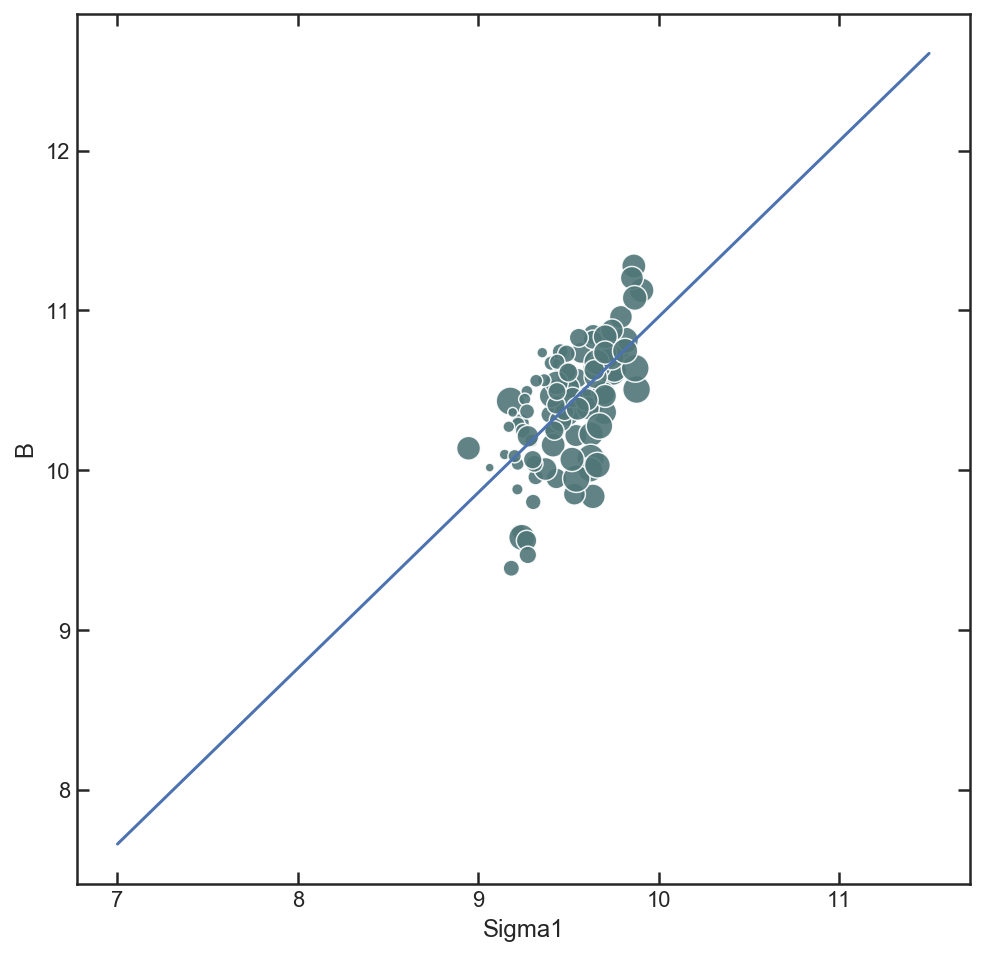

In [96]:
plt.figure(figsize=[8,8])
ax = plt.subplot()    
sea.scatterplot(np.log10(mdb.Sigma1), mdb.B, color = '#507678',size=mdb.lmass,
                 sizes=(20, 200),legend=False, ax=ax, alpha = 0.9)
plt.plot(BS1_x, BS1_y)

In [3]:
sb_ls_3 = np.loadtxt('../data/sig1_cartoon/SB_ls_3_main.dat').T
sb_gt_3 = np.loadtxt('../data/sig1_cartoon/SB_gt_3_main.dat').T
ef = np.loadtxt('../data/sig1_cartoon/EF_main.dat').T


rshift_ls = [6,5,4,3.5,3,2.5,2]
sfr_ls = [10,10,30,30,50,200,100]

rshift_gt = [10, 8, 6, 5, 4.5, 4, 3.5, 3, 2.5, 2]              
sfr_gt = [10, 10, 15, 20, 50, 100, 200, 150, 100, 50]

rshift_ef = [9 , 8, 7.5, 7, 6, 5, 4, 3, 2.5, 2]
sfr_ef = [10, 10, 20, 40, 60, 150, 200, 150, 100, 20]

In [23]:
def B_value(Reff, mass):
    return np.log10(mass / Reff**1.5)

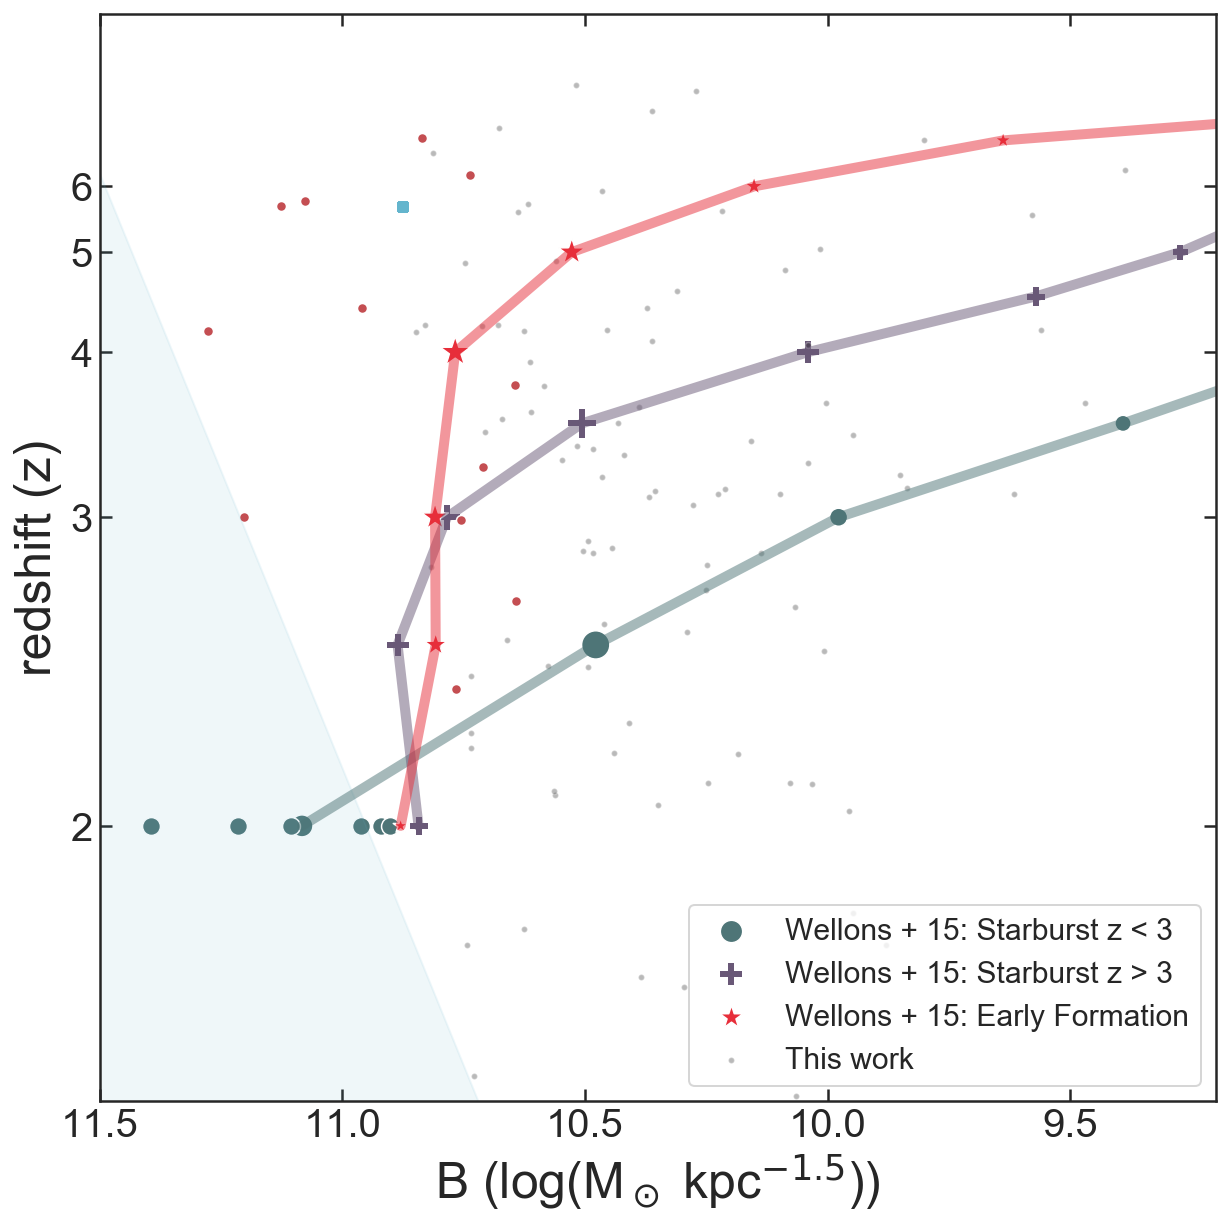

In [408]:
ls_e = np.loadtxt('../data/sig1_cartoon/SB_ls3/endpoints.csv').T
gt_e = np.loadtxt('../data/sig1_cartoon/SB_gt3/endpoints.csv').T
ef_e = np.loadtxt('../data/sig1_cartoon/EF/endpoints.csv').T


ls_B = B_value(sb_ls_3[1], 10**sb_ls_3[0])
ls_B[-1] = np.mean(B_value(ls_e[1], 10**ls_e[0]))

gt_B = B_value(sb_gt_3[1], 10**sb_gt_3[0])
gt_B[-1] = np.mean(B_value(gt_e[1], 10**gt_e[0]))

ef_B = B_value(ef[1], 10**ef[0])
ef_B[-1]  = np.mean(B_value(ef_e[1], 10**ef_e[0]))

plt.figure(figsize=[10,10])
sea.scatterplot(ls_B,cosmo.lookback_time(rshift_ls), size = sfr_ls,
                legend=False, sizes=(50, 200), marker="o", color = '#4E7577', label = 'Wellons + 15: Starburst z < 3')
sea.scatterplot(B_value(ls_e[1], 10**ls_e[0]),cosmo.lookback_time(np.repeat(2, len(ls_e[0]))),
                legend=False, marker="o", color = '#4E7577', s = 80)

sea.scatterplot(gt_B ,cosmo.lookback_time(rshift_gt), size = sfr_gt,
                legend=False, sizes=(50, 200), marker="+", linewidth = 3, color = '#695877', label = 'Wellons + 15: Starburst z > 3')
# sea.scatterplot(B_value(gt_e[1], 10**gt_e[0]),cosmo.lookback_time(np.repeat(2, len(gt_e[0]))), 
#                 legend=False, marker="+", linewidth = 3, color = '#695877', s = 60)

sea.scatterplot(ef_B,cosmo.lookback_time(rshift_ef), size = sfr_ef,
                legend=False, sizes=(50, 250), marker="*", color = '#E72E3A', label = 'Wellons + 15: Early Formation')
# sea.scatterplot(B_value(ef_e[1], 10**ef_e[0]),cosmo.lookback_time(np.repeat(2, len(ef_e[0]))),
#                 legend=False, marker="*", color = '#E72E3A', s = 80)

plt.plot(ls_B, cosmo.lookback_time(rshift_ls),color = '#4E7577', linewidth = 5, alpha = 0.5)
plt.plot(gt_B, cosmo.lookback_time(rshift_gt),color = '#695877', linewidth = 5, alpha = 0.5)
plt.plot(ef_B,cosmo.lookback_time(rshift_ef),color = '#E72E3A', linewidth = 5, alpha = 0.5)

sea.scatterplot(mdb.B, cosmo.lookback_time(mdb.z_50),marker=".", color = 'k', alpha = 0.3, label = 'This work')
sea.scatterplot(mdb.query('lmass >= 11 and Re < 2').B, cosmo.lookback_time(mdb.query('lmass >= 11 and Re < 2').z_50),marker=".",s=100, color = 'r', alpha = 1)
sea.scatterplot(mdb.query('id == 17746').B, cosmo.lookback_time(mdb.query('id == 17746').z_50),marker="+", color = 'c', alpha = 1, linewidth = 5,)

x2=11.2
x1=10.72
y2=11.6
y1=9.5

m = (y2-y1) / (x2-x1)
X = np.linspace(10.5,11.5)
Y = m*(X - x1) + y1

plt.fill_between(X,Y, color = 'c', alpha = 0.1)

plt.xlim(11.5, 9.2)

ylbt = cosmo.lookback_time([2,3,4,5,6]).value

plt.yticks(ylbt, [2,3,4,5,6])
plt.ylim(9.5,13.5)

plt.legend(loc = 4, fontsize = 15)
plt.xlabel('B (log(M$_\odot$ kpc$^{-1.5}$))', fontsize=25)
plt.ylabel('redshift (z)', fontsize=25)
plt.tick_params(axis='both', which='major', labelsize=20)
# plt.savefig('../plots/evo_tracks.png', bbox_inches = 'tight')

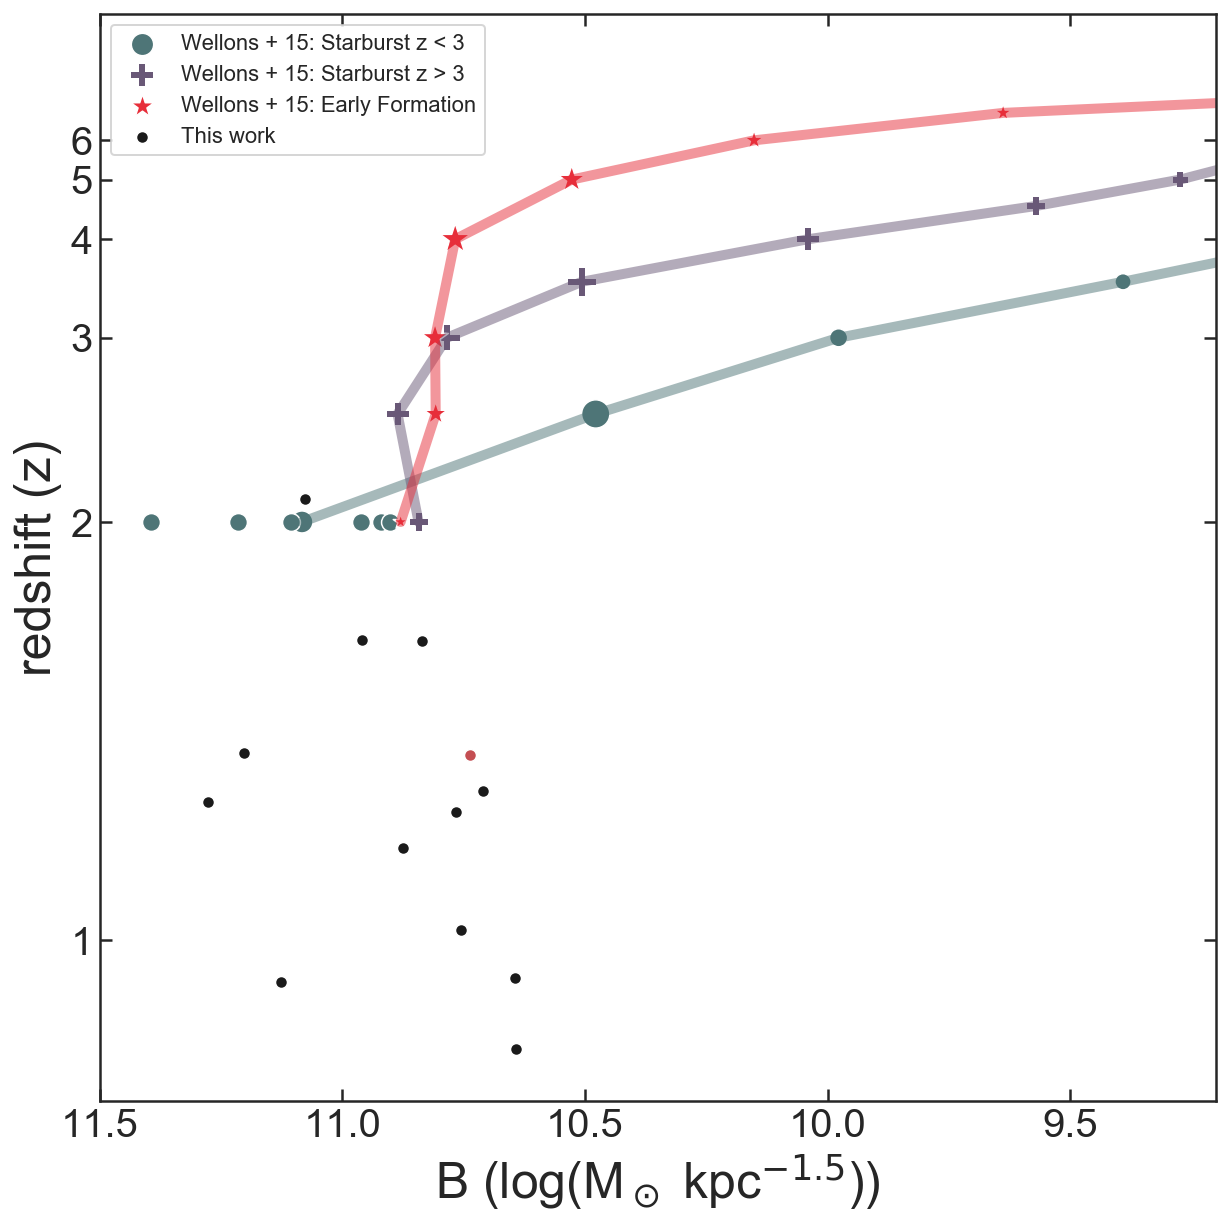

In [410]:
ls_e = np.loadtxt('../data/sig1_cartoon/SB_ls3/endpoints.csv').T
gt_e = np.loadtxt('../data/sig1_cartoon/SB_gt3/endpoints.csv').T
ef_e = np.loadtxt('../data/sig1_cartoon/EF/endpoints.csv').T


ls_B = B_value(sb_ls_3[1], 10**sb_ls_3[0])
ls_B[-1] = np.mean(B_value(ls_e[1], 10**ls_e[0]))

gt_B = B_value(sb_gt_3[1], 10**sb_gt_3[0])
gt_B[-1] = np.mean(B_value(gt_e[1], 10**gt_e[0]))

ef_B = B_value(ef[1], 10**ef[0])
ef_B[-1]  = np.mean(B_value(ef_e[1], 10**ef_e[0]))

plt.figure(figsize=[10,10])
sea.scatterplot(ls_B,cosmo.lookback_time(rshift_ls), size = sfr_ls,
                legend=False, sizes=(50, 200), marker="o", color = '#4E7577', label = 'Wellons + 15: Starburst z < 3')
sea.scatterplot(B_value(ls_e[1], 10**ls_e[0]),cosmo.lookback_time(np.repeat(2, len(ls_e[0]))),
                legend=False, marker="o", color = '#4E7577', s = 80)

sea.scatterplot(gt_B ,cosmo.lookback_time(rshift_gt), size = sfr_gt,
                legend=False, sizes=(50, 200), marker="+", linewidth = 3, color = '#695877', label = 'Wellons + 15: Starburst z > 3')
# sea.scatterplot(B_value(gt_e[1], 10**gt_e[0]),cosmo.lookback_time(np.repeat(2, len(gt_e[0]))), 
#                 legend=False, marker="+", linewidth = 3, color = '#695877', s = 60)

sea.scatterplot(ef_B,cosmo.lookback_time(rshift_ef), size = sfr_ef,
                legend=False, sizes=(50, 250), marker="*", color = '#E72E3A', label = 'Wellons + 15: Early Formation')
# sea.scatterplot(B_value(ef_e[1], 10**ef_e[0]),cosmo.lookback_time(np.repeat(2, len(ef_e[0]))),
#                 legend=False, marker="*", color = '#E72E3A', s = 80)

plt.plot(ls_B, cosmo.lookback_time(rshift_ls),color = '#4E7577', linewidth = 5, alpha = 0.5)
plt.plot(gt_B, cosmo.lookback_time(rshift_gt),color = '#695877', linewidth = 5, alpha = 0.5)
plt.plot(ef_B,cosmo.lookback_time(rshift_ef),color = '#E72E3A', linewidth = 5, alpha = 0.5)

sea.scatterplot(mdb.query('lmass >= 11 and Re < 2').B, cosmo.lookback_time(mdb.query('lmass >= 11 and Re < 2').zgrism),marker="o", color = 'k', alpha = 1, label = 'This work')
sea.scatterplot(mdb.query('id == 46066').B, cosmo.lookback_time(mdb.query('id == 46066').zgrism),marker="o", color = 'r', alpha = 1)


# x2=11.2
# x1=10.72
# y2=11.6
# y1=9.5

# m = (y2-y1) / (x2-x1)
# X = np.linspace(10.5,11.5)
# Y = m*(X - x1) + y1

# plt.fill_between(X,Y, color = 'c', alpha = 0.1)

plt.xlim(11.5, 9.2)

ylbt = cosmo.lookback_time([1,2,3,4,5,6]).value

plt.yticks(ylbt, [1,2,3,4,5,6])
# plt.ylim(9.5,13.5)

# plt.legend(loc = 4, fontsize = 15)
plt.xlabel('B (log(M$_\odot$ kpc$^{-1.5}$))', fontsize=25)
plt.ylabel('redshift (z)', fontsize=25)
plt.tick_params(axis='both', which='major', labelsize=20)
# plt.savefig('../plots/evo_tracks.png', bbox_inches = 'tight')

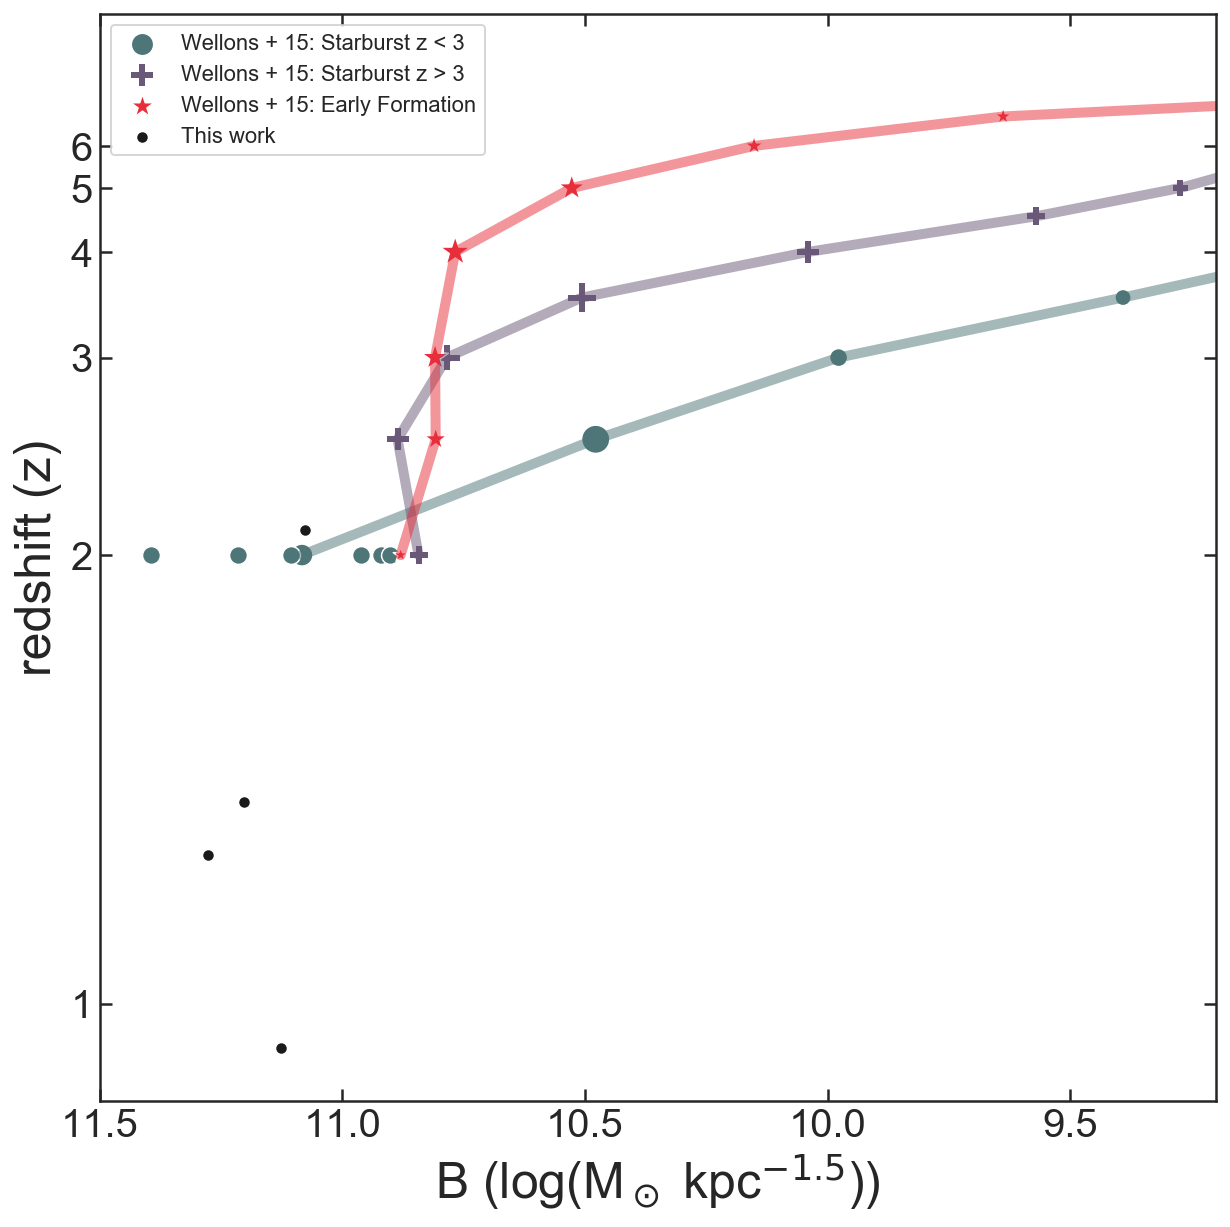

In [412]:
ls_e = np.loadtxt('../data/sig1_cartoon/SB_ls3/endpoints.csv').T
gt_e = np.loadtxt('../data/sig1_cartoon/SB_gt3/endpoints.csv').T
ef_e = np.loadtxt('../data/sig1_cartoon/EF/endpoints.csv').T


ls_B = B_value(sb_ls_3[1], 10**sb_ls_3[0])
ls_B[-1] = np.mean(B_value(ls_e[1], 10**ls_e[0]))

gt_B = B_value(sb_gt_3[1], 10**sb_gt_3[0])
gt_B[-1] = np.mean(B_value(gt_e[1], 10**gt_e[0]))

ef_B = B_value(ef[1], 10**ef[0])
ef_B[-1]  = np.mean(B_value(ef_e[1], 10**ef_e[0]))

plt.figure(figsize=[10,10])
sea.scatterplot(ls_B,cosmo.lookback_time(rshift_ls), size = sfr_ls,
                legend=False, sizes=(50, 200), marker="o", color = '#4E7577', label = 'Wellons + 15: Starburst z < 3')
sea.scatterplot(B_value(ls_e[1], 10**ls_e[0]),cosmo.lookback_time(np.repeat(2, len(ls_e[0]))),
                legend=False, marker="o", color = '#4E7577', s = 80)

sea.scatterplot(gt_B ,cosmo.lookback_time(rshift_gt), size = sfr_gt,
                legend=False, sizes=(50, 200), marker="+", linewidth = 3, color = '#695877', label = 'Wellons + 15: Starburst z > 3')
# sea.scatterplot(B_value(gt_e[1], 10**gt_e[0]),cosmo.lookback_time(np.repeat(2, len(gt_e[0]))), 
#                 legend=False, marker="+", linewidth = 3, color = '#695877', s = 60)

sea.scatterplot(ef_B,cosmo.lookback_time(rshift_ef), size = sfr_ef,
                legend=False, sizes=(50, 250), marker="*", color = '#E72E3A', label = 'Wellons + 15: Early Formation')
# sea.scatterplot(B_value(ef_e[1], 10**ef_e[0]),cosmo.lookback_time(np.repeat(2, len(ef_e[0]))),
#                 legend=False, marker="*", color = '#E72E3A', s = 80)

plt.plot(ls_B, cosmo.lookback_time(rshift_ls),color = '#4E7577', linewidth = 5, alpha = 0.5)
plt.plot(gt_B, cosmo.lookback_time(rshift_gt),color = '#695877', linewidth = 5, alpha = 0.5)
plt.plot(ef_B,cosmo.lookback_time(rshift_ef),color = '#E72E3A', linewidth = 5, alpha = 0.5)

sea.scatterplot(mdb.query('lmass >= 11 and Re < 2 and B > 11').B, cosmo.lookback_time(mdb.query('lmass >= 11 and Re < 2 and B > 11').zgrism),marker="o", color = 'k', alpha = 1, label = 'This work')


# x2=11.2
# x1=10.72
# y2=11.6
# y1=9.5

# m = (y2-y1) / (x2-x1)
# X = np.linspace(10.5,11.5)
# Y = m*(X - x1) + y1

# plt.fill_between(X,Y, color = 'c', alpha = 0.1)

plt.xlim(11.5, 9.2)

ylbt = cosmo.lookback_time([1,2,3,4,5,6]).value

plt.yticks(ylbt, [1,2,3,4,5,6])
# plt.ylim(9.5,13.5)

# plt.legend(loc = 4, fontsize = 15)
plt.xlabel('B (log(M$_\odot$ kpc$^{-1.5}$))', fontsize=25)
plt.ylabel('redshift (z)', fontsize=25)
plt.tick_params(axis='both', which='major', labelsize=20)
# plt.savefig('../plots/evo_tracks.png', bbox_inches = 'tight')

In [386]:
mdb.query('lmass >= 11 and Re < 2')[['field','id']]

field     id
3     GND  13774
8     GND  17070
12    GND  22213
22    GND  27185
40    GND  37340
41    GND  37686
53    GSD  39804
57    GSD  40597
61    GSD  41520
87    GND  17746
94    GND  21738
144   GSD  39012
156   GSD  46066

In [413]:
mdb.query('lmass >= 11 and Re < 2 and B > 11')[['field','id']]

field     id
8    GND  17070
12   GND  22213
53   GSD  39804
94   GND  21738

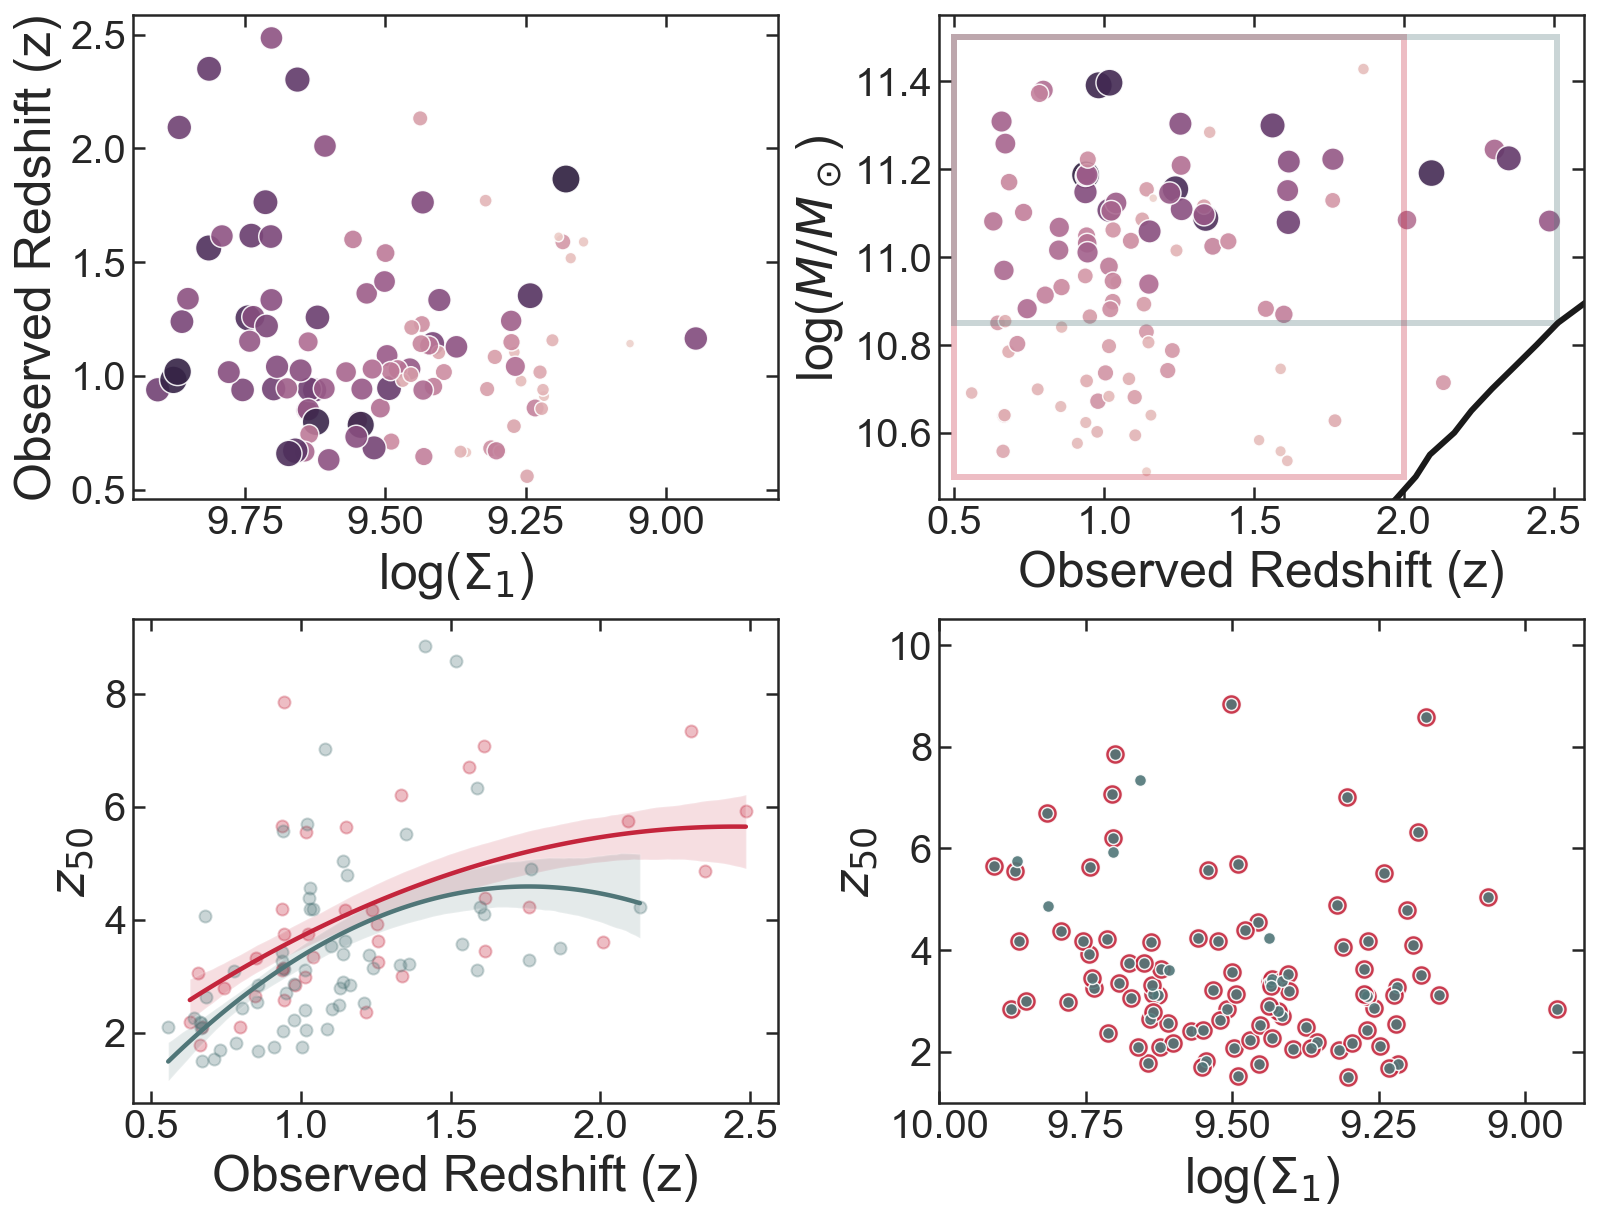

In [315]:
gs = gridspec.GridSpec(2,2,hspace=0.25, wspace = 0.25)

plt.figure(figsize = [13,10])

ax1 = plt.subplot(gs[0,0])
sea.scatterplot(np.log10(mdb.Sigma1), mdb.zgrism,  size=mdb.lmass, hue = mdb.lmass,
                 sizes=(20, 200),legend=False, ax=ax1, alpha = 0.9)
plt.xlim(9.95,8.8)
ax1.set_xlabel('log($\Sigma_1$)', fontsize=25)
ax1.set_ylabel('Observed Redshift (z)', fontsize=25)
plt.tick_params(axis='both', which='major', labelsize=20)

ax2 = plt.subplot(gs[1,0])
Cmdb = mdb.query('Sigma1 > {0}'.format(10**9.6))
Emdb = mdb.query('Sigma1 < {0}'.format(10**9.6))
sea.regplot(Cmdb.zgrism, Cmdb.z_50,order=2, color = '#C4253C',truncate=True, ax=ax2, ci = 68, scatter_kws={'alpha':0.3})
sea.regplot(Emdb.zgrism, Emdb.z_50,order=2, color = '#507678',truncate=True, ax=ax2, ci = 68, scatter_kws={'alpha':0.3})
ax2.set_xlabel('Observed Redshift (z)', fontsize=25)
ax2.set_ylabel('$z_{50}$', fontsize=25)
plt.tick_params(axis='both', which='major', labelsize=20)

ax3 = plt.subplot(gs[0,1])
zlimit,masslimit = np.load('../data/masslimit.npy')


sea.scatterplot(mdb.zgrism,mdb.lmass, size=mdb.Sigma1, hue = mdb.Sigma1,
                 sizes=(20, 200),legend=False, ax=ax3, alpha = 0.9)
plt.plot(zlimit,masslimit, 'k',linewidth = 3)
ax3.set_ylabel('log($M/M_\odot$)', fontsize=25)
ax3.set_xlabel('Observed Redshift (z)', fontsize=25)
plt.tick_params(axis='both', which='major', labelsize=20)

rectangle=plt.Rectangle([0.5,10.5],1.5,1.0, fill = False, linewidth = 3, color = '#C4253C', alpha = 0.3)
ax3.add_artist(rectangle)

rectangle2=plt.Rectangle([0.5,10.85],2.01, 0.65, fill = False, linewidth = 3, color = '#507678', alpha = 0.3)
ax3.add_artist(rectangle2)
ax3.set_ylim(10.45,11.55)
ax3.set_xlim(0.45,2.6)

ax4 = plt.subplot(gs[1,1]) 

mdbs1 = mdb.query('zgrism < 2.0')
mdbs2 = mdb.query('lmass >= 10.45')

sea.scatterplot(np.log10(mdbs1.Sigma1), mdbs1.z_50, color = '#C4253C', s= 100,
                 sizes=(20, 200),legend=False, ax=ax4, alpha = 0.9)
sea.scatterplot(np.log10(mdbs2.Sigma1), mdbs2.z_50, color = '#507678',
                 sizes=(40, 200),legend=False, ax=ax4, alpha = 0.9)

plt.ylim(1,10.5)
plt.xlim(10.,8.9)
ax4.set_xlabel('log($\Sigma_1$)', fontsize=25)
ax4.set_ylabel('$z_{50}$', fontsize=25)
plt.tick_params(axis='both', which='major', labelsize=20)

plt.savefig('../plots/select.pdf', bbox_inches = 'tight')

In [57]:
np.log10(2.48E9)

9.394451680826217

In [58]:
mdb.query('Sigma1 < 10**9.5 and z_50 < 3.26')[['field','id', 'zgrism', 'Sigma1', 'z_50']]

field     id   zgrism        Sigma1      z_50
0     GND  12078  1.01637  2.487509e+09  2.048606
1     GND  12793  0.95257  2.596482e+09  2.694991
4     GND  14158  0.91086  1.648986e+09  1.752982
20    GND  24795  0.85846  1.710267e+09  1.676884
21    GND  26673  0.94168  2.082883e+09  2.033669
27    GND  30358  1.10387  1.862767e+09  2.427042
28    GND  32108  0.85550  1.664525e+09  2.543779
33    GND  36348  1.08933  3.141287e+09  2.073032
37    GND  37189  1.58847  1.401848e+09  3.112878
42    GND  37813  0.94569  3.116125e+09  3.126796
49    GSD  38191  0.97701  1.812532e+09  2.862133
55    GSD  39850  0.97955  2.945618e+09  2.232272
56    GSD  40476  1.21218  2.839757e+09  2.517448
59    GSD  40862  1.33310  2.534604e+09  3.194877
62    GSD  42221  1.01615  1.676269e+09  3.112637
68    GSD  45789  1.00465  2.848670e+09  1.753627
72    GSD  47691  1.12724  2.362471e+09  2.481000
73    GSD  48631  1.16388  8.840729e+08  2.841227
75    GND  12481  0.66315  2.266446e+09  2.193379
91    GND  20567  0.64500  2.701196e+09  2.262413
92    GND  21047  0.55840  1.767788e+09  2.103455
93    GND  21724  1.13290  2.643935e+09  2.792047
95    GND  22027  1.14110  2.733226e+09  2.892458
97    GND  22358  0.77856  1.865615e+09  3.096263
109   GND  29879  0.71073  3.087729e+09  1.529904
136   GSD  34671  0.66654  2.322991e+09  2.082601
140   GSD  38173  0.66802  1.975918e+09  2.177048
141   GSD  38785  1.24131  1.887296e+09  3.135804
159   GSD  46274  0.67027  2.005353e+09  1.499469

In [4]:
lowlim = 10.4
lm_errbin = []

while lowlim < 11.6:
    lowerr = []
    hierr = []
    for i in mdb.index:
        if lowlim < mdb.lmass[i] < lowlim + 0.4:
            for ii in range(len(mdb.lmass_hci[i])//2):
                if mdb.lmass_hci[i][2*ii] <= mdb.lmass[i] <= mdb.lmass_hci[i][2*ii+1]:
                    lowerr.append(mdb.lmass_hci[i][2*ii])
                    hierr.append(mdb.lmass_hci[i][2*ii+1])
       
    lm_errbin.append(np.median((np.array(hierr) - np.array(lowerr))/2))
    
    
    lowlim += 0.4
    
    
lowlim = 0
Re_errbin = []

while lowlim < 15:
    
    print(lowlim + 2)
    sig = []
    for i in mdb.index:
        if lowlim < mdb.Re[i] < lowlim + 4:
            sig.append(mdb.Re_sig[i])
       
    Re_errbin.append(np.median(sig))
    
    
    lowlim += 4

2
6
10
14


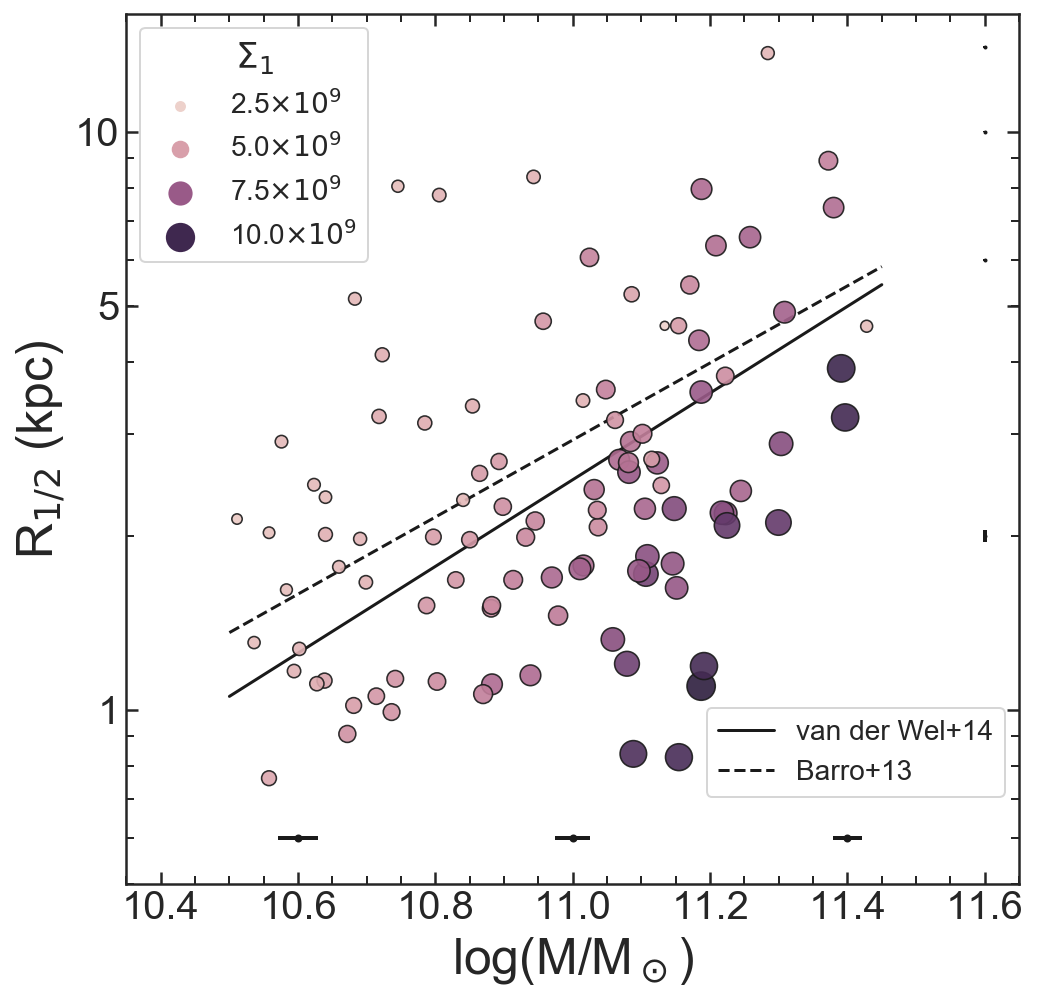

In [5]:
def A_limit(mass, Alimit):
    return Alimit * (mass / 1E11)**0.75

def B_limit(mass, Blimit):
    return (mass / Blimit)**(1/1.5)


plt.figure(figsize=[8,8])
ax = plt.subplot()
    
g = sea.scatterplot(mdb.lmass, mdb.Re, color = '#507678',
                hue = mdb.Sigma1, 
                size= mdb.Sigma1,
                sizes=(20, 200),legend='brief', ax=ax, alpha = 0.9, linewidth = 0.8, edgecolor = 'k', zorder =5)


lml = []
lmh = []
lm = []
for i in mdb.index:
    for ii in range(len(mdb.lmass_hci[i])//2):
        if mdb.lmass_hci[i][2*ii] <= mdb.lmass[i] <= mdb.lmass_hci[i][2*ii+1]:
            lml.append(mdb.lmass[i] - mdb.lmass_hci[i][2*ii])
            lmh.append(mdb.lmass_hci[i][2*ii+1] - mdb.lmass[i])
            lm.append(mdb.lmass[i])

mass = 10**np.linspace(10.5,11.45)
            
plt.plot(np.log10(mass), A_limit(mass, 2.5), 'k', label = 'Van der Wel+14')
plt.plot(np.log10(mass), B_limit(mass, 10**10.3),'--k', label = 'Barro+17')

handles, _ = ax.get_legend_handles_labels()
l2 = plt.legend(handles[:2], ['van der Wel+14','Barro+13'], fontsize = 14, loc = [0.65,0.1])
ax.add_artist(l2)
ax.legend(handles[3:], ['2.5$\\times 10^9$','5.0$\\times 10^9$','7.5$\\times 10^9$','10.0$\\times 10^9$'],title = '$\Sigma_1$', 
          loc = 2,fontsize = 14)
ax.get_legend().get_title().set_fontsize('18')

plt.errorbar([10.6,11.0,11.4],[0.6,0.6,0.6], xerr=lm_errbin, fmt = 'o',ms=3, color = 'k', elinewidth=2)
plt.errorbar([11.6, 11.6, 11.6, 11.6],[2,6,10,14], yerr=Re_errbin, fmt = 'o',ms=1, color = 'k', elinewidth=2)

plt.ylim(0.5,16)   
plt.yscale('log')
plt.yticks([1,5,10],[1,5,10], zorder =1)
plt.ylabel('R$_{1/2}$ (kpc)', fontsize=25)
plt.xlabel('log(M/M$_\odot$)', fontsize=25)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.xlim(10.35,11.65)
plt.savefig('../plots/presentation_plots/r_lm.png', bbox_inches = 'tight')

In [149]:
lowlim = 0.5
z_errbin = []

while lowlim < 2.4:
    print(lowlim + 0.1)

    lowerr = []
    hierr = []
    for i in mdb.index:
        if lowlim < mdb.zgrism[i] < lowlim + 0.2:
            for ii in range(len(mdb.zgrism_hci[i])//2):
                if mdb.zgrism_hci[i][2*ii] <= mdb.zgrism[i] <= mdb.zgrism_hci[i][2*ii+1]:
                    lowerr.append(mdb.zgrism_hci[i][2*ii])
                    hierr.append(mdb.zgrism_hci[i][2*ii+1])
       
    z_errbin.append(np.median((np.array(hierr) - np.array(lowerr))/2))
    
    lowlim += 0.2

0.6
0.7999999999999999
0.9999999999999999
1.2
1.4
1.5999999999999999
1.7999999999999998
1.9999999999999998
2.1999999999999997
2.4


In [148]:
z_errbin

[0.0013048826034454675,
 0.001799739071015355,
 0.0019750267407248057,
 0.0039031090897519993,
 0.0036855629725188743,
 0.005909205204005119,
 0.013592187043081072,
 0.005974054412722141,
 0.01791147642609614,
 0.009276936530800528]

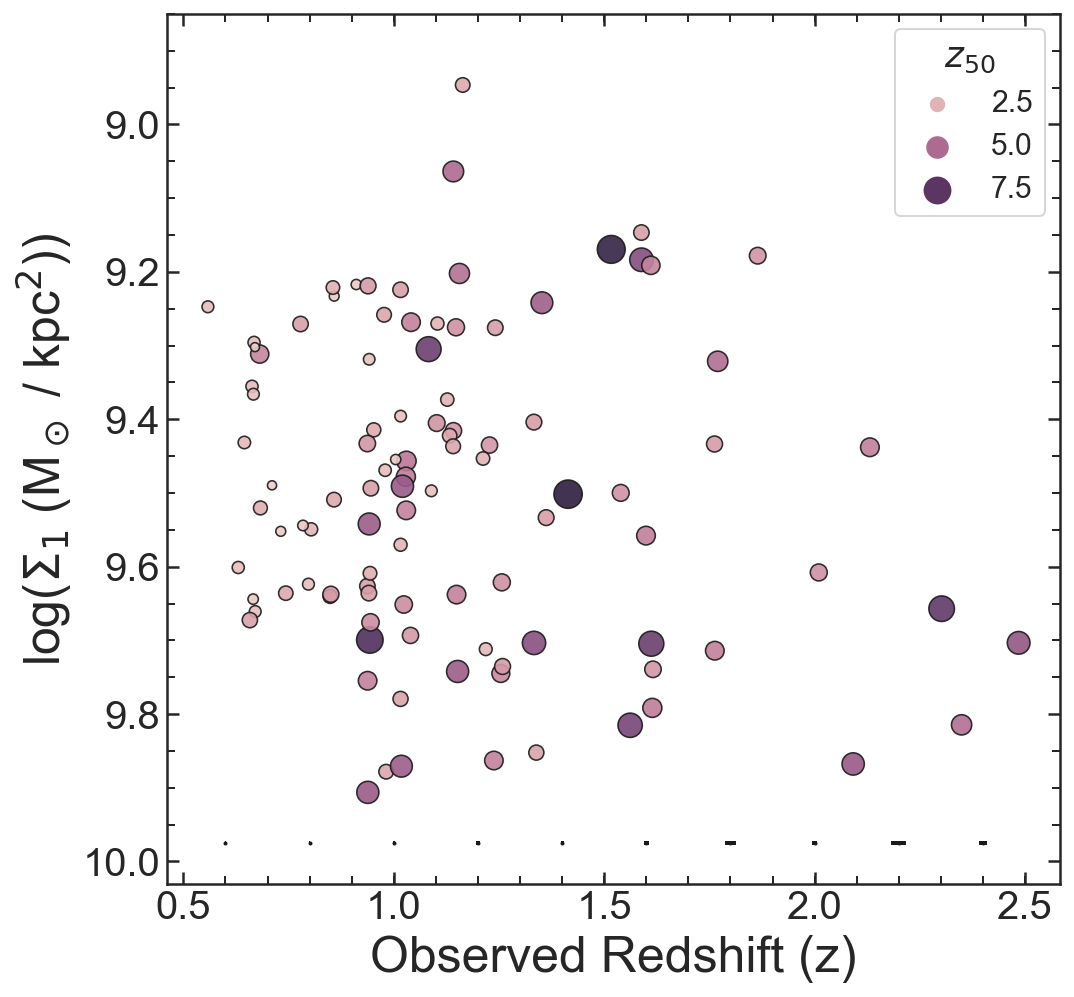

In [203]:
plt.figure(figsize=[8,8])
ax = plt.subplot()
    
g = sea.scatterplot(mdb.zgrism, np.log10(mdb.Sigma1),  color = '#507678',
                hue = mdb.z_50, 
                size= mdb.z_50,
                sizes=(20, 200),legend='brief', ax=ax, alpha = 0.9, linewidth = 0.8, edgecolor = 'k', zorder =5)

plt.ylim(10.03,8.85)

handles, _ = ax.get_legend_handles_labels()
ax.legend(handles[2:], ['2.5','5.0','7.5'],title = '$z_{50}$', 
          loc = 1,fontsize = 15)
ax.get_legend().get_title().set_fontsize('18')

plt.errorbar([0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0, 2.2, 2.4],
             [9.975, 9.975, 9.975, 9.975, 9.975, 9.975, 9.975, 9.975, 9.975, 9.975],
              xerr=z_errbin, fmt = 'o',ms=1, color = 'k', elinewidth=2)

plt.ylabel('log($\Sigma_1$ (M$_\odot$ / kpc$^2$))', fontsize=25)
plt.xlabel('Observed Redshift (z)', fontsize=25)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.minorticks_on()
plt.savefig('../plots/presentation_plots/z_sigma1.png', bbox_inches = 'tight')

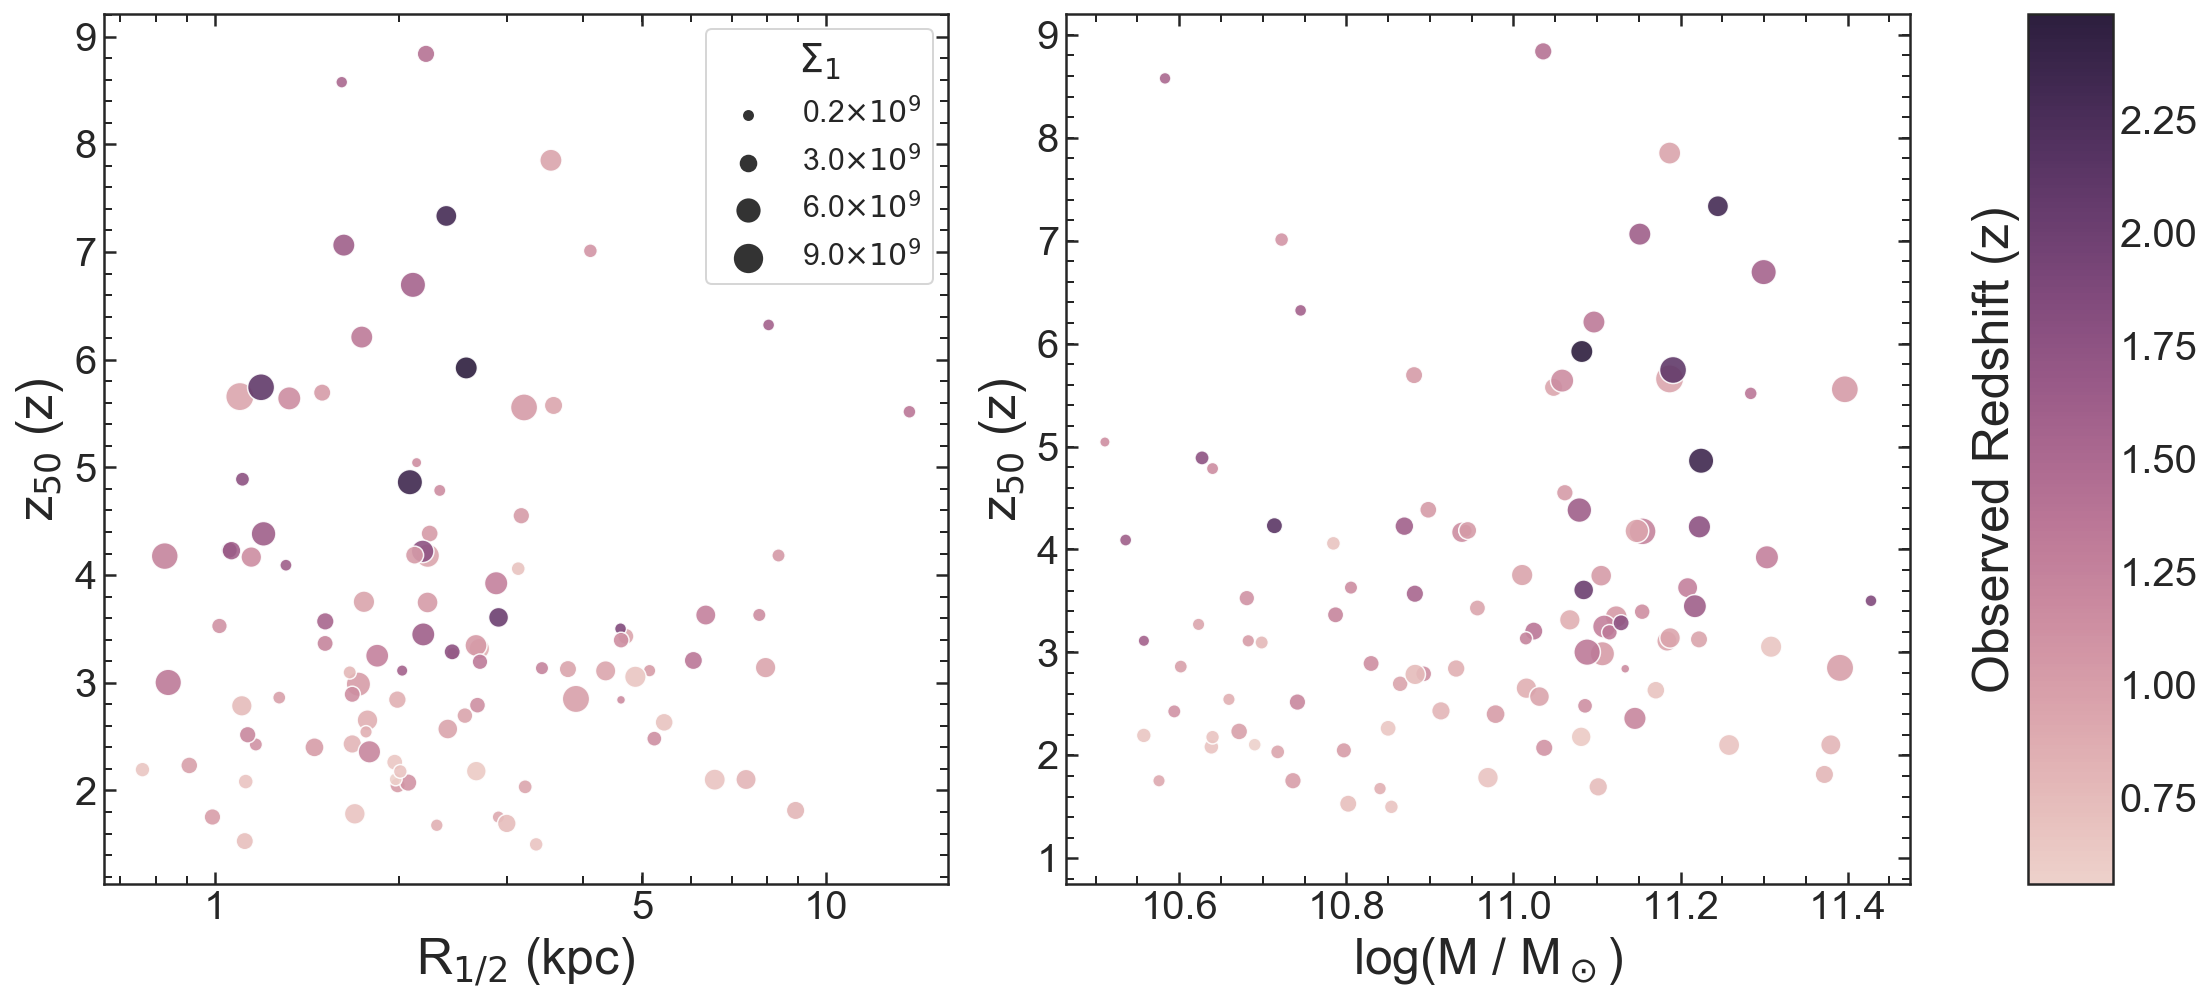

In [6]:
gs = gridspec.GridSpec(1,3,width_ratios=[1,1,.1])
plt.figure(figsize=[18,8])
ax1 = plt.subplot(gs[0])

sea.scatterplot(mdb.Re, mdb.z_50, color = '#507678',
                size=mdb.Sigma1, hue=mdb.zgrism,sizes=(20, 200),legend='brief', ax=ax1, alpha = 0.9)

plt.xlabel('R$_{1/2}$ (kpc)', fontsize=25)
plt.ylabel('z$_{50}$ (z)', fontsize=25)
plt.tick_params(axis='both', which='major', labelsize=20)

handles, _ = ax1.get_legend_handles_labels()
ax1.legend(handles[7:], ['0.2$\\times 10^9$','3.0$\\times 10^9$','6.0$\\times 10^9$','9.0$\\times 10^9$'],title = '$\Sigma_1$', fontsize = 15)
ax1.get_legend().get_title().set_fontsize('20')
# ax1.set_ylim(0.75,9.2)
plt.xscale('log')
plt.xticks([1,5,10],[1,5,10], zorder =1)


ax2 = plt.subplot(gs[1])
s2 = sea.scatterplot(mdb.lmass, mdb.z_50,
                size=mdb.Sigma1, hue=mdb.zgrism,sizes=(20, 200),legend=False, ax=ax2, alpha = 0.9)
plt.xlabel('log(M / M$_\odot$)', fontsize=25)
plt.ylabel('z$_{50}$ (z)', fontsize=25)
plt.tick_params(axis='both', which='major', labelsize=20)
ax2.set_ylim(0.75,9.2)


ax3 = plt.subplot(gs[2])
cmap = sea.cubehelix_palette(8, as_cmap=True)
norm = mpl.colors.Normalize(vmin=min(mdb.zgrism), vmax = max(mdb.zgrism))
mpl.colorbar.ColorbarBase(ax3, cmap = cmap, norm=norm, orientation='vertical')
ax3.set_ylabel('Observed Redshift (z)', fontsize=25)
plt.tick_params(axis='both', which='major', labelsize=20)
ax3.yaxis.set_label_position('left')
plt.savefig('../plots/presentation_plots/z50_all.png', bbox_inches = 'tight')

In [18]:
lowlim = 1
z5_errbin_ls = []
z5_errbin_hs = []

while lowlim < 9:
    print(lowlim)
    
    if lowlim < 5:
        addage = 2
    else:
        addage = 4

    lowerr = []
    hierr = []
    for i in mdb.index:
        lowerr.append(cosmo.lookback_time(mdb.z_50_hci[i][0]).value)
        hierr.append(cosmo.lookback_time(mdb.z_50_hci[i][1]).value)
       
    z5_errbin_hs.append(np.median((np.array(hierr) - np.array(lowerr))/2))
    
    if lowlim < 5:
        lowlim += addage
    else:
        lowlim += addage
lowlim = 1
       
while lowlim < 9:
    print(lowlim)
    
    if lowlim < 5:
        addage = 2
    else:
        addage = 4

    
    lowerr = []
    hierr = []
    for i in mdb.index:
        lowerr.append(cosmo.lookback_time(mdb.z_50_hci[i][0]).value)
        hierr.append(cosmo.lookback_time(mdb.z_50_hci[i][1]).value)
       
    z5_errbin_ls.append(np.median((np.array(hierr) - np.array(lowerr))/2))
    
    if lowlim < 5:
        lowlim += addage
    else:
        lowlim += addage

1
3
5
1
3
5


In [20]:
np.median(mdb.z_50)

3.3102712617892474

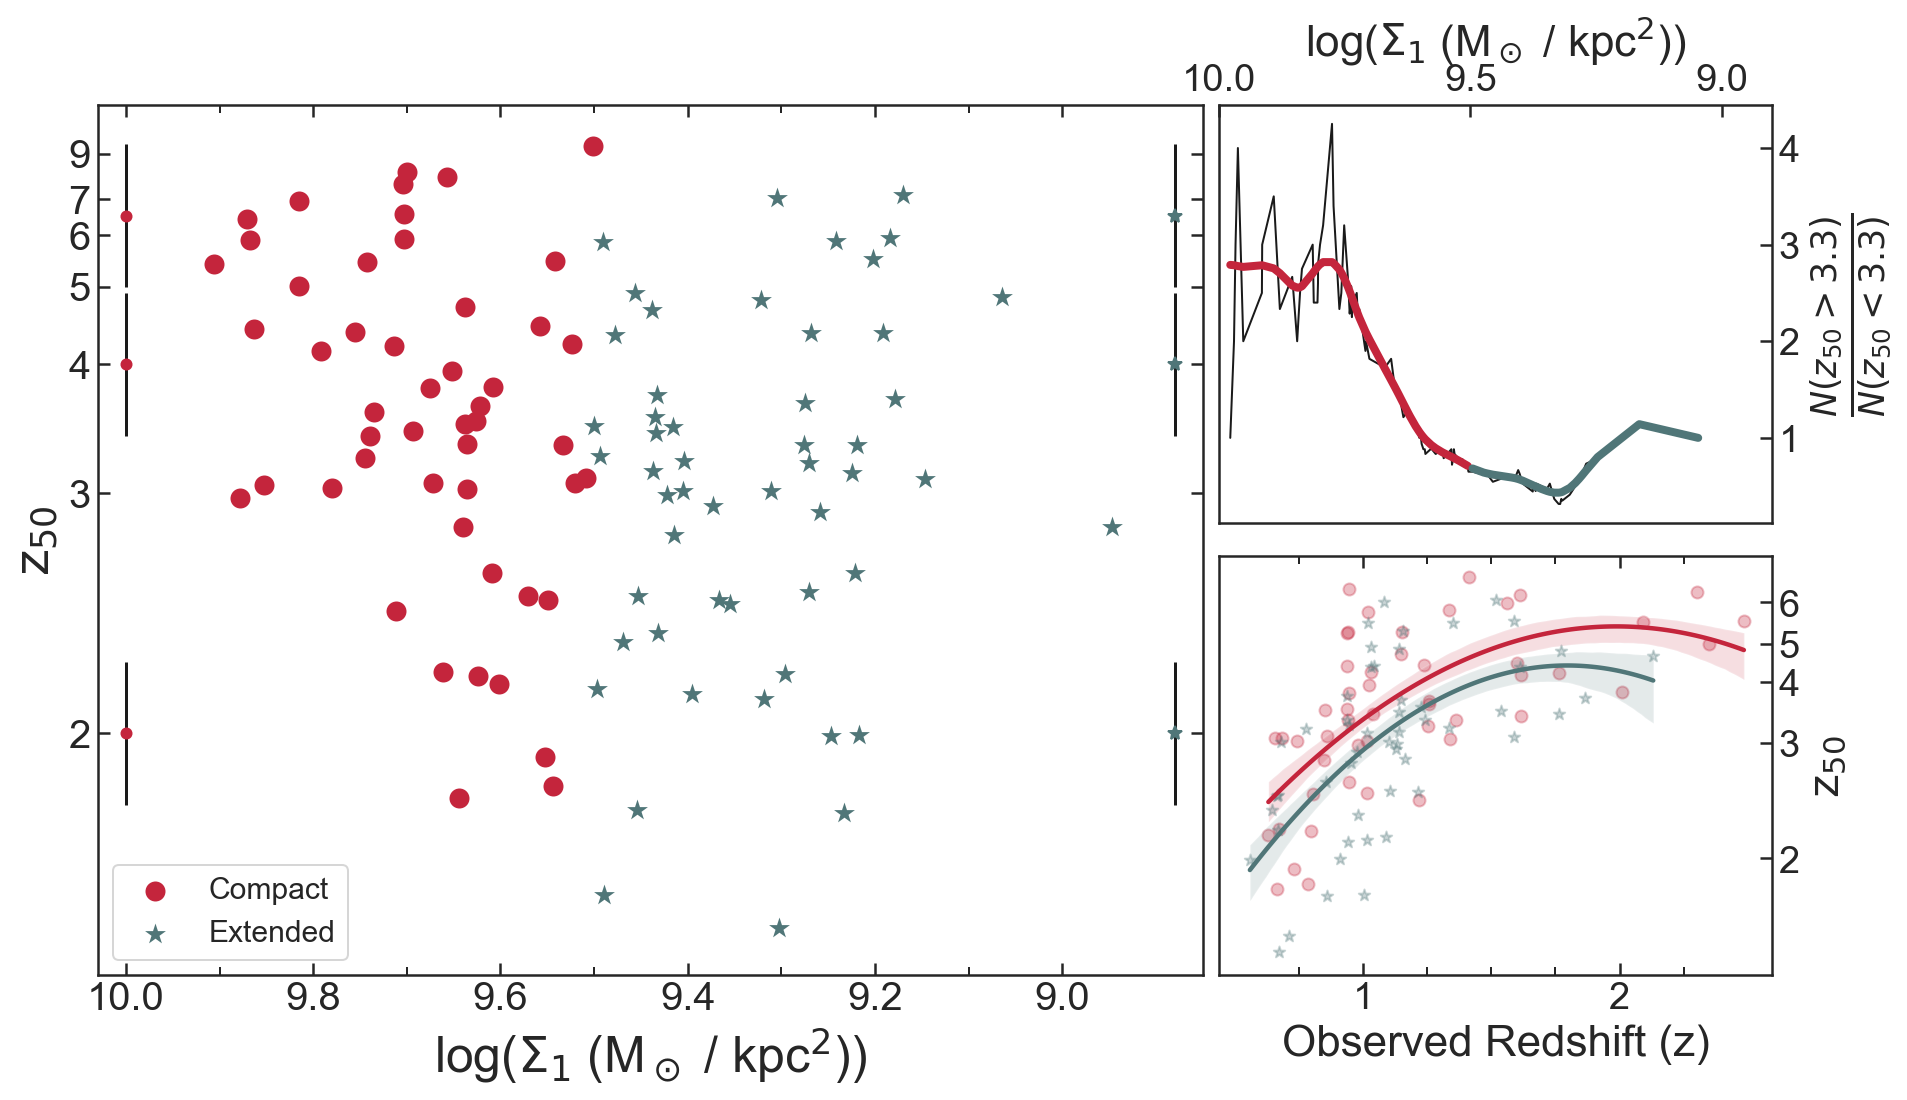

In [22]:
gs = gridspec.GridSpec(2,2,width_ratios=[2,1],hspace=0.08,wspace=0.02)

plt.figure(figsize=[15,8])

ax1 = plt.subplot(gs[:,0])

sea.scatterplot(np.log10(mdb.query('Sigma1 > 10**9.5').Sigma1), 
                cosmo.lookback_time(mdb.query('Sigma1 > 10**9.5').z_50),  linewidth = 0,legend=False,
                sizes=(20, 200), ax=ax1, color = '#C4253C', s = 100, marker = 'o', label = 'Compact')

sea.scatterplot(np.log10(mdb.query('Sigma1 < 10**9.5').Sigma1), 
                cosmo.lookback_time(mdb.query('Sigma1 < 10**9.5').z_50),  linewidth = 0,legend=False,
                sizes=(20, 200), ax=ax1, color = '#507678', s = 120, marker = '*', label = 'Extended')

ax1.set_yticks(cosmo.lookback_time([2,3,4,5,6,7,9]).value)
ax1.set_yticklabels([2,3,4,5,6,7,9])
ax1.minorticks_off()
plt.errorbar([10,10,10],cosmo.lookback_time([2,4,6.5]).value, yerr=z5_errbin_hs, fmt = 'o',ms=5, color = '#C4253C' , ecolor = 'k')
plt.errorbar([8.88,8.88,8.88],cosmo.lookback_time([2,4,6.5]).value, yerr=z5_errbin_ls, fmt = '*',ms=7,color = '#507678', ecolor = 'k')

ax1.set_xticks([ 9.9, 9.7, 9.5, 9.3, 9.1], minor=True)
plt.xlim(10.03,8.85)
plt.xlabel('log($\Sigma_1$ (M$_\odot$ / kpc$^2$))', fontsize=25)
plt.ylabel('z$_{50}$', fontsize=25)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.legend(fontsize=15, loc = 3)

ax2 = plt.subplot(gs[0,1])

med, mn, sratio = Roll_seg(np.log10(mdb.Sigma1.values), mdb.z_50.values, np.median(mdb.z_50), 0.2)

plt.plot(mn, sratio, linewidth=1, color = 'k')
plt.plot(mn[32:],Smooth(mn,sratio,0.03)[32:], linewidth=4, color='#C4253C')
plt.plot(mn[:31],Smooth(mn,sratio,0.03)[:31], linewidth=4, color='#507678')
plt.xlim(10.,8.9)
plt.ylabel('$\\frac{N(z_{50} > 3.3)}{N(z_{50} < 3.3)}$', fontsize=25)
plt.xlabel('log($\Sigma_1$ (M$_\odot$ / kpc$^2$))', fontsize=22)

plt.tick_params(axis='both', which='major', labelsize=19)
ax2.yaxis.set_label_position('right')
ax2.yaxis.set_ticks_position('right')
ax2.xaxis.set_label_position('top')
ax2.xaxis.set_ticks_position('top')

ax3 = plt.subplot(gs[1,1])
Cmdb = mdb.query('Sigma1 > {0}'.format(10**9.5))
Emdb = mdb.query('Sigma1 < {0}'.format(10**9.5))
sea.regplot(Cmdb.zgrism, cosmo.lookback_time(Cmdb.z_50),order=2, 
            color = '#C4253C',truncate=True, ax=ax3, ci = 68, scatter_kws={'alpha':0.3})
sea.regplot(Emdb.zgrism, cosmo.lookback_time(Emdb.z_50),order=2, 
            color = '#507678',truncate=True, ax=ax3, ci = 68, scatter_kws={'alpha':0.3}, marker = '*')
ax3.set_xlabel('Observed Redshift (z)', fontsize=22)
ax3.set_ylabel('z$_{50}$', fontsize=22)

ax3.set_yticks(cosmo.lookback_time([2,3,4,5,7]).value)
ax3.set_yticklabels([2,3,4,5,6,7,9])
ax3.minorticks_off()
ax3.set_xticks([0.75, 1.25, 1.5,1.75, 2.25], minor = True)

ax3.yaxis.set_label_position('right')
ax3.yaxis.set_ticks_position('right')
plt.tick_params(axis='both', which='major', labelsize=19)

plt.savefig('../plots/presentation_plots/compact_sig1.pdf', bbox_inches = 'tight')

In [4]:
mdbq1 = mdb.query('z_50 > 3.3 and Sigma1 > 10**9.5')
mdbq2 = mdb.query('z_50 > 3.3 and Sigma1 < 10**9.5')
mdbq3 = mdb.query('z_50 < 3.3 and Sigma1 > 10**9.5')
mdbq4 = mdb.query('z_50 < 3.3 and Sigma1 < 10**9.5')


In [127]:
[np.median(mdbq1.t_50), np.median(mdbq1.t_80), np.median(mdbq1.t_90), 0] + np.median(cosmo.lookback_time(mdbq1.zgrism).value)

array([12.6930752 , 11.88330885, 11.51728805,  8.84556238])

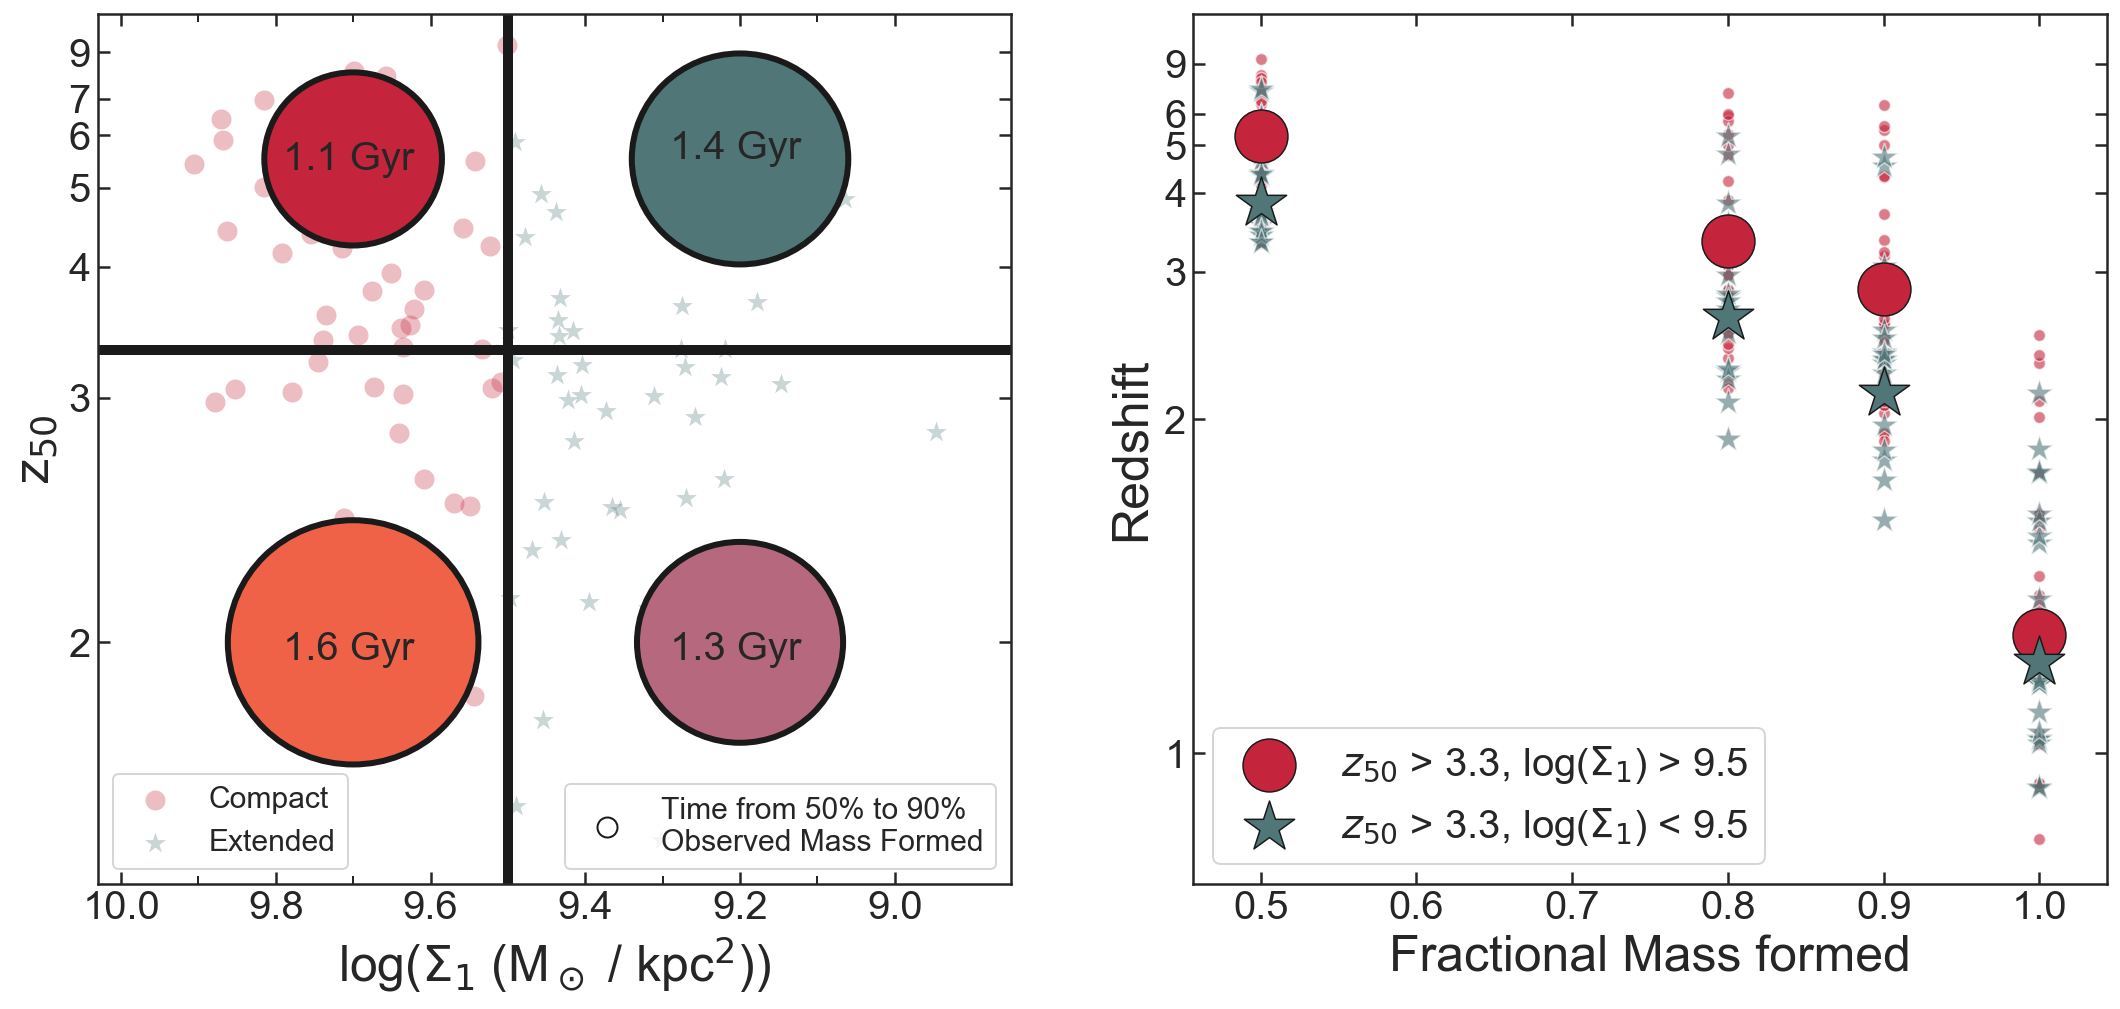

In [24]:
from matplotlib.patches import Ellipse

gs = gridspec.GridSpec(1,2)
plt.figure(figsize=[18,8])
ax1=plt.subplot(gs[0])

plt.xlim(10.03,8.85)

sea.scatterplot(np.log10(mdb.query('Sigma1 > 10**9.5').Sigma1), 
                cosmo.lookback_time(mdb.query('Sigma1 > 10**9.5').z_50),  linewidth = 0,legend=False,
                sizes=(20, 200), ax=ax1, color = '#C4253C', s = 100, marker = 'o', label = 'Compact', alpha = 0.3)

sea.scatterplot(np.log10(mdb.query('Sigma1 < 10**9.5').Sigma1), 
                cosmo.lookback_time(mdb.query('Sigma1 < 10**9.5').z_50),  linewidth = 0,legend=False,
                sizes=(20, 200), ax=ax1, color = '#507678', s = 120, marker = '*', label = 'Extended', alpha = 0.3)

ax1.set_yticks(cosmo.lookback_time([2,3,4,5,6,7,9]).value)
ax1.set_yticklabels([2,3,4,5,6,7,9])

##########
c1 = Ellipse((9.7,cosmo.lookback_time(5.5).value), 0.2 * np.median(mdbq1.t_50 - mdbq1.t_90),0.7 * np.median(mdbq1.t_50 - mdbq1.t_90),
             ec='k', fc='#C4253C', linewidth=3)
ax1.add_artist(c1)
plt.text(9.79,cosmo.lookback_time(5.3).value, '{0:.2} Gyr'.format(np.median(mdbq1.t_50 - mdbq1.t_90)), fontsize=20)
############
c2 = Ellipse((9.2,cosmo.lookback_time(5.5).value), 0.2 * np.median(mdbq2.t_50 - mdbq2.t_90),0.7 * np.median(mdbq2.t_50 - mdbq2.t_90),
             ec='k', fc='#507678', linewidth=3)
ax1.add_artist(c2)
plt.text(9.29,cosmo.lookback_time(5.5).value, '{0:.2} Gyr'.format(np.median(mdbq2.t_50 - mdbq2.t_90)), fontsize=20)
############
c3 = Ellipse((9.7,cosmo.lookback_time(2).value), 0.2 * np.median(mdbq3.t_50 - mdbq3.t_90),0.7 * np.median(mdbq3.t_50 - mdbq3.t_90),
             ec='k', fc = '#F06248', linewidth=3)
ax1.add_artist(c3)
plt.text(9.79,cosmo.lookback_time(1.95).value, '{0:.2} Gyr'.format(np.median(mdbq3.t_50 - mdbq3.t_90)), fontsize=20)
############
c4 = Ellipse((9.2,cosmo.lookback_time(2).value), 0.2 * np.median(mdbq4.t_50 - mdbq4.t_90),0.7 * np.median(mdbq4.t_50 - mdbq4.t_90),
             ec='k',fc = '#B6687E', linewidth=3)
ax1.add_artist(c4)
plt.text(9.29,cosmo.lookback_time(1.95).value, '{0:.2} Gyr'.format(np.median(mdbq4.t_50 - mdbq4.t_90)), fontsize=20)
#############

dummy = plt.Circle((0,0), 0.2, ec='k',fc = 'none', linewidth=2, label ='Time from 50% to 90%')
ax1.add_artist(dummy)


plt.axvline(9.5, color = 'k', linewidth = 5)
plt.axhline(cosmo.lookback_time(3.3).value,color = 'k', linewidth = 5)

ax1.set_xticks([ 9.9, 9.7, 9.5, 9.3, 9.1], minor=True)
plt.xlim(10.03,8.85)
plt.xlabel('log($\Sigma_1$ (M$_\odot$ / kpc$^2$))', fontsize=25)
plt.ylabel('z$_{50}$', fontsize=25)
plt.tick_params(axis='both', which='major', labelsize=20)

leg1 = plt.legend(fontsize=15, loc = 3)

d1, = plt.plot([0,0], "ko", ms=10,)
d2, = plt.plot([0,0], "wo", ms=8) 

ax1.set_ylim(cosmo.lookback_time(1.45).value,cosmo.lookback_time(12).value)

leg2 = ax1.legend([(d1,d2)],['Time from 50% to 90%\nObserved Mass Formed'], loc='lower right',fontsize=15)
# Manually add the first legend back
ax1.add_artist(leg1)

ax2=plt.subplot(gs[1])

for i in mdbq1.index:
    sea.scatterplot([0.5,0.8,0.9,1],np.array([mdbq1.t_50[i], mdbq1.t_80[i], mdbq1.t_90[i],0]) + cosmo.lookback_time(mdbq1.zgrism[i]).value,  
                    legend=False, color = '#C4253C', ax=ax2, marker = 'o', alpha = 0.6)

for i in mdbq2.index:
    sea.scatterplot([0.5,0.8,0.9,1],np.array([mdbq2.t_50[i], mdbq2.t_80[i], mdbq2.t_90[i],0]) + cosmo.lookback_time(mdbq2.zgrism[i]).value,  
                    legend=False, color = '#507678', ax=ax2, marker = '*',s=200, alpha = 0.6)

sea.scatterplot([0.5,0.8,0.9,1],[np.median(mdbq1.t_50), np.median(mdbq1.t_80), np.median(mdbq1.t_90), 0] + np.median(cosmo.lookback_time(mdbq1.zgrism).value),  
                    legend=False, color = '#C4253C', ax=ax2, marker = 'o', label = '$z_{50}$ > 3.3, log($\Sigma_1$) > 9.5',s=700, edgecolor='k')

sea.scatterplot([0.5,0.8,0.9,1],[np.median(mdbq2.t_50), np.median(mdbq2.t_80), np.median(mdbq2.t_90), 0] + np.median(cosmo.lookback_time(mdbq2.zgrism).value),  
                    legend=False, color = '#507678', ax=ax2, marker = '*', label = '$z_{50}$ > 3.3, log($\Sigma_1$) < 9.5',s=700, edgecolor='k')
ax2.set_yticks(cosmo.lookback_time([1,2,3,4,5,6,9]).value)
ax2.set_yticklabels([1,2,3,4,5,6,9])
ax2.minorticks_off()
plt.xlabel('Fractional Mass formed', fontsize=25)
plt.ylabel('Redshift', fontsize=25)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.legend(fontsize=20, loc = 3)
plt.savefig('../plots/50_to_90_opt1.pdf', bbox_inches = 'tight')

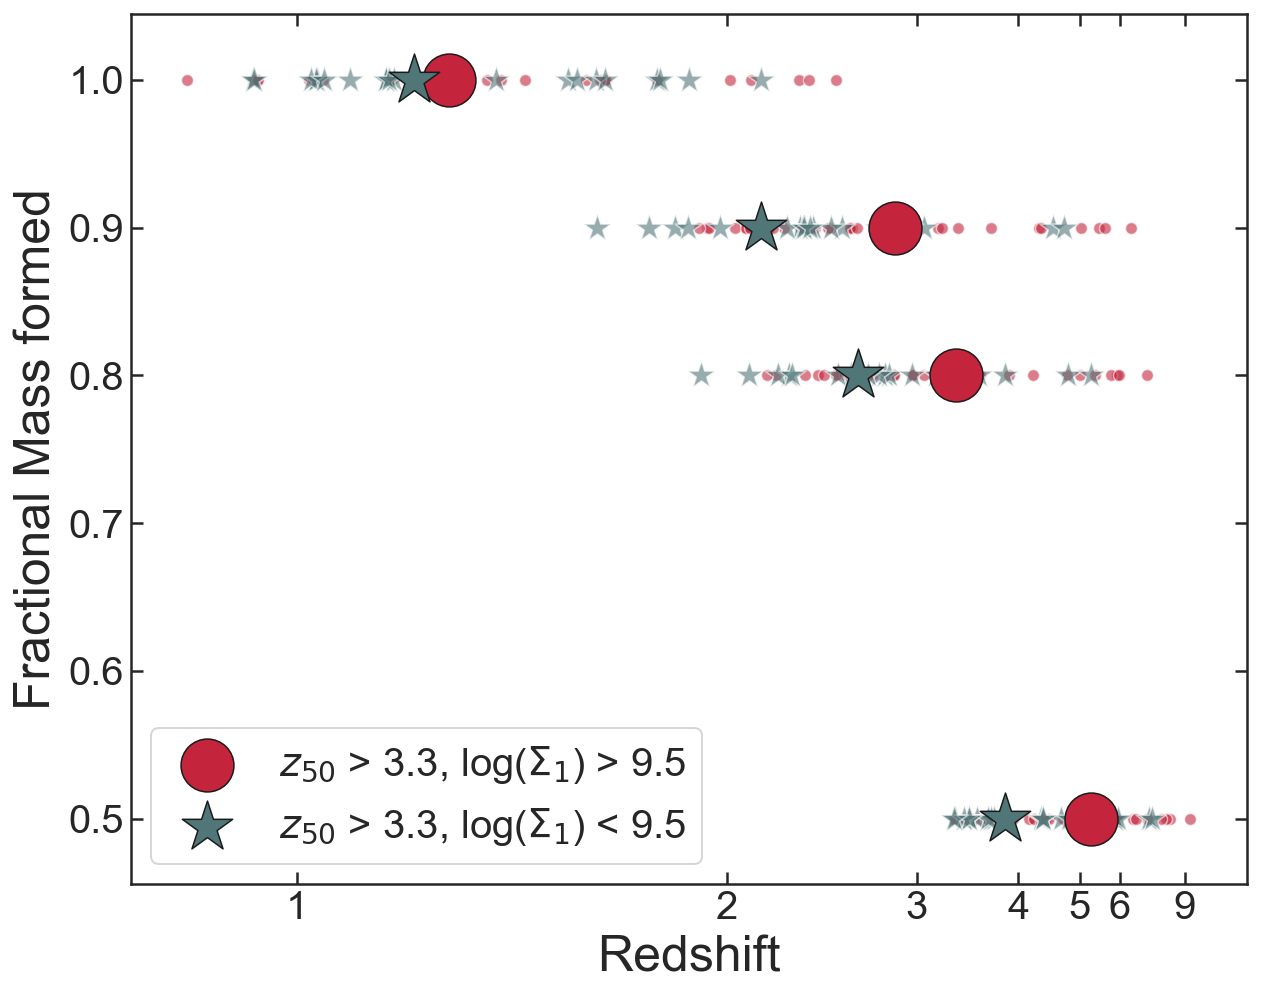

In [10]:
plt.figure(figsize=[10,8])
ax2=plt.subplot()

for i in mdbq1.index:
    sea.scatterplot(np.array([mdbq1.t_50[i], mdbq1.t_80[i], mdbq1.t_90[i],0]) + cosmo.lookback_time(mdbq1.zgrism[i]).value,  [0.5,0.8,0.9,1],
                    legend=False, color = '#C4253C', ax=ax2, marker = 'o', alpha = 0.6)

for i in mdbq2.index:
    sea.scatterplot(np.array([mdbq2.t_50[i], mdbq2.t_80[i], mdbq2.t_90[i],0]) + cosmo.lookback_time(mdbq2.zgrism[i]).value,  [0.5,0.8,0.9,1],
                    legend=False, color = '#507678', ax=ax2, marker = '*',s=200, alpha = 0.6)

sea.scatterplot([np.median(mdbq1.t_50), np.median(mdbq1.t_80), np.median(mdbq1.t_90), 0] + np.median(cosmo.lookback_time(mdbq1.zgrism).value),  [0.5,0.8,0.9,1],
                    legend=False, color = '#C4253C', ax=ax2, marker = 'o', label = '$z_{50}$ > 3.3, log($\Sigma_1$) > 9.5',s=700, edgecolor='k')

sea.scatterplot([np.median(mdbq2.t_50), np.median(mdbq2.t_80), np.median(mdbq2.t_90), 0] + np.median(cosmo.lookback_time(mdbq2.zgrism).value),  [0.5,0.8,0.9,1],
                    legend=False, color = '#507678', ax=ax2, marker = '*', label = '$z_{50}$ > 3.3, log($\Sigma_1$) < 9.5',s=700, edgecolor='k')
ax2.set_xticks(cosmo.lookback_time([1,2,3,4,5,6,9]).value)
ax2.set_xticklabels([1,2,3,4,5,6,9])
ax2.minorticks_off()
plt.ylabel('Fractional Mass formed', fontsize=25)
plt.xlabel('Redshift', fontsize=25)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.legend(fontsize=20, loc = 3)

In [27]:
cosmo.lookback_time([2,3,4,5,6,7,8])

<Quantity [10.51184138, 11.64736955, 12.25492553, 12.62271215, 12.8647405 ,
           13.03383914, 13.15741494] Gyr>

([<matplotlib.axis.XTick at 0x1a90ed7668>,
 <a list of 5 Text xticklabel objects>)

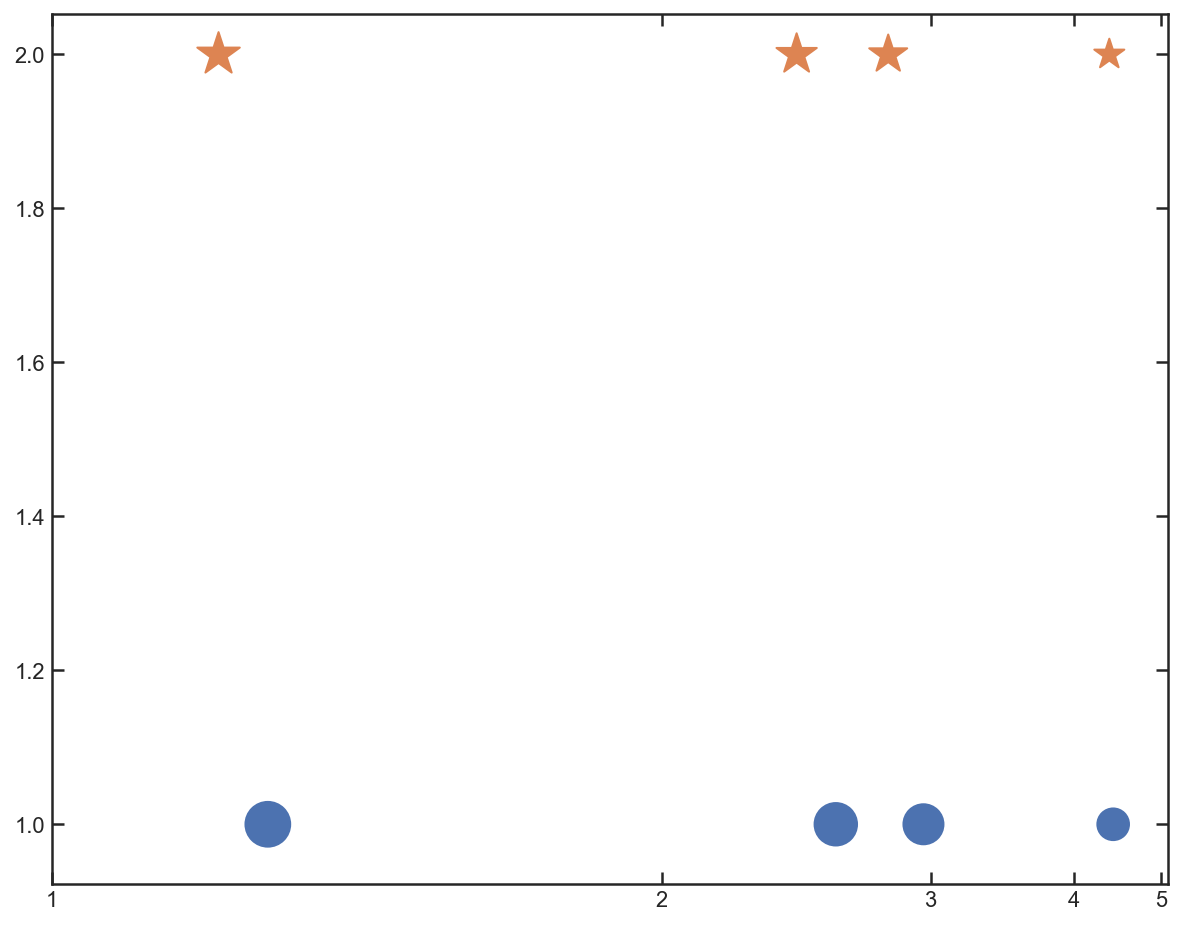

In [106]:
plt.figure(figsize=[10,8])
ax1=plt.subplot()
plt.scatter(cosmo.lookback_time([np.median(mdbq1.zgrism),np.median(mdbq1.z_90), np.median(mdbq1.z_80), np.median(mdbq1.z_50)]),[1,1,1,1], marker = 'o',s=[500,450,400,250])
plt.scatter(cosmo.lookback_time([np.median(mdbq2.zgrism),np.median(mdbq2.z_90), np.median(mdbq2.z_80), np.median(mdbq2.z_50)]),[2,2,2,2], marker = '*',s=[500,450,400,250])
# plt.scatter(cosmo.lookback_time([np.median(mdbq3.zgrism),np.median(mdbq3.z_90), np.median(mdbq3.z_80), np.median(mdbq3.z_50)]),[3,3,3,3], marker = 's',s=[500,450,400,250])
# plt.scatter(cosmo.lookback_time([np.median(mdbq4.zgrism),np.median(mdbq4.z_90), np.median(mdbq4.z_80), np.median(mdbq4.z_50)]),[4,4,4,4], marker = '^',s=[500,450,400,250])
plt.xticks(cosmo.lookback_time([1,2,3,4,5]).value, [1,2,3,4,5])

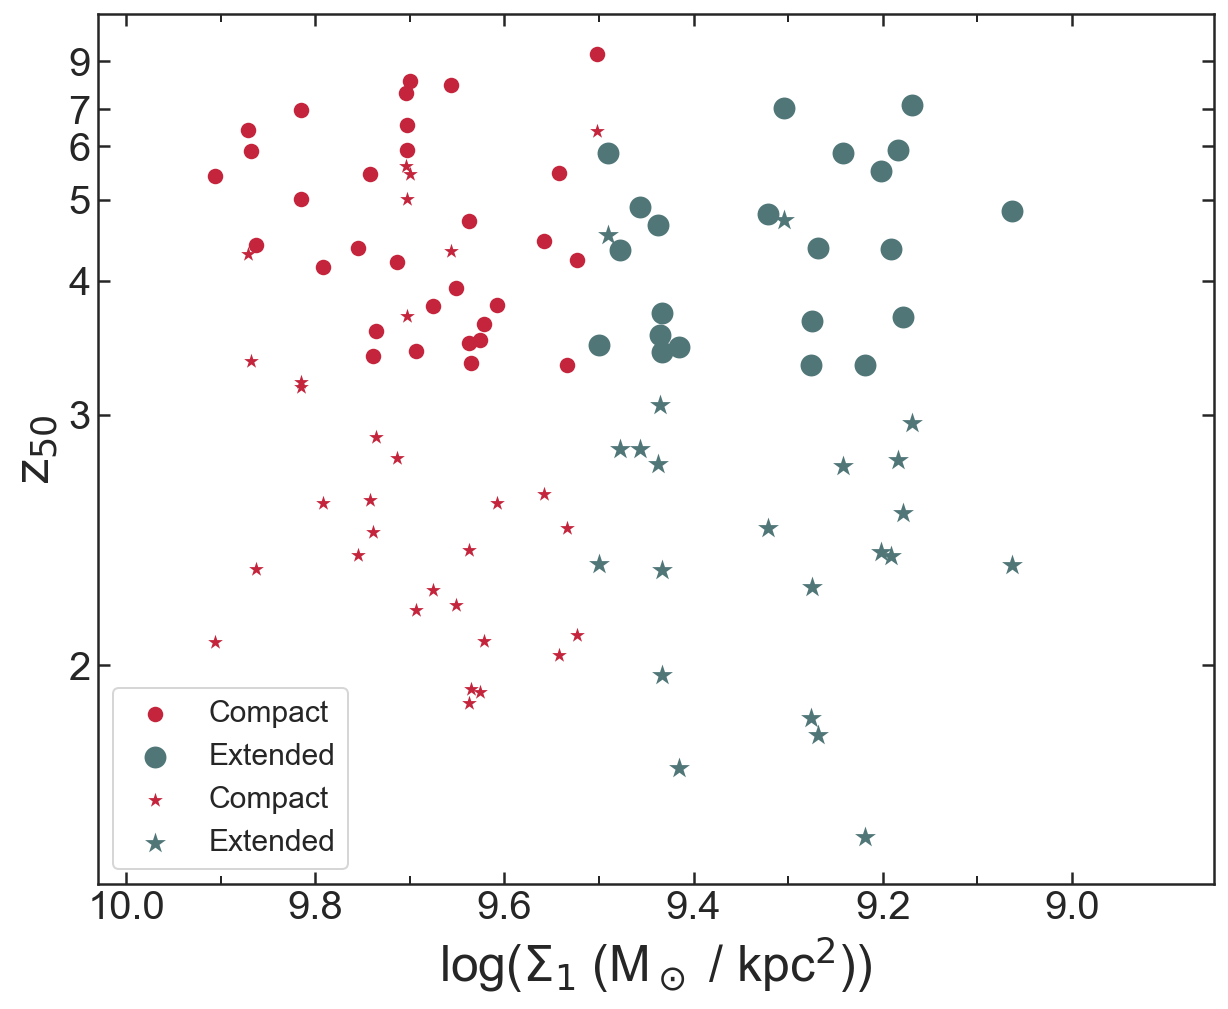

In [40]:
plt.figure(figsize=[10,8])
ax1=plt.subplot()
sea.scatterplot(np.log10(mdbq1.Sigma1) , 
                cosmo.lookback_time(mdbq1.z_50),  linewidth = 0,legend=False,
                sizes=(20, 200), ax=ax1, color = '#C4253C', s = 60, marker = 'o', label = 'Compact')

sea.scatterplot(np.log10(mdbq2.Sigma1), 
                cosmo.lookback_time(mdbq2.z_50),  linewidth = 0,legend=False,
                sizes=(20, 200), ax=ax1, color = '#507678', s = 120, marker = 'o', label = 'Extended')

sea.scatterplot(np.log10(mdbq1.Sigma1) , 
                cosmo.lookback_time(mdbq1.z_90),  linewidth = 0,legend=False,
                sizes=(20, 200), ax=ax1, color = '#C4253C', s = 60, marker = '*', label = 'Compact')

sea.scatterplot(np.log10(mdbq2.Sigma1), 
                cosmo.lookback_time(mdbq2.z_90),  linewidth = 0,legend=False,
                sizes=(20, 200), ax=ax1, color = '#507678', s = 120, marker = '*', label = 'Extended')

ax1.set_yticks(cosmo.lookback_time([2,3,4,5,6,7,9]).value)
ax1.set_yticklabels([2,3,4,5,6,7,9])
ax1.minorticks_off()
# plt.errorbar([10,10,10],cosmo.lookback_time([2,4,6.5]).value, yerr=z5_errbin_hs, fmt = 'o',ms=5, color = '#C4253C' , ecolor = 'k')
# plt.errorbar([8.88,8.88,8.88],cosmo.lookback_time([2,4,6.5]).value, yerr=z5_errbin_ls, fmt = '*',ms=7,color = '#507678', ecolor = 'k')

ax1.set_xticks([ 9.9, 9.7, 9.5, 9.3, 9.1], minor=True)
plt.xlim(10.03,8.85)
plt.xlabel('log($\Sigma_1$ (M$_\odot$ / kpc$^2$))', fontsize=25)
plt.ylabel('z$_{50}$', fontsize=25)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.legend(fontsize=15, loc = 3)

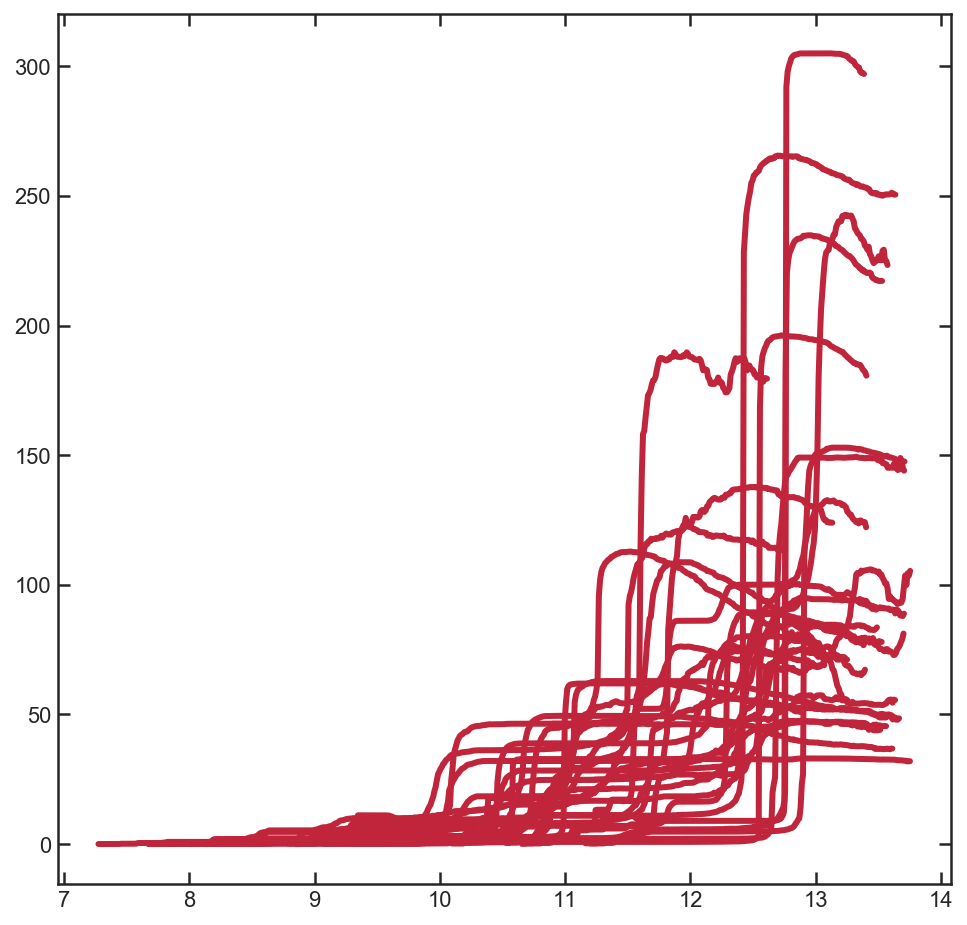

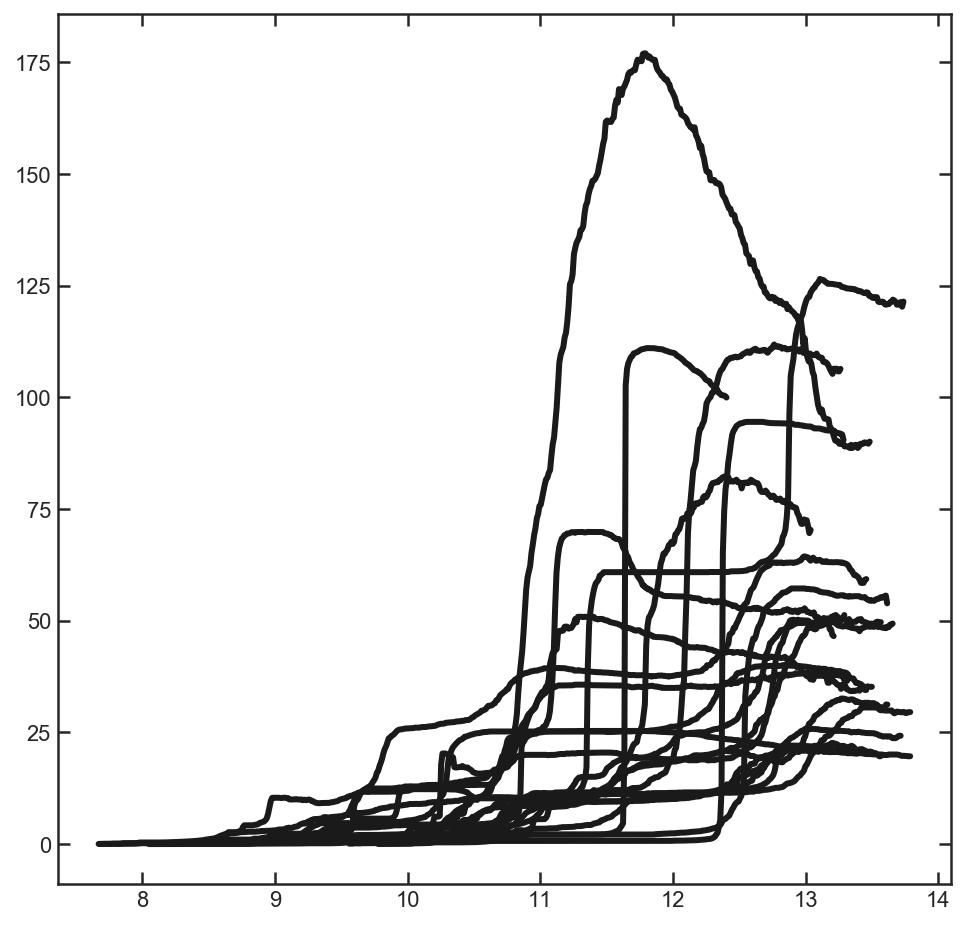

In [7]:
plt.figure(figsize =[8,8])
LBT_q1 = []
SFH_q1 = []
for i in mdbq1.index:
    lbt, sfh = np.load('../data/SFH/{0}_{1}.npy'.format(mdbq1.field[i], mdbq1.id[i]))
    plt.plot(lbt + cosmo.lookback_time(mdbq1.zgrism[i]).value, sfh, color = '#C1253C', linewidth = 3, zorder = 9)  
    
    LBT_q1.append(lbt+ cosmo.lookback_time(mdbq1.zgrism[i]).value)
    SFH_q1.append(sfh)
    
plt.figure(figsize =[8,8])
LBT_q2 = []
SFH_q2 = []
for i in mdbq2.index:
    lbt, sfh = np.load('../data/SFH/{0}_{1}.npy'.format(mdbq2.field[i], mdbq2.id[i]))
    plt.plot(lbt + cosmo.lookback_time(mdbq2.zgrism[i]).value, sfh, color = 'k', linewidth = 3, zorder = 9)  
    
    LBT_q2.append(lbt+ cosmo.lookback_time(mdbq2.zgrism[i]).value)
    SFH_q2.append(sfh)

In [16]:
def Stack_SFH(lbt, sfh):
    sfhgrid = np.transpose(sfh)
    ################
    stack = np.zeros(len(lbt))
    for i in range(len(lbt)):
        weights = len(sfhgrid[i][sfhgrid[i] > 0])
        stack[i] = np.mean(sfhgrid[i])        

    return stack

In [17]:
LBT = np.linspace(7,14,7000)
SFH_q1grid = np.zeros([len(LBT_q1), len(LBT)])
SFH_q2grid = np.zeros([len(LBT_q2), len(LBT)])

for i in range(len(LBT_q1)):
    SFH_q1grid[i] = interp1d(LBT_q1[i], SFH_q1[i], fill_value=0, bounds_error=False)(LBT)

sfh_stack_q1 = Stack_SFH(LBT, SFH_q1grid)

for i in range(len(LBT_q2)):
    SFH_q2grid[i] = interp1d(LBT_q2[i], SFH_q2[i], fill_value=0, bounds_error=False)(LBT)

sfh_stack_q2 = Stack_SFH(LBT, SFH_q2grid)

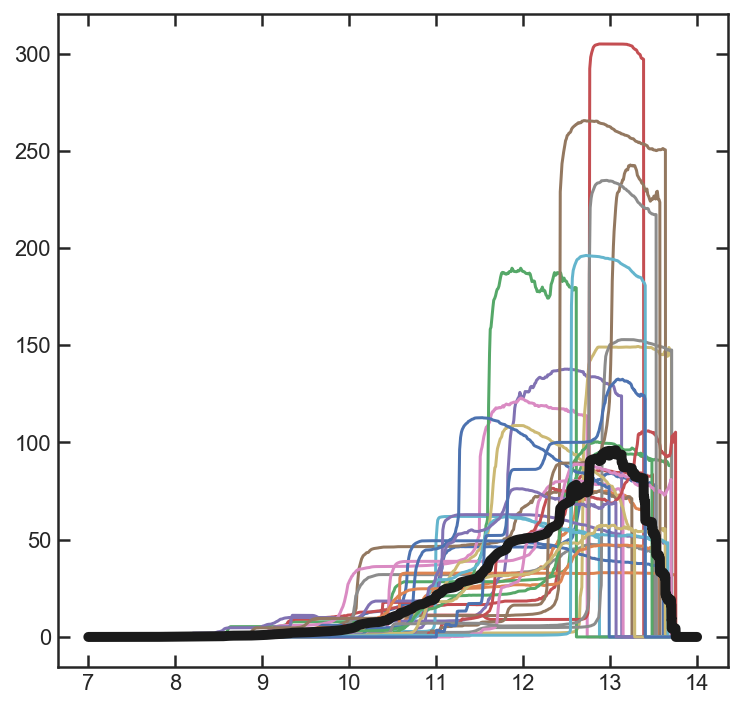

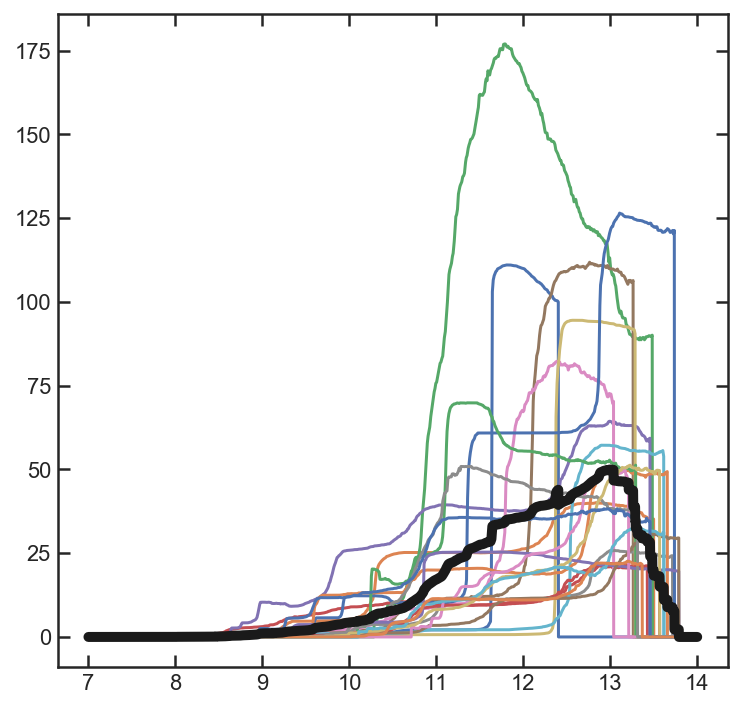

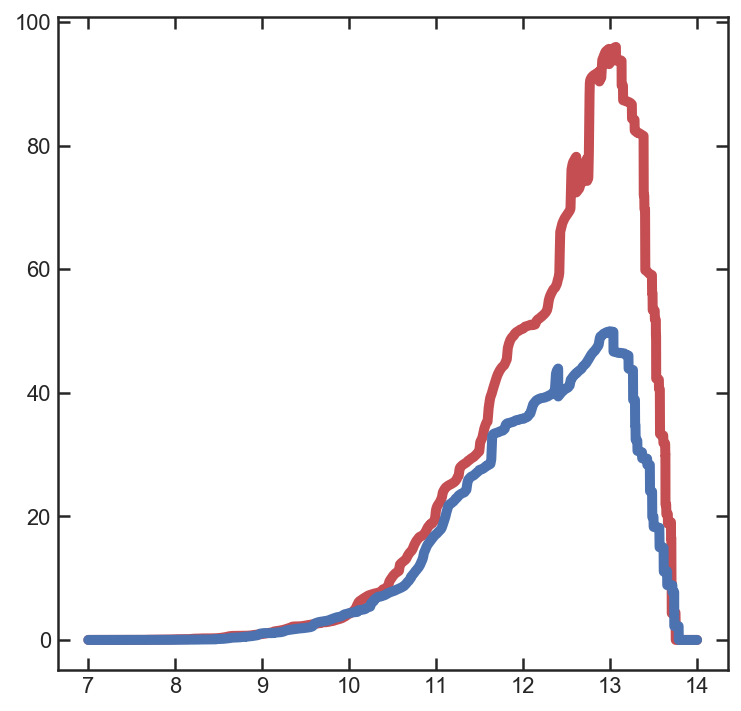

In [18]:
plt.figure(figsize=[6,6])
plt.plot(LBT, SFH_q1grid.T)
plt.plot(LBT, sfh_stack_q1, 'k', linewidth = 5)

plt.figure(figsize=[6,6])
plt.plot(LBT, SFH_q2grid.T)
plt.plot(LBT, sfh_stack_q2, 'k', linewidth = 5)

plt.figure(figsize=[6,6])
plt.plot(LBT, sfh_stack_q1, 'r', linewidth = 5)
plt.plot(LBT, sfh_stack_q2, 'b', linewidth = 5)

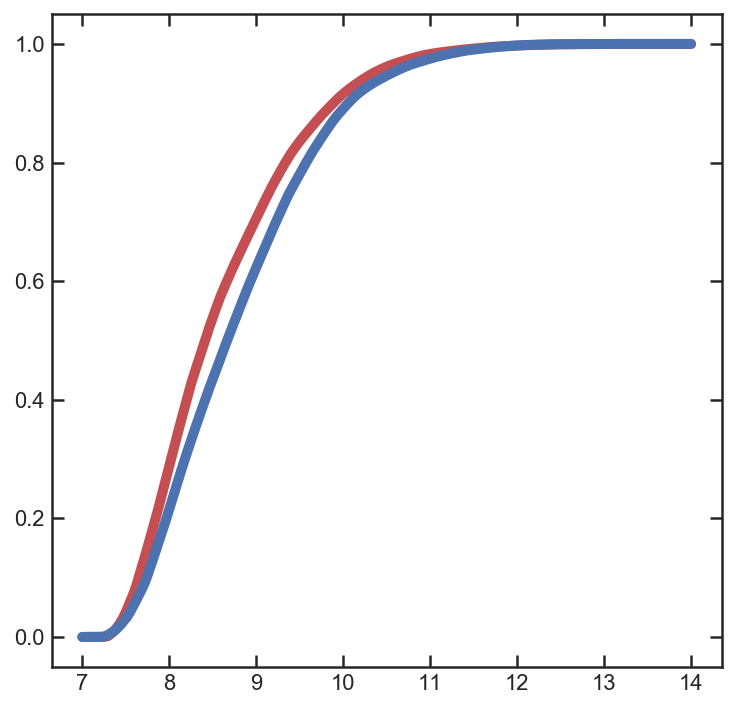

In [19]:
plt.figure(figsize=[6,6])
plt.plot(LBT, np.cumsum(sfh_stack_q1[::-1]) / max(np.cumsum(sfh_stack_q1[::-1])), 'r', linewidth = 5)
plt.plot(LBT, np.cumsum(sfh_stack_q2[::-1]) / max(np.cumsum(sfh_stack_q2[::-1])), 'b', linewidth = 5)

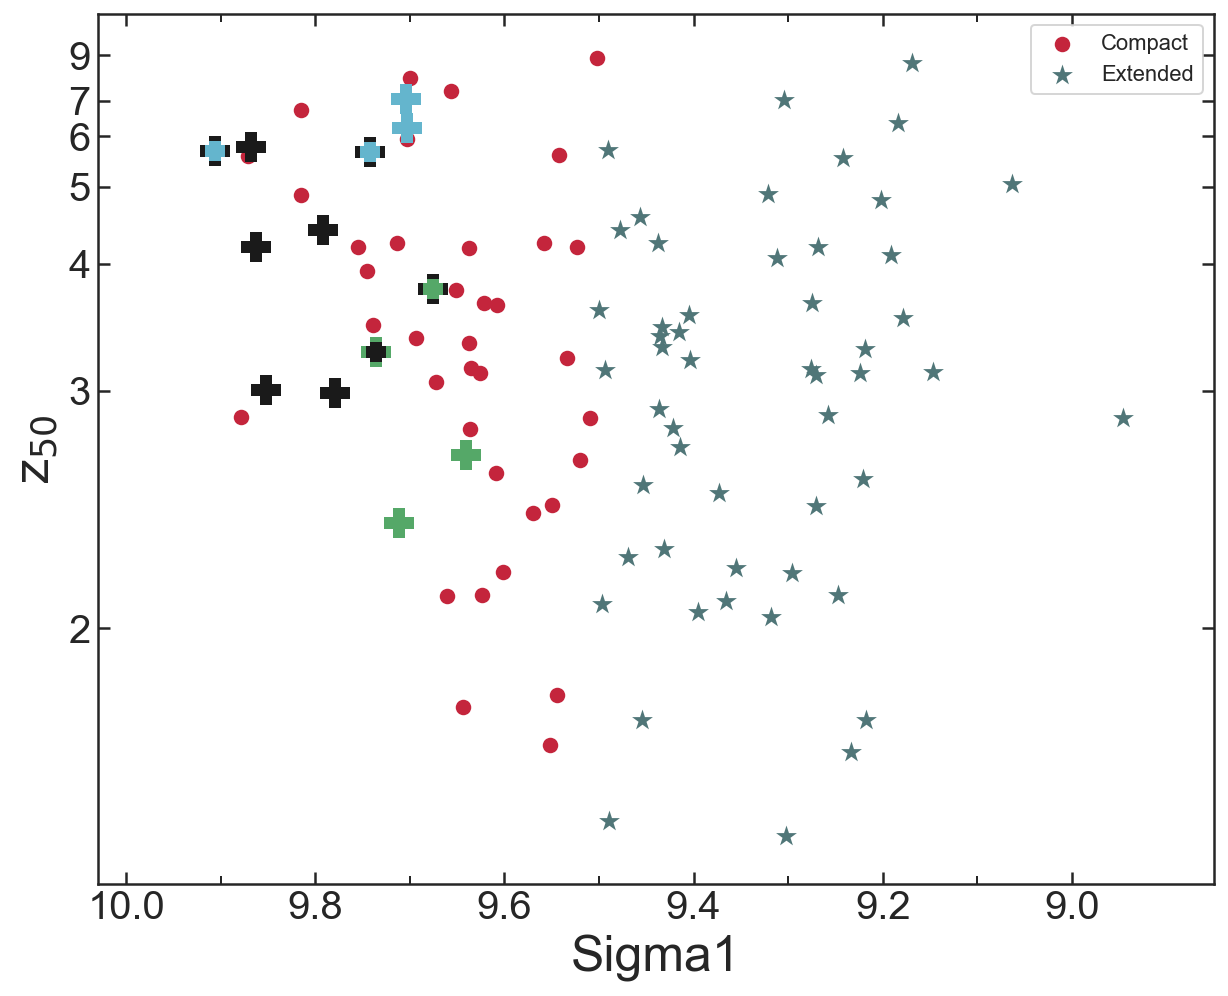

In [429]:
gs = gridspec.GridSpec(2,2,width_ratios=[2,1],hspace=0.02,wspace=0.01)

plt.figure(figsize=[10,8])
ax1=plt.subplot()
sea.scatterplot(np.log10(mdb.query('Sigma1 > 10**9.5').Sigma1) , 
                cosmo.lookback_time(mdb.query('Sigma1 > 10**9.5').z_50),  linewidth = 0,legend=False,
                sizes=(20, 200), ax=ax1, color = '#C4253C', s = 60, marker = 'o', label = 'Compact')

sea.scatterplot(np.log10(mdb.query('Sigma1 < 10**9.5').Sigma1), 
                cosmo.lookback_time(mdb.query('Sigma1 < 10**9.5').z_50),  linewidth = 0,legend=False,
                sizes=(20, 200), ax=ax1, color = '#507678', s = 120, marker = '*', label = 'Extended')

ax1.set_yticks(cosmo.lookback_time([2,3,4,5,6,7,9]).value)
ax1.set_yticklabels([2,3,4,5,6,7,9])
ax1.minorticks_off()
# plt.errorbar([10,10,10],cosmo.lookback_time([2,4,6.5]).value, yerr=z5_errbin_hs, fmt = 'o',ms=5, color = '#C4253C' , ecolor = 'k')
# plt.errorbar([8.88,8.88,8.88],cosmo.lookback_time([2,4,6.5]).value, yerr=z5_errbin_ls, fmt = '*',ms=7,color = '#507678', ecolor = 'k')

ax1.set_xticks([ 9.9, 9.7, 9.5, 9.3, 9.1], minor=True)
plt.xlim(10.03,8.85)
plt.xlabel('log($\Sigma_1$ (M$_\odot$ / kpc$^2$))', fontsize=25)
plt.ylabel('z$_{50}$', fontsize=25)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.legend(fontsize=15, loc = 3)
# sea.scatterplot(np.log10(mdb.query('lmass >= 11 and Re < 2 and B > 11').Sigma1), cosmo.lookback_time(mdb.query('lmass >= 11 and Re < 2 and B > 11').z_50),
#                 marker="+", color = 'k', alpha = 1, linewidth = 15)

# sea.scatterplot(np.log10(mdb.query('lmass >= 11 and Re < 2 and B < 11').Sigma1), cosmo.lookback_time(mdb.query('lmass >= 11 and Re < 2 and B < 11').z_50),
#                 marker="+", color = 'c', alpha = 1, linewidth = 15)

ids = mdb.query('lmass >= 11 and Re < 2').id.values
track = ['ls','ef','ef','ef','ef','ls','ef','ls','ef','ef','ef','gt','gt']
cols= ['g','k','k','k','k','g','k','g','k','k','k','c','c']

for i in range(len(ids)):
    sea.scatterplot(np.log10(mdb.query('id == {0}'.format(ids[i])).Sigma1), cosmo.lookback_time(mdb.query('id == {0}'.format(ids[i])).z_50),
                marker="+", color = cols[i], alpha = 1, linewidth = 15)
    
    
ids = [22213,37686,17746, 37340]
# track = ['ls','ef','ef','ef','ls','ls','ef','ls','ef','ef','ef','gt','gt']
cols= ['c','k','c','g']

for i in range(len(ids)):
    sea.scatterplot(np.log10(mdb.query('id == {0}'.format(ids[i])).Sigma1), cosmo.lookback_time(mdb.query('id == {0}'.format(ids[i])).z_50),
                marker="+", color = cols[i], alpha = 1, linewidth = 10)

In [430]:
len(mdb.query('lmass >= 11 and Re < 2').id.values)

13

[Text(0,0,'2'),
 Text(0,0,'3'),
 Text(0,0,'4'),
 Text(0,0,'5'),
 Text(0,0,'6'),
 Text(0,0,'7'),
 Text(0,0,'9')]

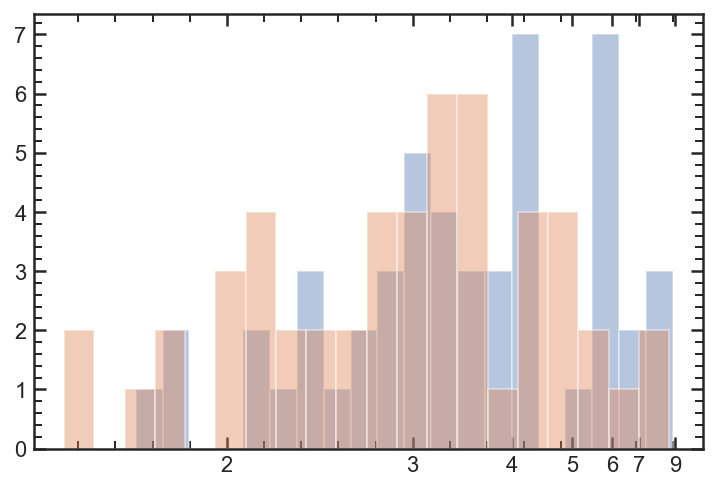

In [30]:
ax1 = plt.subplot()
sea.distplot(cosmo.lookback_time(mdb.query('Sigma1 > 10**9.5').z_50), kde = False, bins=20, ax =ax1)
sea.distplot(cosmo.lookback_time(mdb.query('Sigma1 < 10**9.5').z_50), kde = False, bins=20, ax =ax1)
ax1.set_xticks(cosmo.lookback_time([2,3,4,5,6,7,9]).value)
ax1.set_xticklabels([2,3,4,5,6,7,9])

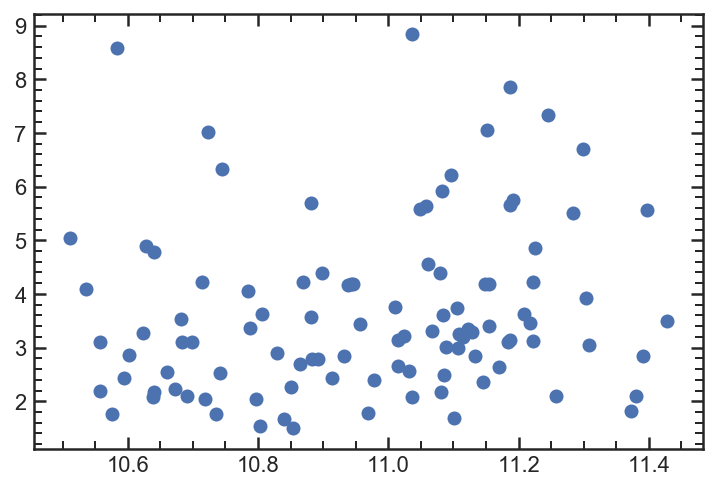

In [41]:
plt.scatter(mdb.lmass.values, mdb.z_50.values)

In [22]:
def Roll_seg(X,Y,seg_limit,bin_size):
    Y = Y[np.argsort(X)]
    X = X[np.argsort(X)]
    
    X_med = [] ; X_mean = [] ; binned_ratio = [] 

    i=0
    low_lim = X[i]
    while low_lim < max(X):
        try:
            IDX = [U for U in range(len(X)) if low_lim <= X[U] < low_lim + bin_size]


            low = 0
            high = 0
            for U in Y[IDX]:
                if U <= seg_limit:
                    low +=1
                else:
                    high +=1

            binned_ratio.append(high / low) 
            X_med.append(np.median(X[IDX]))
            X_mean.append(np.median(low_lim + bin_size / 2))
        except:
            pass
        i+=1
        low_lim = X[i]
    return np.array(X_med), np.array(X_mean), np.array(binned_ratio)#, np.array(binned_wmean) , np.array(binned_err)

med, mn, sratio = Roll_seg(mdb.lmass.values, mdb.z_50.values, 3.26, 0.1)


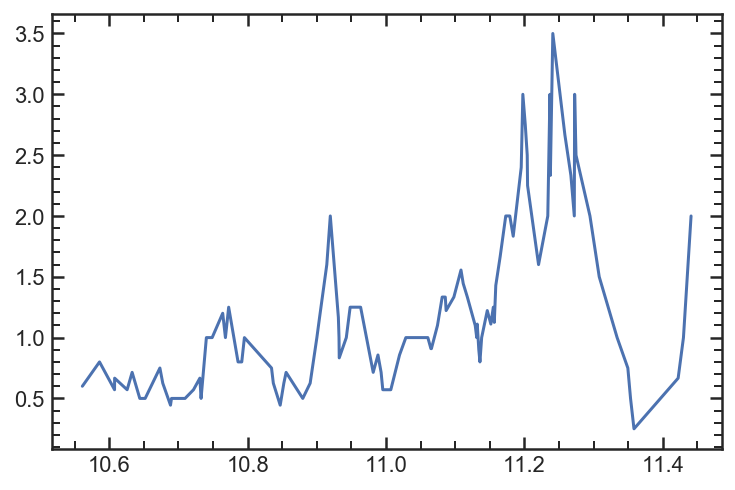

In [51]:
plt.plot(mn,sratio)

/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


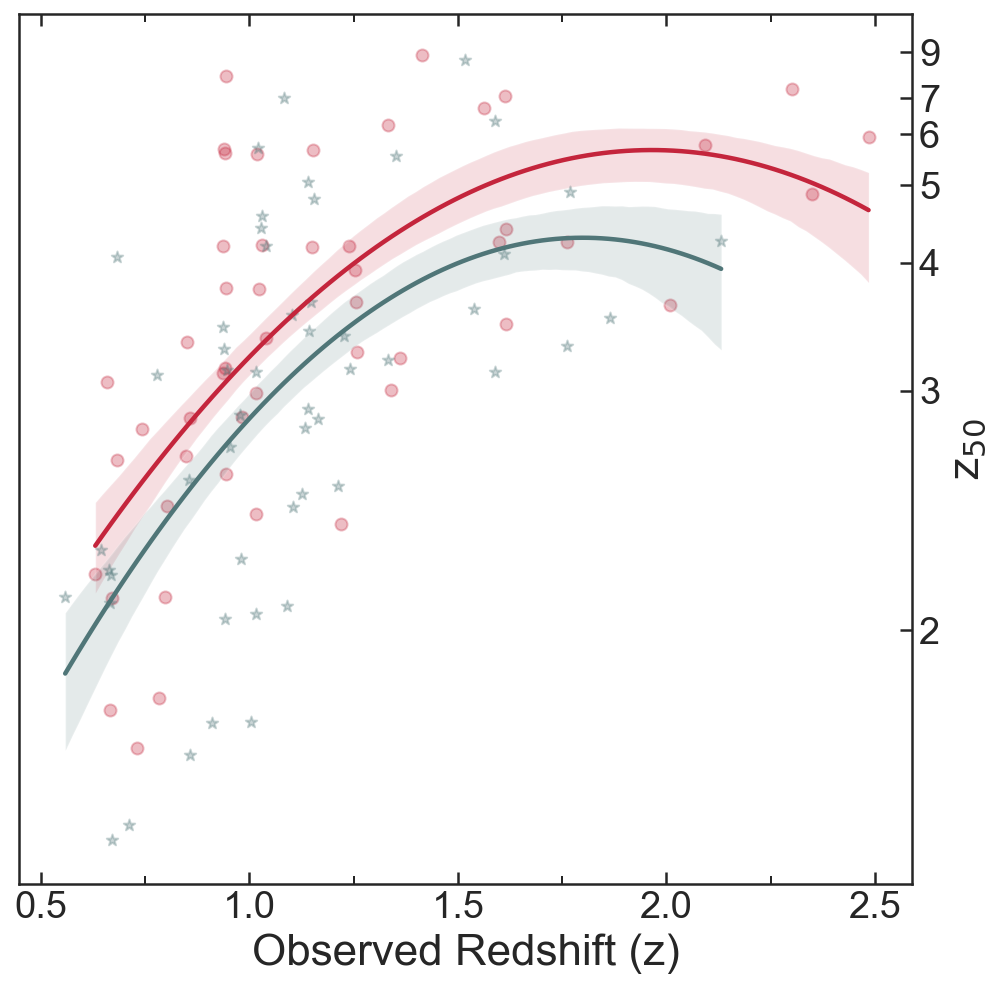

In [77]:
plt.figure(figsize=[8,8])
ax3 = plt.subplot()
Cmdb = mdb.query('Sigma1 > {0}'.format(10**9.5))
Emdb = mdb.query('Sigma1 < {0}'.format(10**9.5))
sea.regplot(Cmdb.zgrism, cosmo.lookback_time(Cmdb.z_50),order=2, 
            color = '#C4253C',truncate=True, ax=ax3, ci = 68, scatter_kws={'alpha':0.3})
sea.regplot(Emdb.zgrism, cosmo.lookback_time(Emdb.z_50),order=2, 
            color = '#507678',truncate=True, ax=ax3, ci = 68, scatter_kws={'alpha':0.3}, marker = '*')
ax3.set_xlabel('Observed Redshift (z)', fontsize=22)
ax3.set_ylabel('z$_{50}$', fontsize=22)

ax3.set_yticks(cosmo.lookback_time([2,3,4,5,6,7,9]).value)
ax3.set_yticklabels([2,3,4,5,6,7,9])
ax3.minorticks_off()
ax3.set_xticks([0.75, 1.25, 1.75, 2.25], minor = True)

ax3.yaxis.set_label_position('right')
ax3.yaxis.set_ticks_position('right')
plt.tick_params(axis='both', which='major', labelsize=19)

(10.0, 8.9)

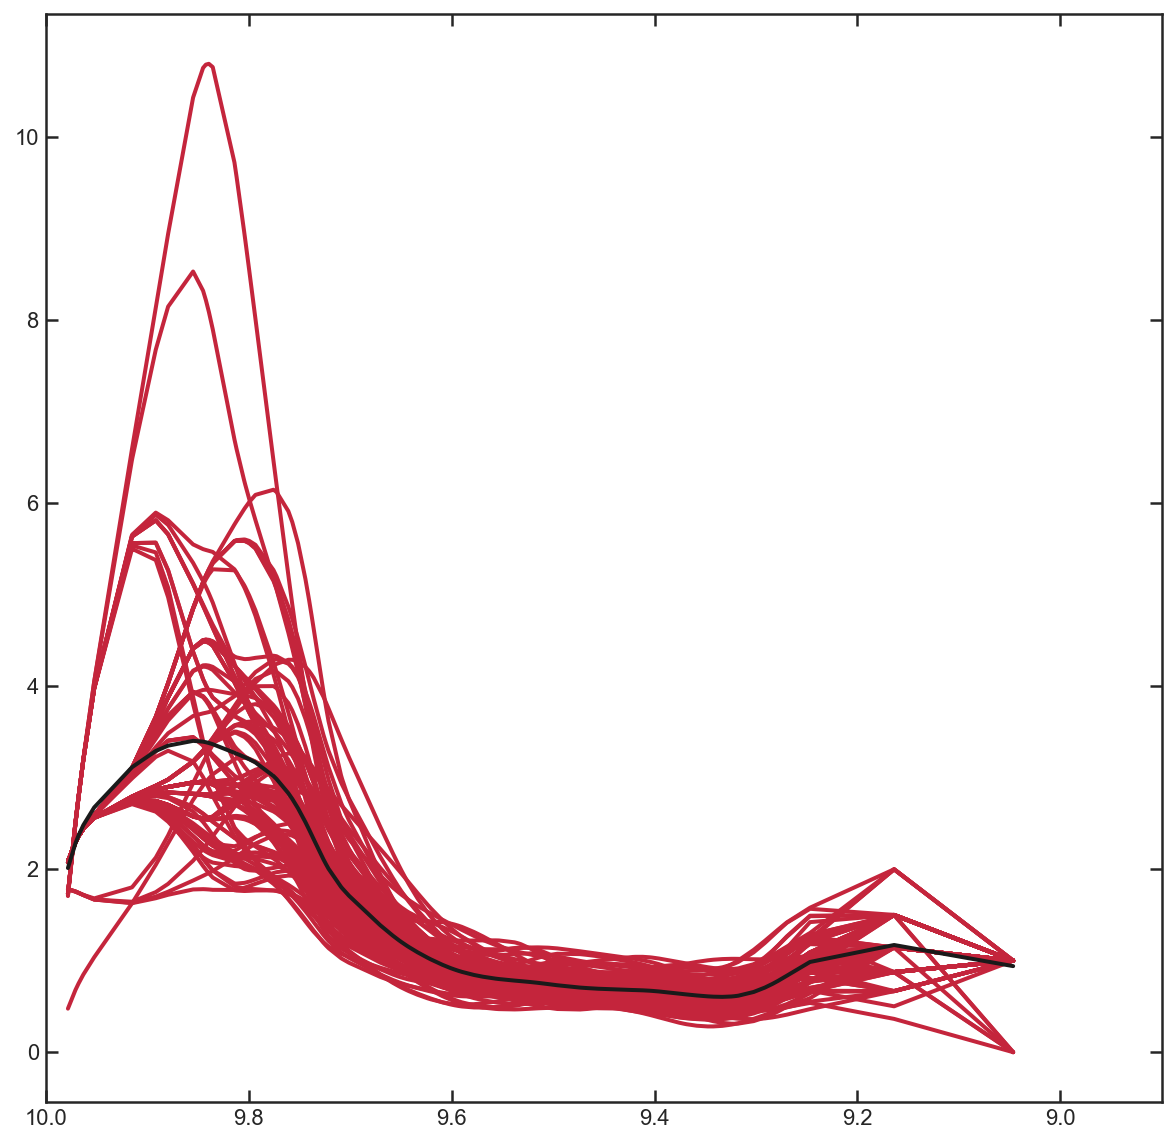

In [17]:
plt.figure(figsize=[10,10])

smgrid = []
idx = 0
while idx < 100:
    try:
        err = []
        z50 = []
        s1 = []
        for i in mdb.index:
            for ii in range(len(mdb.z_50_hci[i])//2):
                if mdb.z_50_hci[i][2*ii] <= mdb.z_50[i] <= mdb.z_50_hci[i][2*ii+1]:
                    err.append((cosmo.lookback_time(mdb.z_50_hci[i][2*ii+1]).value - cosmo.lookback_time(mdb.z_50_hci[i][2*ii]).value)/2)  



                    z50.append(np.random.normal(cosmo.lookback_time(mdb.z_50[i]).value, 
                                                (cosmo.lookback_time(mdb.z_50_hci[i][2*ii+1]).value - cosmo.lookback_time(mdb.z_50_hci[i][2*ii]).value)/2))
                    s1.append(np.log10(mdb.Sigma1[i]))        




        med, mn, sratio = Roll_seg(np.array(s1), np.array(z50), cosmo.lookback_time(3.26).value, 0.2)

        # plt.plot(mn, sratio)
        plt.plot(mn,Smooth(mn,sratio,0.03), linewidth=2, color='#C4253C', label = 'High Confidence fit')
        smgrid.append(Smooth(mn,sratio,0.03))

        idx +=1
    except:
        pass
plt.plot(mn,np.mean(smgrid, axis = 0), linewidth=2, color='k', label = 'High Confidence fit')
plt.xlim(10.,8.9)


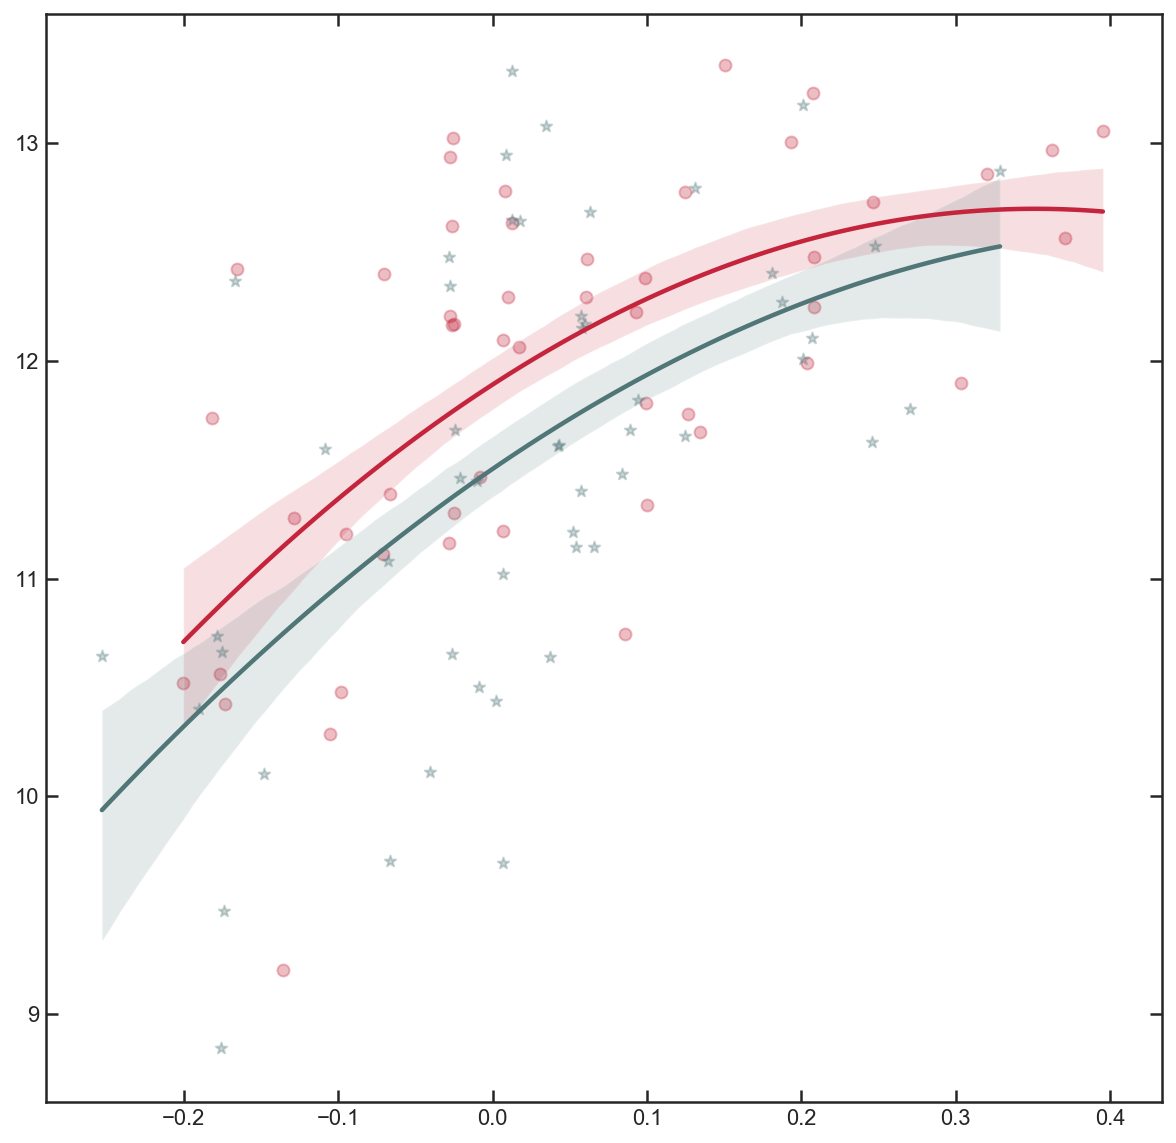

In [30]:
plt.figure(figsize=[10,10])

# smgrid = []
# idx = 0
# while idx < 100:
#     try:
err = []
z50 = []
zg = []
for i in mdb.query('Sigma1 > 10**9.5').index:
    for ii in range(len(mdb.z_50_hci[i])//2):
        if mdb.z_50_hci[i][2*ii] <= mdb.z_50[i] <= mdb.z_50_hci[i][2*ii+1]:
            err.append((cosmo.lookback_time(mdb.z_50_hci[i][2*ii+1]).value - cosmo.lookback_time(mdb.z_50_hci[i][2*ii]).value)/2)  



            z50.append(np.random.normal(cosmo.lookback_time(mdb.z_50[i]).value, 
                                        (cosmo.lookback_time(mdb.z_50_hci[i][2*ii+1]).value - cosmo.lookback_time(mdb.z_50_hci[i][2*ii]).value)/2))
            zg.append(np.log10(mdb.zgrism[i]))        
sea.regplot(zg, z50,order=2,color = '#C4253C',truncate=True, ci = 68, scatter_kws={'alpha':0.3})

err = []
z50 = []
zg = []

for i in mdb.query('Sigma1 < 10**9.5').index:
    for ii in range(len(mdb.z_50_hci[i])//2):
        if mdb.z_50_hci[i][2*ii] <= mdb.z_50[i] <= mdb.z_50_hci[i][2*ii+1]:
            err.append((cosmo.lookback_time(mdb.z_50_hci[i][2*ii+1]).value - cosmo.lookback_time(mdb.z_50_hci[i][2*ii]).value)/2)  



            z50.append(np.random.normal(cosmo.lookback_time(mdb.z_50[i]).value, 
                                        (cosmo.lookback_time(mdb.z_50_hci[i][2*ii+1]).value - cosmo.lookback_time(mdb.z_50_hci[i][2*ii]).value)/2))


            zg.append(np.log10(mdb.zgrism[i]))        

sea.regplot(zg, z50,order=2,color = '#507678',truncate=True, ci = 68, scatter_kws={'alpha':0.3}, marker = '*')

# idx +=1
#     except:
#         pass
# plt.plot(mn,np.mean(smgrid, axis = 0), linewidth=2, color='k', label = 'High Confidence fit')
# plt.xlim(10.,8.9)


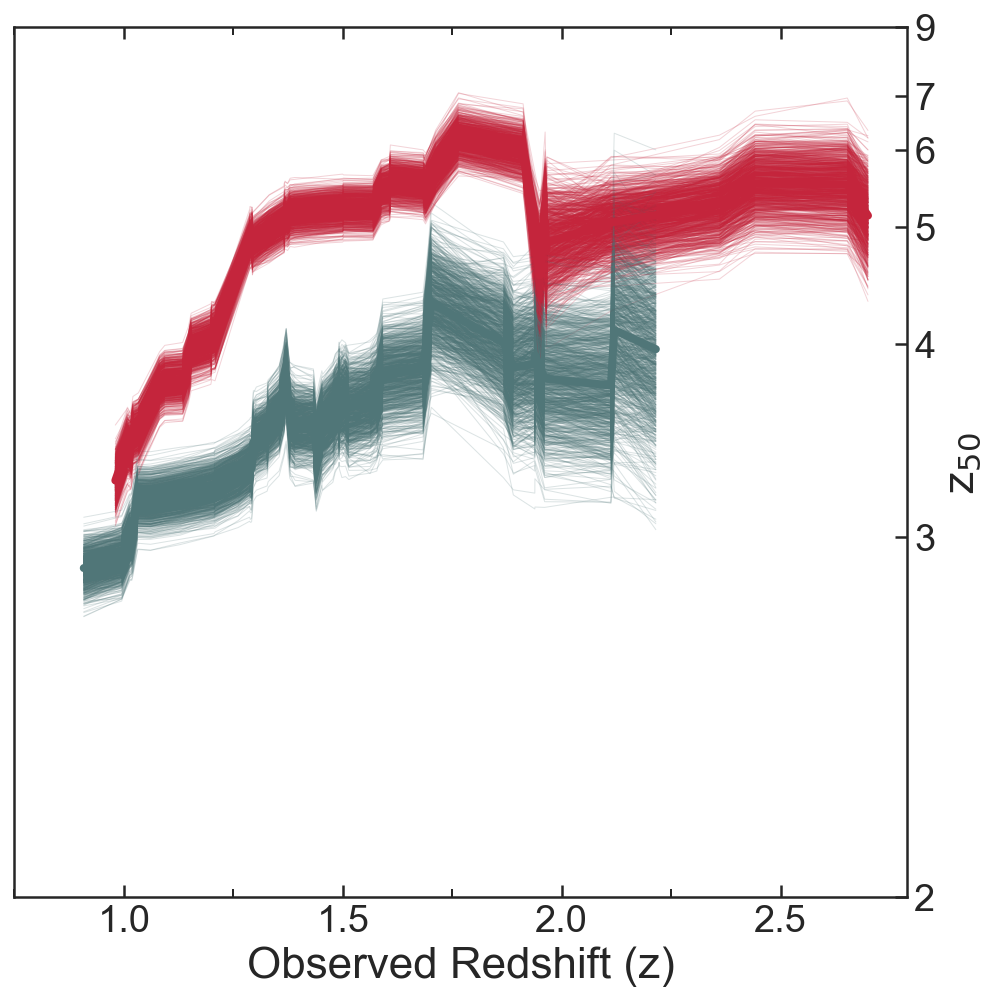

In [90]:
plt.figure(figsize=[8,8])
ax3 = plt.subplot()

z50grid_lz = []
z50grid_hz = []

for U in range(1000):

    err_hz = []
    z50_hz = []
    zg_hz = []
    for i in mdb.query('Sigma1 > 10**9.5').index:
        for ii in range(len(mdb.z_50_hci[i])//2):
            if mdb.z_50_hci[i][2*ii] <= mdb.z_50[i] <= mdb.z_50_hci[i][2*ii+1]:
                z50_hz.append(np.random.normal(cosmo.lookback_time(mdb.z_50[i]).value, 
                                            (cosmo.lookback_time(mdb.z_50_hci[i][2*ii+1]).value - cosmo.lookback_time(mdb.z_50_hci[i][2*ii]).value)/2))
                err_hz.append((cosmo.lookback_time(mdb.z_50_hci[i][2*ii+1]).value - cosmo.lookback_time(mdb.z_50_hci[i][2*ii]).value)/2)
    #             z50_hz.append(cosmo.lookback_time(mdb.z_50[i]).value)
                zg_hz.append(mdb.zgrism[i])        

    err_lz = []
    z50_lz = []
    zg_lz = []
    for i in mdb.query('Sigma1 < 10**9.5').index:
        for ii in range(len(mdb.z_50_hci[i])//2):
            if mdb.z_50_hci[i][2*ii] <= mdb.z_50[i] <= mdb.z_50_hci[i][2*ii+1]:
                z50_lz.append(np.random.normal(cosmo.lookback_time(mdb.z_50[i]).value, 
                                            (cosmo.lookback_time(mdb.z_50_hci[i][2*ii+1]).value - cosmo.lookback_time(mdb.z_50_hci[i][2*ii]).value)/2))

                err_lz.append((cosmo.lookback_time(mdb.z_50_hci[i][2*ii+1]).value - cosmo.lookback_time(mdb.z_50_hci[i][2*ii]).value)/2)
    #             z50_lz.append(cosmo.lookback_time(mdb.z_50[i]).value)           

                zg_lz.append(mdb.zgrism[i])     

    # plt.scatter(zg_hz, z50_hz, color = '#C4253C')
    # plt.scatter(zg_lz, z50_lz, color = '#507678',marker = '*')

    zmed_hz,zmn_hz, z50med_hz, z50_wmn_hz, z50_err_hz = Roll_bin_stat2(np.array(zg_hz),np.array(z50_hz),np.array(err_hz),0.7)
    plt.plot(zmn_hz, z50_wmn_hz, color = '#C4253C', linewidth = 0.5, alpha = 0.2)
    z50grid_hz.append(z50_wmn_hz)

#     plt.plot(zmn_hz,Smooth(zmn_hz,z50_wmn_hz,0.4), linewidth=4, color='#C4253C')
    # plt.fill_between(zmn_hz,Smooth(zmn_hz,z50_wmn_hz,0.4) - Smooth(zmn_hz,z50_err_hz,0.4),
    #                  Smooth(zmn_hz,z50_wmn_hz,0.4) + Smooth(zmn_hz,z50_err_hz,0.4), color = '#C4253C', alpha = 0.2)

    zmed_lz,zmn_lz, z50med_lz, z50_wmn_lz, z50_err_lz = Roll_bin_stat2(np.array(zg_lz),np.array(z50_lz),np.array(err_lz),0.7)
    plt.plot(zmn_lz, z50_wmn_lz, color = '#507678', linewidth = 0.5, alpha = 0.2)
    z50grid_lz.append(z50_wmn_lz)
    
#     plt.plot(zmn_lz,Smooth(zmn_lz,z50_wmn_lz,0.4), linewidth=4,  color = '#507678')
    # plt.fill_between(zmn_lz,Smooth(zmn_lz,z50_wmn_lz,0.4) - Smooth(zmn_lz,z50_err_lz,0.4),
    #                  Smooth(zmn_lz,z50_wmn_lz,0.4) + Smooth(zmn_lz,z50_err_lz,0.4), color =  '#507678', alpha = 0.2)

    
plt.plot(zmn_hz, np.median(z50grid_hz, axis=0), color = '#C4253C', linewidth = 4)
plt.plot(zmn_lz, np.median(z50grid_lz, axis=0), color = '#507678', linewidth = 4)
    
ax3.set_xlabel('Observed Redshift (z)', fontsize=22)
ax3.set_ylabel('z$_{50}$', fontsize=22)

ax3.set_yticks(cosmo.lookback_time([2,3,4,5,6,7,9]).value)
ax3.set_yticklabels([2,3,4,5,6,7,9])
ax3.minorticks_off()
ax3.set_xticks([0.75, 1.25, 1.75, 2.25], minor = True)

ax3.yaxis.set_label_position('right')
ax3.yaxis.set_ticks_position('right')
plt.tick_params(axis='both', which='major', labelsize=19)

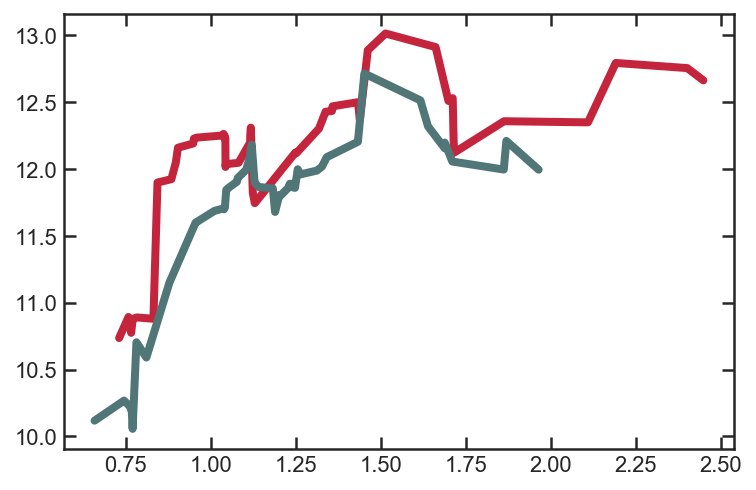

In [84]:
plt.plot(zmn_hz, np.median(z50grid_hz, axis=0), color = '#C4253C', linewidth = 4)
plt.plot(zmn_lz, np.median(z50grid_lz, axis=0), color = '#507678', linewidth = 4)


In [36]:
med, mn, sratio = Roll_seg(np.array(), np.array(z50), cosmo.lookback_time(3.26).value, 0.2)

def Roll_seg(X,Y,seg_limit,bin_size):
    Y = Y[np.argsort(X)]
    X = X[np.argsort(X)]
    
    X_med = [] ; X_mean = [] ; binned_ratio = [] 

    i=0
    low_lim = X[i]
    while low_lim < max(X):
        IDX = [U for U in range(len(X)) if low_lim <= X[U] < low_lim + bin_size]
        X_med.append(np.median(X[IDX]))
        X_mean.append(np.median(low_lim + bin_size / 2))
        
        low = 0
        high = 0
        
        for U in Y[IDX]:
            if U <= seg_limit:
                low +=1
            else:
                high +=1
                
        binned_ratio.append(high / low) 
        i+=1
        low_lim = X[i]
    return np.array(X_med), np.array(X_mean), np.array(binned_ratio)#, np.array(binned_wmean) , np.array(binned_err)

NameError: name 's1' is not defined

(1.0, 9.5)

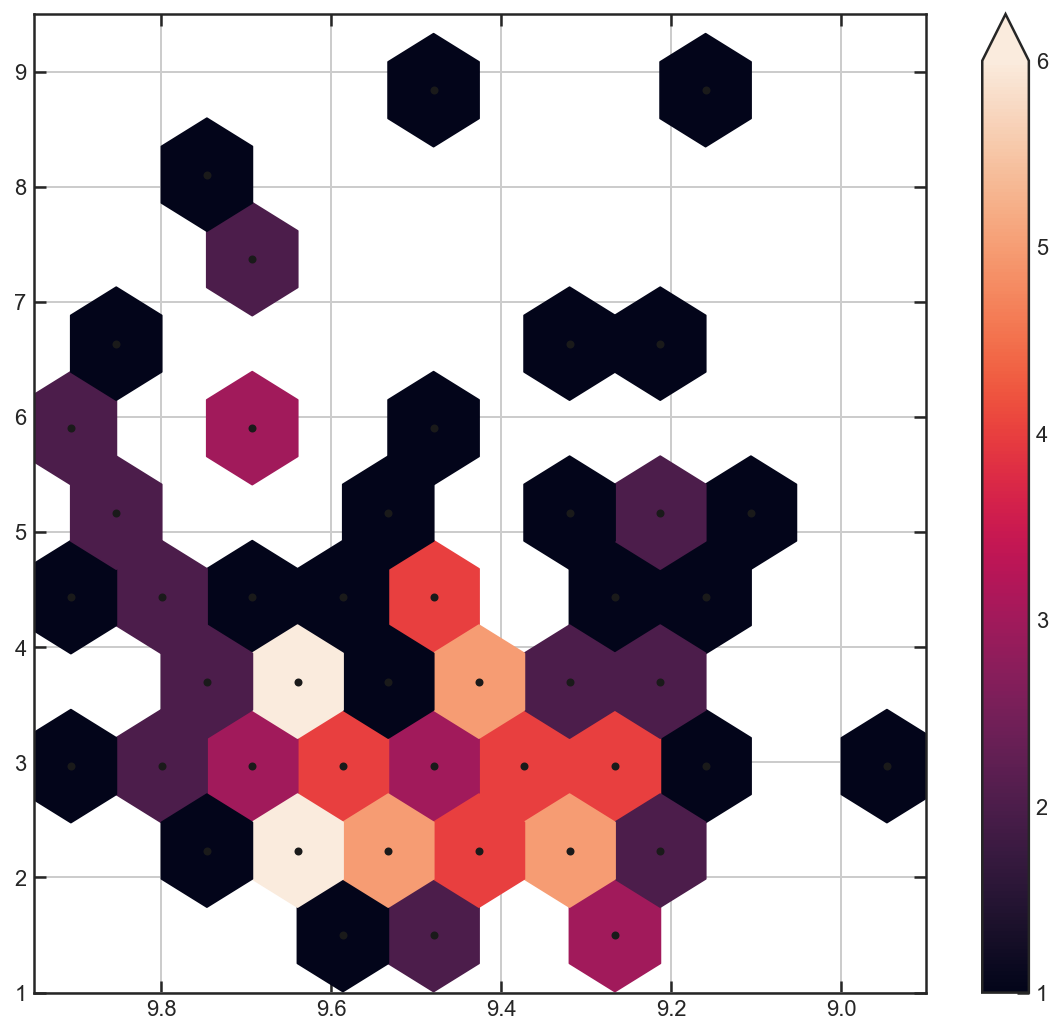

In [252]:
fig=plt.figure(figsize=(10,9))
ax = fig.add_subplot()

xbnds = np.array([min(np.log10(mdb.Sigma1)),max(np.log10(mdb.Sigma1))])
ybnds = np.array([min(mdb.z_50),max(mdb.z_50)])
extent = [xbnds[0],xbnds[1],ybnds[0],ybnds[1]]


# Set gridsize just to make them visually large
image = plt.hexbin(np.log10(mdb.Sigma1),mdb.z_50,gridsize=9,extent=extent,mincnt=1)
# Note that mincnt=1 adds 1 to each count
counts = image.get_array()
ncnts = np.count_nonzero(np.power(10,counts))
verts = image.get_offsets()
for offc in range(verts.shape[0]):
    binx,biny = verts[offc][0],verts[offc][1]
    if counts[offc]:
        plt.plot(binx,biny,'k.',zorder=100)
plt.ylim(ybnds)
plt.grid(True)
cb = plt.colorbar(image,spacing='uniform',extend='max')
plt.xlim(9.95,8.9)
plt.ylim(1.0,9.5)


In [16]:
def Roll_bin_stat(X,Y,bin_size):
    Y = Y[np.argsort(X)]
    X = X[np.argsort(X)]
    
    
    X_med = [] ; X_mean = [] ; binned_median = [] ; binned_mean = [] ; binned_var = []

    i=0
    low_lim = X[i]
    while low_lim < max(X):
        IDX = [U for U in range(len(X)) if low_lim <= X[U] < low_lim + bin_size]
        X_med.append(np.median(X[IDX]))
        X_mean.append(np.median(low_lim + bin_size / 2))
        binned_median.append(np.median(Y[IDX]))
        binned_mean.append(np.mean(Y[IDX]))
        binned_var.append(np.var(Y[IDX]))
        
        i+=1
        low_lim = X[i]
    return np.array(X_med), np.array(X_mean), np.array(binned_median), np.array(binned_mean), np.array(binned_var)

def Roll_bin_stat2(X,Y,E,bin_size):
    W = 1/E ** 2
    Y = Y[np.argsort(X)]
    W = W[np.argsort(X)]
    X = X[np.argsort(X)]
    
    X_med = [] ; X_mean = [] ; binned_median = [] ; binned_wmean = [] ; binned_err = []

    i=0
    low_lim = X[i]
    while low_lim < max(X):
        IDX = [U for U in range(len(X)) if low_lim <= X[U] < low_lim + bin_size]
        X_med.append(np.median(X[IDX]))
        X_mean.append(np.median(low_lim + bin_size / 2))
        binned_median.append(np.median(Y[IDX]))
        binned_wmean.append(np.sum(Y[IDX] * W[IDX]) / (np.sum(W[IDX])))
        binned_err.append(1 / np.sqrt(np.sum(W[IDX])))
        i+=1
        low_lim = X[i]
    return np.array(X_med), np.array(X_mean), np.array(binned_median), np.array(binned_wmean) , np.array(binned_err)

def Roll_seg(X,Y,seg_limit,bin_size):
    Y = Y[np.argsort(X)]
    X = X[np.argsort(X)]
    
    X_med = [] ; X_mean = [] ; binned_ratio = [] #; binned_low = [] ; binned_high = []

    i=0
    low_lim = X[i]
    while low_lim < max(X):
        IDX = [U for U in range(len(X)) if low_lim <= X[U] < low_lim + bin_size]
        X_med.append(np.median(X[IDX]))
        X_mean.append(np.median(low_lim + bin_size / 2))
        
        low = 0
        high = 0
        
        for U in Y[IDX]:
            if U <= seg_limit:
                low +=1
            else:
                high +=1
                
        binned_ratio.append(high / low) 
        i+=1
        low_lim = X[i]
    return np.array(X_med), np.array(X_mean), np.array(binned_ratio)#, np.array(binned_wmean) , np.array(binned_err)


def Smooth(x,f,bw):
    ksmooth = importr('KernSmooth')

    ### select bandwidth
    H = ksmooth.dpik(x)
    
    if bw == 'none':
        bw = H
    
    fx = ksmooth.locpoly(x,f,bandwidth = bw)
    X = np.array(fx[0])
    iFX = np.array(fx[1])
    return interp1d(X,iFX)(x)

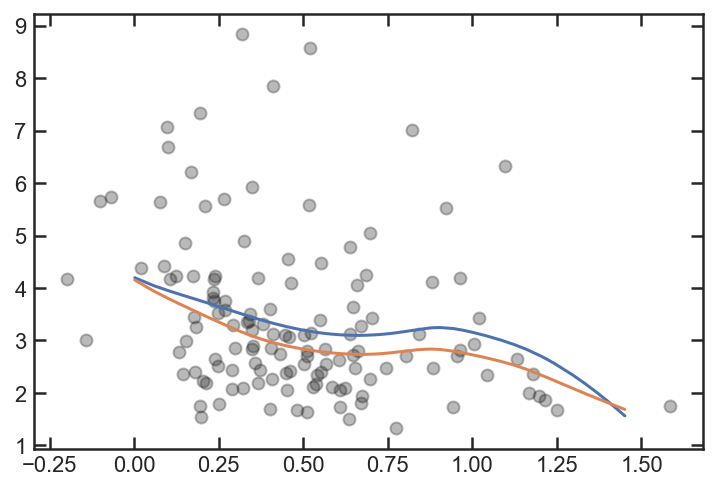

In [303]:
Amd,Amn,zmedian, zmean, zvar = Roll_bin_stat(np.log10(mdb.A.values), mdb.z_50.values,.4)
plt.scatter(np.log10(mdb.A.values), mdb.z_50.values, color='k', alpha = 0.3)
plt.plot(Amn,Smooth(Amn,zmean,0.1))
plt.plot(Amn,Smooth(Amn,zmedian,0.1))


In [382]:
GNSNR = pd.read_pickle('../dataframes/galaxy_frames/GN_cnd.pkl')
GSSNR = pd.read_pickle('../dataframes/galaxy_frames/GS_cnd.pkl')


GND 12078 2.0486055577606854 1.01637
GND 12793 2.6949914888178785 0.95257
GND 14158 1.7529823445422312 0.91086
GND 24795 1.6768841028437154 0.85846
GND 26673 2.0336694369277373 0.94168
GND 30358 2.427042097286645 1.10387
GND 32108 2.543778654843657 0.8555
GND 36348 2.0730318076574705 1.08933
GND 37189 3.112877949242773 1.58847
GND 37813 3.126796453927332 0.94569
GSD 38191 2.8621329856586857 0.97701
GSD 39850 2.232272284094236 0.97955
GSD 40476 2.517447687902084 1.21218
GSD 40862 3.1948771701574126 1.3331
GSD 42221 3.1126367772733645 1.01615
GSD 45789 1.7536274791303628 1.00465
GSD 47691 2.4809995257160624 1.12724
GSD 48631 2.841226656606362 1.16388
GND 12481 2.1933794872278756 0.66315
GND 20567 2.2624133471328784 0.645
GND 21047 2.1034550993976837 0.5584
GND 21724 2.7920471670628286 1.1329
GND 22027 2.892457697018102 1.1411
GND 22358 3.0962630813507936 0.77856
GND 29879 1.5299038915268832 0.71073
GSD 34671 2.082600986592234 0.66654
GSD 38173 2.177048028839321 0.66802
GSD 38785 3.135803

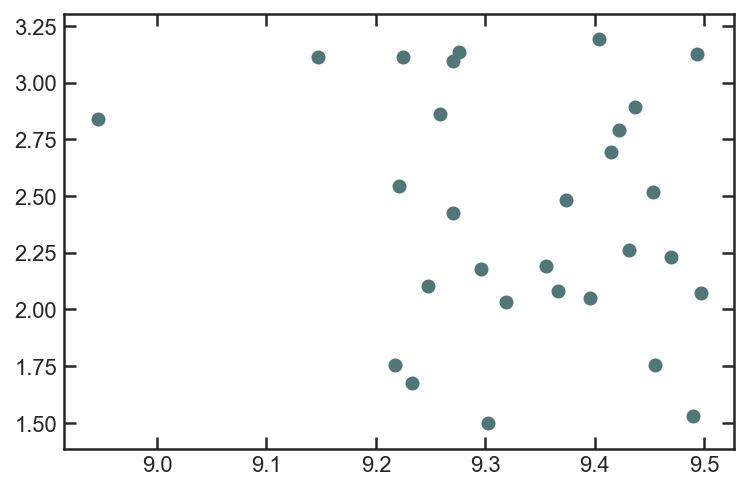

In [520]:
# plt.figure(figsize=[8,10])
# ax1 = plt.subplot(gs[1])
for i in mdb.index:
    if mdb.field[i][1] == 'S':
        if np.log10(mdb.Sigma1[i]) < 9.5 and mdb.z_50[i] < 3.26:
            plt.scatter(np.log10(mdb.Sigma1[i]), mdb.z_50[i], color = '#507678')
            print(mdb.field[i],mdb.id[i], mdb.z_50[i], mdb.zgrism[i])
    else:  

        if np.log10(mdb.Sigma1[i]) < 9.5 and mdb.z_50[i] < 3.26:
            plt.scatter(np.log10(mdb.Sigma1[i]), mdb.z_50[i], color = '#507678')

            print(mdb.field[i],mdb.id[i], mdb.z_50[i], mdb.zgrism[i])
                
# plt.xlim(10,9.0)
    

In [131]:
from spec_tools import Posterior_spec

# GS_seg = fits.open('/Volumes/Vince_CLEAR/gsd_img/goodss_3dhst.v4.0.F160W_seg.fits')[0].data
# GN_seg = fits.open('/Volumes/Vince_CLEAR/gnd_img/goodsn_3dhst.v4.0.F160W_seg.fits')[0].data

# GS_f125 = fits.open('/Volumes/Vince_CLEAR/gsd_img/goodss_3dhst.v4.0.F125W_orig_sci.fits')[0].data
# GN_f125 = fits.open('/Volumes/Vince_CLEAR/gnd_img/goodsn_3dhst.v4.0.F125W_orig_sci.fits')[0].data

# GS_f160 = fits.open('/Volumes/Vince_CLEAR/gsd_img/goodss_3dhst.v4.0.F160W_orig_sci.fits')[0].data
# GN_f160 = fits.open('/Volumes/Vince_CLEAR/gnd_img/goodsn_3dhst.v4.0.F160W_orig_sci.fits')[0].data

def IMG_pull(field, galaxy, zspec):
    if field == 'GND':
        segmap = np.array(GN_seg)
        if zspec <= 1.5:
            filt = np.array(GN_f125)
            w = wcs.WCS(fits.open('/Volumes/Vince_CLEAR/gnd_img/goodsn_3dhst.v4.0.F125W_orig_sci.fits')[0].header)
            
        else:
            filt = np.array(GN_f160)
            w = wcs.WCS(fits.open('/Volumes/Vince_CLEAR/gnd_img/goodsn_3dhst.v4.0.F160W_orig_sci.fits')[0].header)
        
    else:
        segmap = np.array(GS_seg)
        if zspec <= 1.5:
            filt = np.array(GS_f125)
            w = wcs.WCS(fits.open('/Volumes/Vince_CLEAR/gsd_img/goodss_3dhst.v4.0.F125W_orig_sci.fits')[0].header)
            
        else:
            filt = np.array(GS_f160)
            w = wcs.WCS(fits.open('/Volumes/Vince_CLEAR/gsd_img/goodss_3dhst.v4.0.F160W_orig_sci.fits')[0].header)
               
    idx = np.argwhere(segmap == galaxy)

    yrange = np.arange(min(idx.T[0]), max(idx.T[0]) + 1,1)
    xrange = np.arange(min(idx.T[1]), max(idx.T[1]) + 1,1)  

    segimg = segmap[min(idx.T[0])-20: max(idx.T[0])+21, min(idx.T[1])-20: max(idx.T[1])+21]
    filtimg = np.array(filt[min(idx.T[0])-20: max(idx.T[0])+21, min(idx.T[1])-20: max(idx.T[1])+21])
#     filtimg[segimg != galaxy] = 0

#     RA = np.zeros([len(xrange),len(yrange)])
#     DEC = np.zeros([len(xrange),len(yrange)])
#     for i in range(len(xrange)):
#         for ii in range(len(yrange)):
#             RA[i][ii],DEC[i][ii] = w.wcs_pix2world(np.array([[xrange[i],yrange[ii]]]), 1)[0]
    
    return filtimg#, RA, DEC

def rescale_img(img):   
    xmax,ymax = np.argwhere(img == np.max(img))[0][::-1]
    yrange = np.arange(img.shape[0])
    xrange = np.arange(img.shape[1])    


    new_x = np.linspace(xmax - int(4/0.06)/2, xmax + int(4/0.06)/2,  int(4/0.06) )
    new_y = np.linspace(ymax - int(4/0.06)/2, ymax + int(4/0.06)/2,  int(4 /0.06))

    inimg = interp2d(xrange, yrange, img, bounds_error=False, fill_value=0)
    return inimg(new_x,new_y)

In [8]:
int(4/0.06)

66

In [134]:
galaxies = [39170, 21156, 40862]

for gal in galaxies:
#     img = IMG_pull(mdb.query('id == {}'.format(gal)).field.values[0],gal,mdb.query('id == {}'.format(gal)).zgrism.values[0])
#     np.save('../data/imgfiles/{0}_{1}_img'.format(mdb.query('id == {}'.format(gal)).field.values[0],gal),img)
# #     np.save('../data/imgfiles/{0}_{1}_RA'.format(mdb.query('id == {}'.format(gal)).field.values[0],gal),RA)
#     np.save('../data/imgfiles/{0}_{1}_DEC'.format(mdb.query('id == {}'.format(gal)).field.values[0],gal),DEC)
    
    img = np.load('../data/imgfiles/{0}_{1}_img.npy'.format(mdb.query('id == {}'.format(gal)).field.values[0],gal))
#     RA = np.load('../data/imgfiles/{0}_{1}_RA.npy'.format(mdb.query('id == {}'.format(gal)).field.values[0],gal))
#     DEC = np.load('../data/imgfiles/{0}_{1}_DEC.npy'.format(mdb.query('id == {}'.format(gal)).field.values[0],gal))
        
#     setnorth = False
    
#     if mdb.query('id == {}'.format(gal)).field.values[0][1] == 'N':
#         setnorth = True

    rsimg = rescale_img(img)

    np.save('../data/imgfiles/{0}_{1}_rsimg'.format(mdb.query('id == {}'.format(gal)).field.values[0],gal),rsimg)    

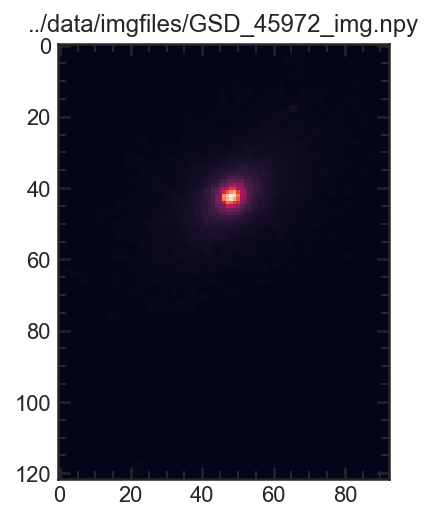

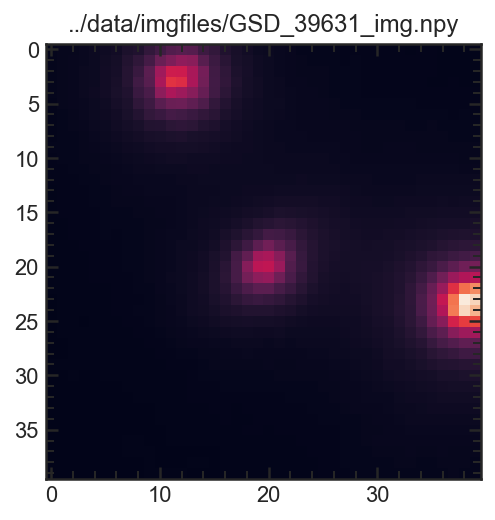

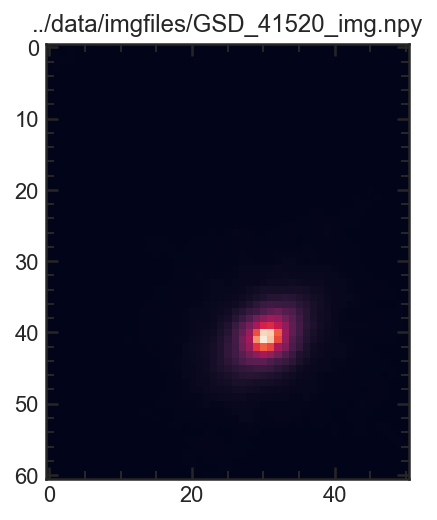

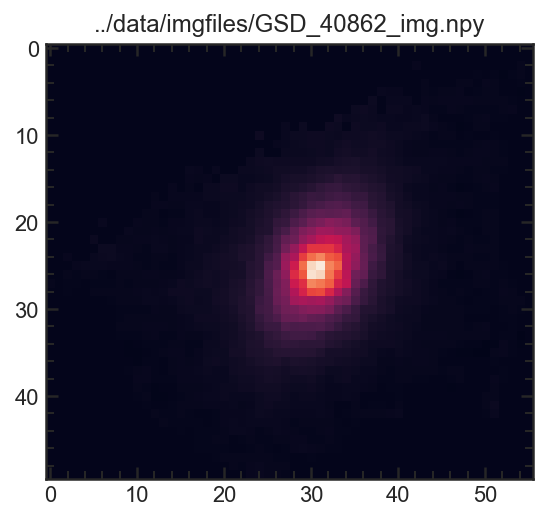

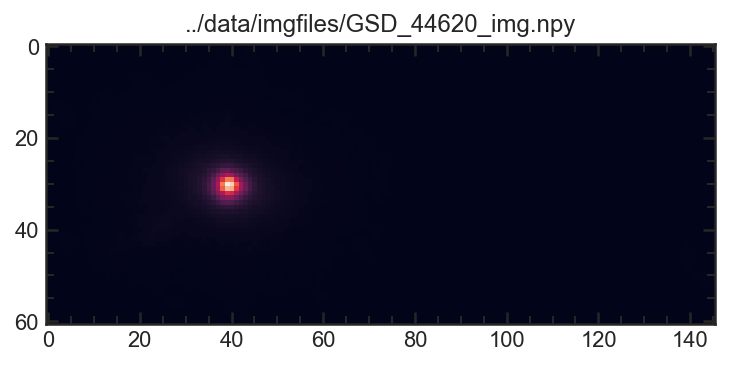

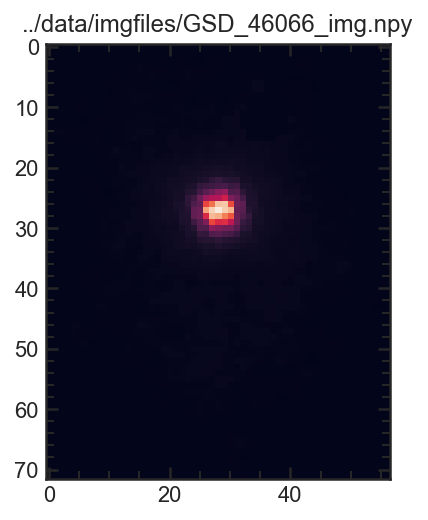

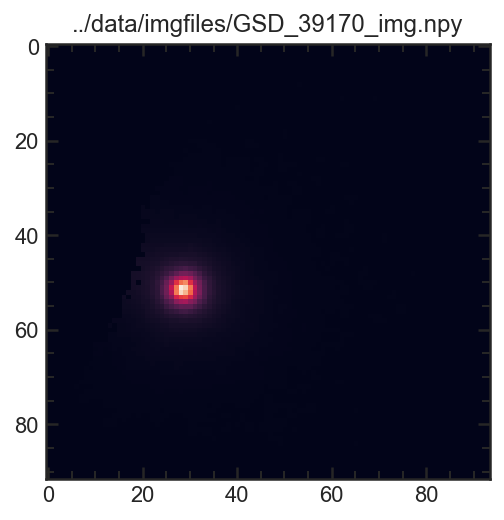

In [6]:
imglist = glob('../data/imgfiles/GSD*_img*')

for img in imglist:
    IMG = np.load(img)
    plt.figure()
    plt.imshow(IMG)
    plt.title(img)

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3423: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/vestrada/miniconda

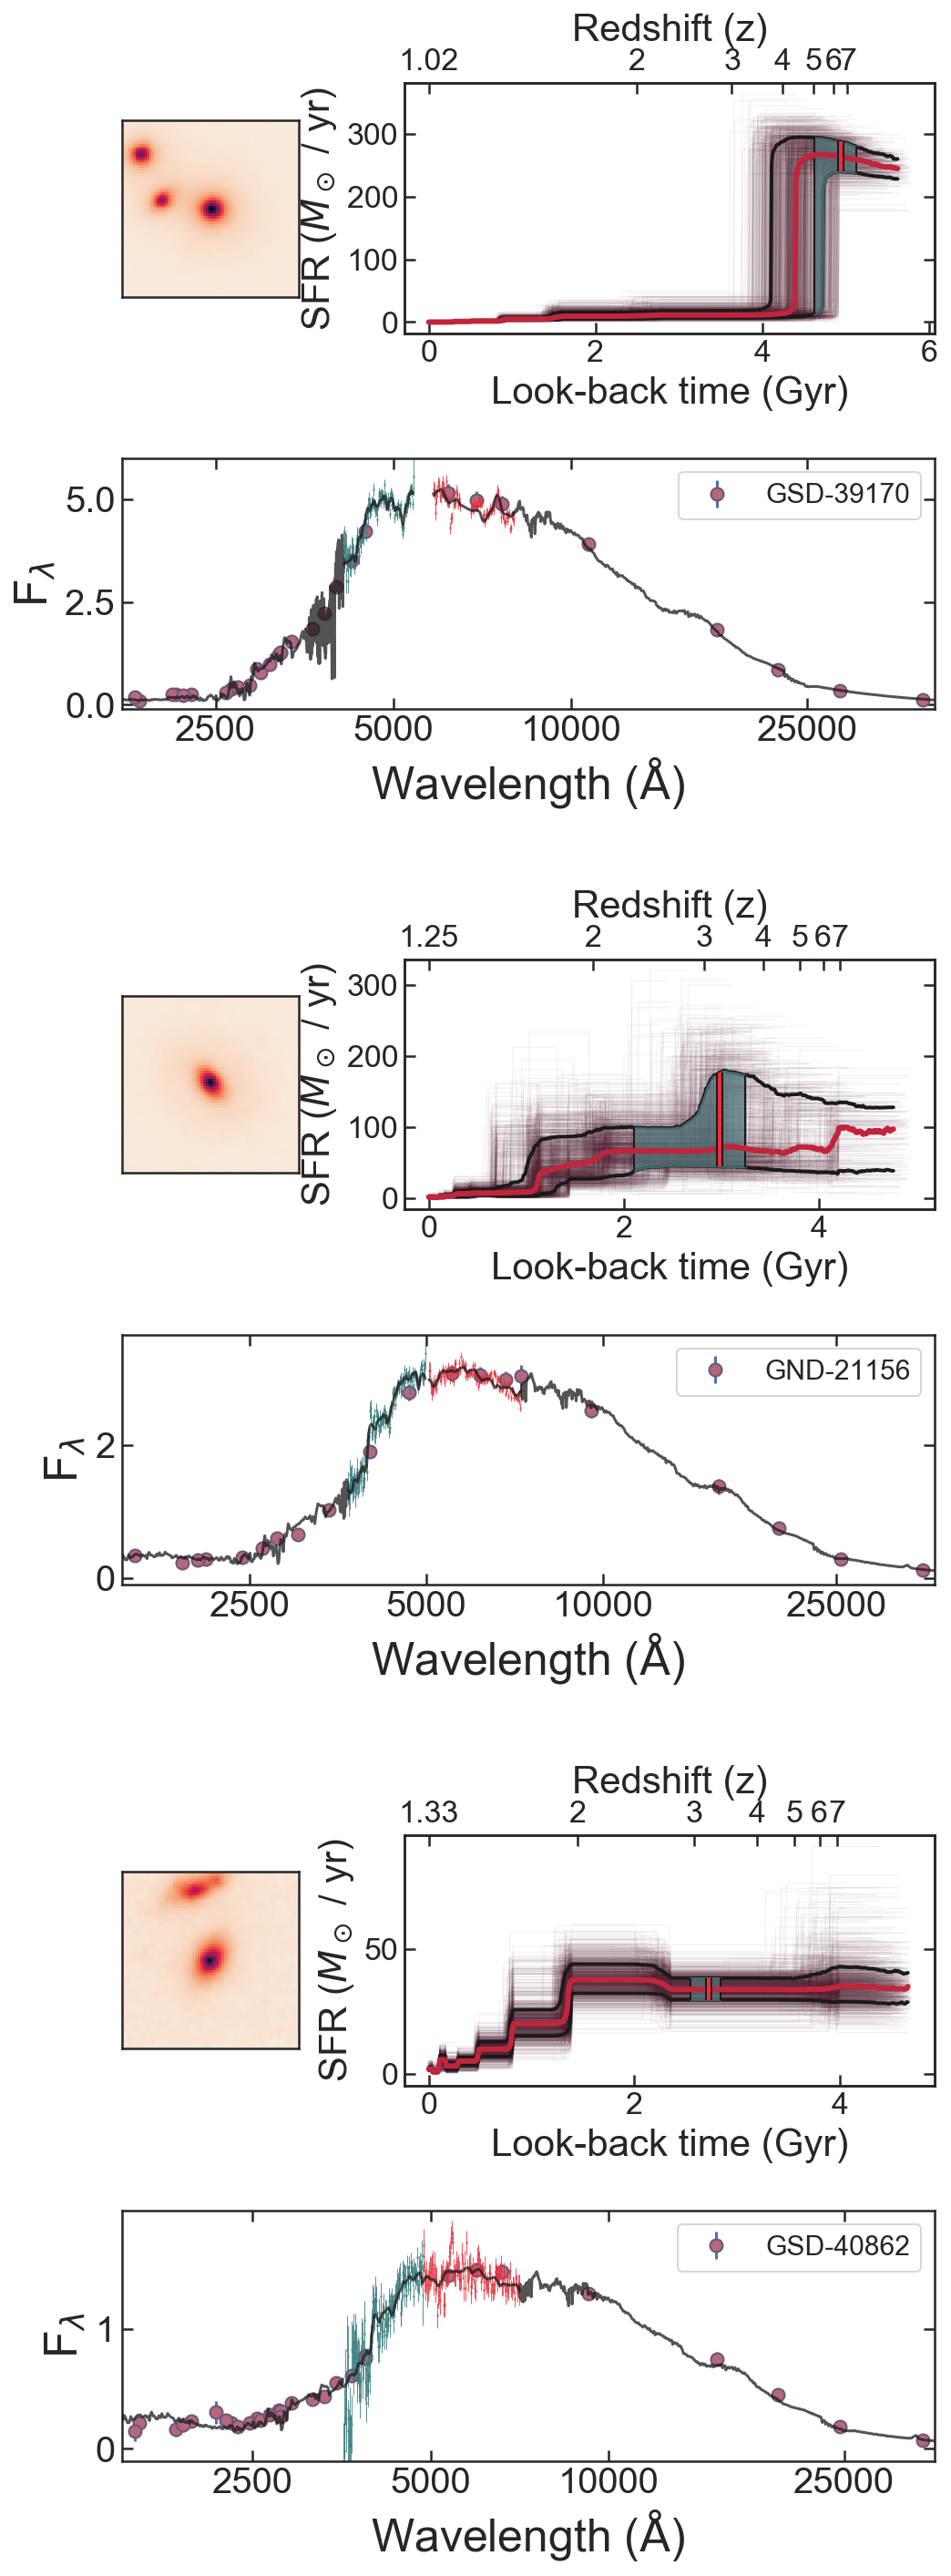

In [15]:

galaxies = [39170, 21156, 40862]

field = ['GSD','GND','GSD']

gs = gridspec.GridSpec(3,1, hspace=0.4)
plt.figure(figsize =[8,24])

for i in range(3):

    gsin = gridspec.GridSpecFromSubplotSpec(2,2, width_ratios=[1,3], subplot_spec= gs[i], hspace=0.5, wspace=0.3)

    grow = morph_db.query('id == {0}'.format(galaxies[i]))

    rsimg = np.load('../data/imgfiles/{0}_{1}_rsimg.npy'.format(field[i], galaxies[i]))

    ax1 = plt.subplot(gsin[0,0])
    ax1.imshow(-np.arcsinh(rsimg))#, vmin = -1, vmax = 0.1)
    ax1.set_xticks([])
    ax1.set_yticks([])

    ax2 = plt.subplot(gsin[1,:])

    Gs = Gen_spec(field[i], galaxies[i], grow.zgrism.values[0], phot_errterm = 0.04, irac_err = 0.08) 
    Flam = Posterior_spec(field[i], galaxies[i])

    x,px = np.load('../data/posteriors/{0}_{1}_tabfit_Pbp1.npy'.format(field[i], galaxies[i]))
    bp1 = x[px == max(px)][0]
    x,px = np.load('../data/posteriors/{0}_{1}_tabfit_Prp1.npy'.format(field[i], galaxies[i]))
    rp1 = x[px == max(px)][0]

    Gs.Best_fit_scale_flam(Flam.wave, Flam.SPEC, Flam.rshift, bp1, rp1)

    sfh = Rescale_sfh(field[i], galaxies[i])

    ##############plot tab##################

    if Gs.g102:
        ax2.errorbar(np.log10(Gs.Bwv_rf),Gs.Bfl *1E18,Gs.Ber *1E18,
                linestyle='None', marker='o', markersize=0.25, color='#36787A', zorder = 2, elinewidth = 0.4)
        ax2.plot(np.log10(Gs.Bwv_rf),Gs.Bmfl *1E18,'k', zorder = 4, alpha = 0.75)
        IDB = [U for U in range(len(Flam.wave)) if Flam.wave[U] < Gs.Bwv_rf[0]]
    else:
        IDB = [U for U in range(len(Flam.wave)) if Flam.wave[U] < Gs.Rwv_rf[0]]

    if Gs.g141:
        ax2.errorbar(np.log10(Gs.Rwv_rf),Gs.Rfl *1E18,Gs.Rer *1E18,
                linestyle='None', marker='o', markersize=0.25, color='#EA2E3B', zorder = 2, elinewidth = 0.4)
        ax2.plot(np.log10(Gs.Rwv_rf),Gs.Rmfl *1E18,'k', zorder = 4, alpha = 0.75)
        IDR = [U for U in range(len(Flam.wave)) if Flam.wave[U] > Gs.Rwv_rf[-1]]
    else:
        IDR = [U for U in range(len(Flam.wave)) if Flam.wave[U] > Gs.Bwv_rf[-1]]

    ax2.errorbar(np.log10(Gs.Pwv_rf),Gs.Pflx*1E18,Gs.Perr*1E18,
            linestyle='None', marker='o', markersize=7, markerfacecolor='#B5677D', zorder = 1,
                 markeredgecolor = '#685877',markeredgewidth = 1, label = '{0}-{1}'.format(field[i], galaxies[i]))

    ax2.plot(np.log10(Flam.wave)[IDB],Flam.SPEC[IDB]*1E18,'k', alpha = 0.75, zorder=5)
    ax2.plot(np.log10(Flam.wave)[IDR],Flam.SPEC[IDR]*1E18,'k', alpha = 0.75)
    ax2.set_xlim(np.log10(min(Gs.Pwv_rf)*0.95),np.log10(max(Gs.Pwv_rf)*1.05))
    ax2.set_ylim(-0.1,max(Gs.Rfl *1E18)*1.1)

    ax2.set_xticks(np.log10([2500,5000,10000,25000]))
    ax2.set_xticklabels(np.array([2500,5000,10000,25000]))
    ax2.legend(fontsize=15, frameon = True, loc = 1)
    ax2.set_xlabel(r'Wavelength ($\rm \AA$)', fontsize=25)
    ax2.set_ylabel(r'F$_\lambda$', fontsize=25)
    ax2.tick_params(axis='both', which='major', labelsize=20)

    ax3 = plt.subplot(gsin[0,1])

    isfhl = interp1d(sfh.LBT,sfh.SFH_16)
    isfhh = interp1d(sfh.LBT,sfh.SFH_84)

    ax4 = ax3.twiny()

    ax3.plot(sfh.fulltimes, sfh.sfr_grid.T, color = '#532436', alpha=.075, linewidth = 0.5)
    ax3.plot(sfh.LBT,sfh.SFH, color = '#C1253C', linewidth = 3, zorder = 9)
    ax3.plot(sfh.LBT,sfh.SFH_16, 'k', linewidth = 2)
    ax3.plot(sfh.LBT,sfh.SFH_84, 'k', linewidth = 2)


    max_lbt = np.round(sfh.fulltimes[-1])
    max_age = max_lbt + cosmo.lookback_time(grow.zgrism.values[0]).value
    age_at_z = cosmo.lookback_time(grow.zgrism.values[0]).value
    zarray = [np.round(grow.zgrism.values[0],2)]

    idx = 0
    while cosmo.lookback_time(np.array(zarray[idx])).value  < 13:
        zarray.append(int(zarray[idx])+1)
        idx += 1 

    tarray =cosmo.lookback_time(np.array(zarray)).value - cosmo.lookback_time(np.array(zarray)).value[0]

    ax4.set_xlim(ax3.get_xlim())
    ax4.set_xticks(tarray)
    ax4.set_xticklabels(zarray)
    ax4.xaxis.set_ticks_position('top')

    ax3.set_xlabel('Look-back time (Gyr)', fontsize=21)
    ax3.set_ylabel('SFR ($M_\odot$ / yr)', fontsize=21)
    ax4.set_xlabel('Redshift (z)', fontsize=21) 
    ax3.tick_params(axis='both', which='major', labelsize=17)
    ax4.tick_params(axis='both', which='major', labelsize=17)

    ax3.vlines(grow.t_50.values[0],isfhl(grow.t_50.values[0]), isfhh(grow.t_50.values[0]), color = '#ED2D39', linewidth = 2, zorder = 11)
    ax3.vlines(grow.t_50.values[0],isfhl(grow.t_50.values[0]), isfhh(grow.t_50.values[0]), color = 'k', linewidth = 4, zorder = 10)

    hdr = np.linspace(grow.t_50_hci.values[0][0],grow.t_50_hci.values[0][1])

    ax3.fill_between(hdr, isfhh(hdr), isfhl(hdr), color = '#4E7577', alpha=0.75, zorder = 8)
    ax3.vlines(grow.t_50_hci.values[0][0],isfhl(grow.t_50_hci.values[0][0]),isfhh(grow.t_50_hci.values[0][0]), 
               color = 'k', linewidth = 1, zorder = 8)
    ax3.vlines(grow.t_50_hci.values[0][1],isfhl(grow.t_50_hci.values[0][1]),isfhh(grow.t_50_hci.values[0][1]), 
               color = 'k', linewidth = 1, zorder = 8)

plt.savefig('../plots/presentation_plots/z_50_spec_sfh.pdf', bbox_inches = 'tight')

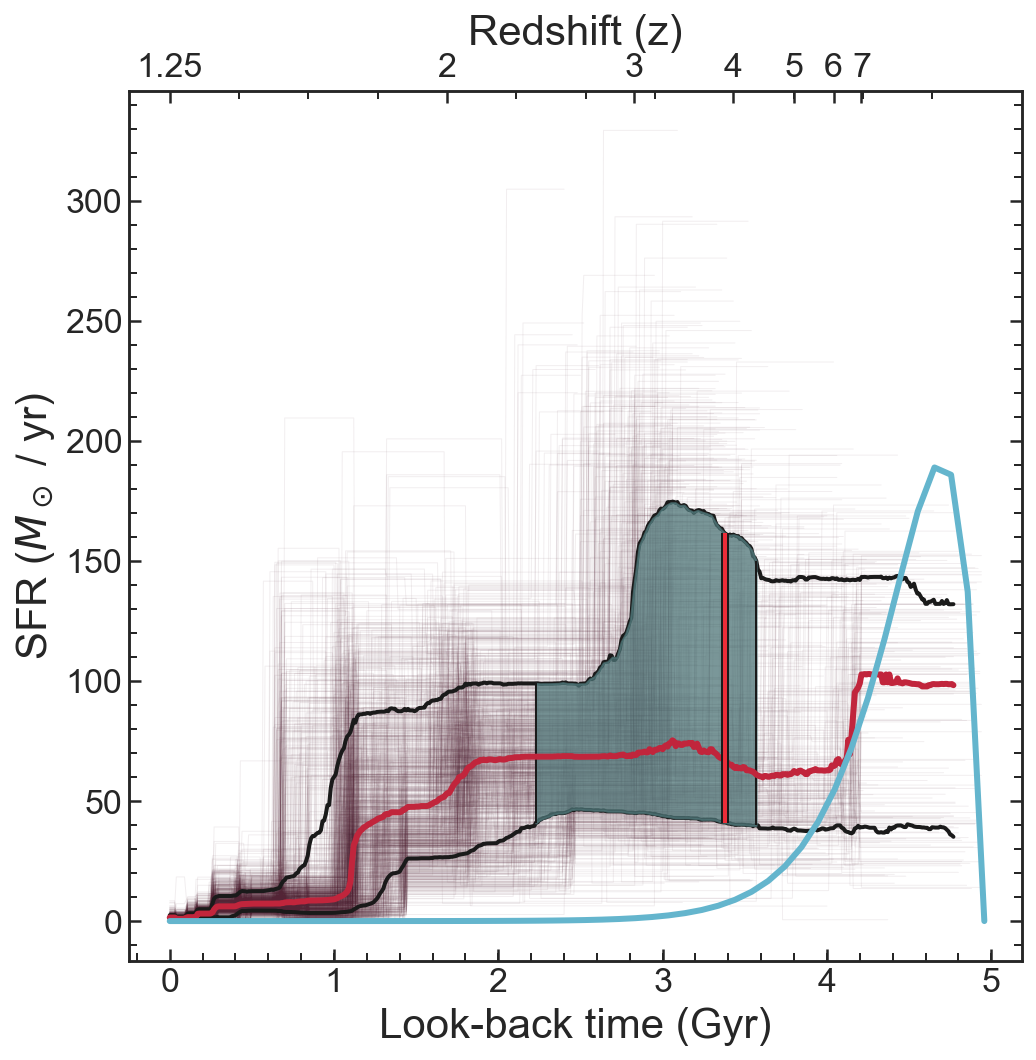

In [18]:
sfh = Rescale_sfh('GND', 21156)
grow = mdb.query('id == 21156')

plt.figure(figsize=[8,8])
ax3 = plt.subplot()

isfhl = interp1d(sfh.LBT,sfh.SFH_16)
isfhh = interp1d(sfh.LBT,sfh.SFH_84)

ax4 = ax3.twiny()

ax3.plot(sfh.fulltimes, sfh.sfr_grid.T, color = '#532436', alpha=.075, linewidth = 0.5)
ax3.plot(sfh.LBT,sfh.SFH, color = '#C1253C', linewidth = 3, zorder = 9)
ax3.plot(sfh.LBT,sfh.SFH_16, 'k', linewidth = 2)
ax3.plot(sfh.LBT,sfh.SFH_84, 'k', linewidth = 2)


max_lbt = np.round(sfh.fulltimes[-1])
max_age = max_lbt + cosmo.lookback_time(grow.zgrism.values[0]).value
age_at_z = cosmo.lookback_time(grow.zgrism.values[0]).value
zarray = [np.round(grow.zgrism.values[0],2)]

idx = 0
while cosmo.lookback_time(np.array(zarray[idx])).value  < 13:
    zarray.append(int(zarray[idx])+1)
    idx += 1 

tarray =cosmo.lookback_time(np.array(zarray)).value - cosmo.lookback_time(np.array(zarray)).value[0]

ax4.set_xlim(ax3.get_xlim())
ax4.set_xticks(tarray)
ax4.set_xticklabels(zarray)
ax4.xaxis.set_ticks_position('top')

ax3.set_xlabel('Look-back time (Gyr)', fontsize=21)
ax3.set_ylabel('SFR ($M_\odot$ / yr)', fontsize=21)
ax4.set_xlabel('Redshift (z)', fontsize=21) 
ax3.tick_params(axis='both', which='major', labelsize=17)
ax4.tick_params(axis='both', which='major', labelsize=17)

ax3.vlines(grow.t_50.values[0],isfhl(grow.t_50.values[0]), isfhh(grow.t_50.values[0]), color = '#ED2D39', linewidth = 2, zorder = 11)
ax3.vlines(grow.t_50.values[0],isfhl(grow.t_50.values[0]), isfhh(grow.t_50.values[0]), color = 'k', linewidth = 4, zorder = 10)

for i in range(len(grow.t_50_hci.values[0])//2):
    hdr = np.linspace(grow.t_50_hci.values[0][2*i],grow.t_50_hci.values[0][2*i+1])

    ax3.fill_between(hdr, isfhh(hdr), isfhl(hdr), color = '#4E7577', alpha=0.75, zorder = 8)
    ax3.vlines(grow.t_50_hci.values[0][2*i],isfhl(grow.t_50_hci.values[0][2*i]),isfhh(grow.t_50_hci.values[0][2*i]), 
               color = 'k', linewidth = 1, zorder = 8)
    ax3.vlines(grow.t_50_hci.values[0][2*i+1],isfhl(grow.t_50_hci.values[0][2*i+1]),isfhh(grow.t_50_hci.values[0][2*i+1]), 
               color = 'k', linewidth = 1, zorder = 8)

    
t = np.linspace(0, Oldest_galaxy(mdb.query('id == 21156').zgrism))

dtau = t * np.exp(-t / 0.26)     
    
plt.plot(t[::-1],dtau*2000,'c', linewidth = 3)

plt.savefig('../plots/presentation_plots/21156_delay_tab.png', bbox_inches = 'tight')

# evolution track

In [3]:
v4N = Table.read(fits.open('/Volumes/Vince_CLEAR/3dhst_V4.4/goodsn_3dhst.v4.4.cats/Eazy/goodsn_3dhst.v4.4.zout.fits'),
                 format='fits').to_pandas()
v4S = Table.read(fits.open('/Volumes/Vince_CLEAR/3dhst_V4.4/goodss_3dhst.v4.4.cats/Eazy/goodss_3dhst.v4.4.zout.fits'),
                 format='fits').to_pandas()

In [4]:
def Color(band1, band2):
    m1=-2.5*np.log10(band1)
    m2=-2.5*np.log10(band2)
    return m1-m2

In [5]:
mdb.query('lmass >= 11 and Re < 2')[['field','id']]

field     id
3     GND  13774
8     GND  17070
12    GND  22213
22    GND  27185
40    GND  37340
41    GND  37686
53    GSD  39804
57    GSD  40597
61    GSD  41520
87    GND  17746
94    GND  21738
144   GSD  39012
156   GSD  46066

2.9407918089661336


[0, 2.5, 0.5, 2.5]

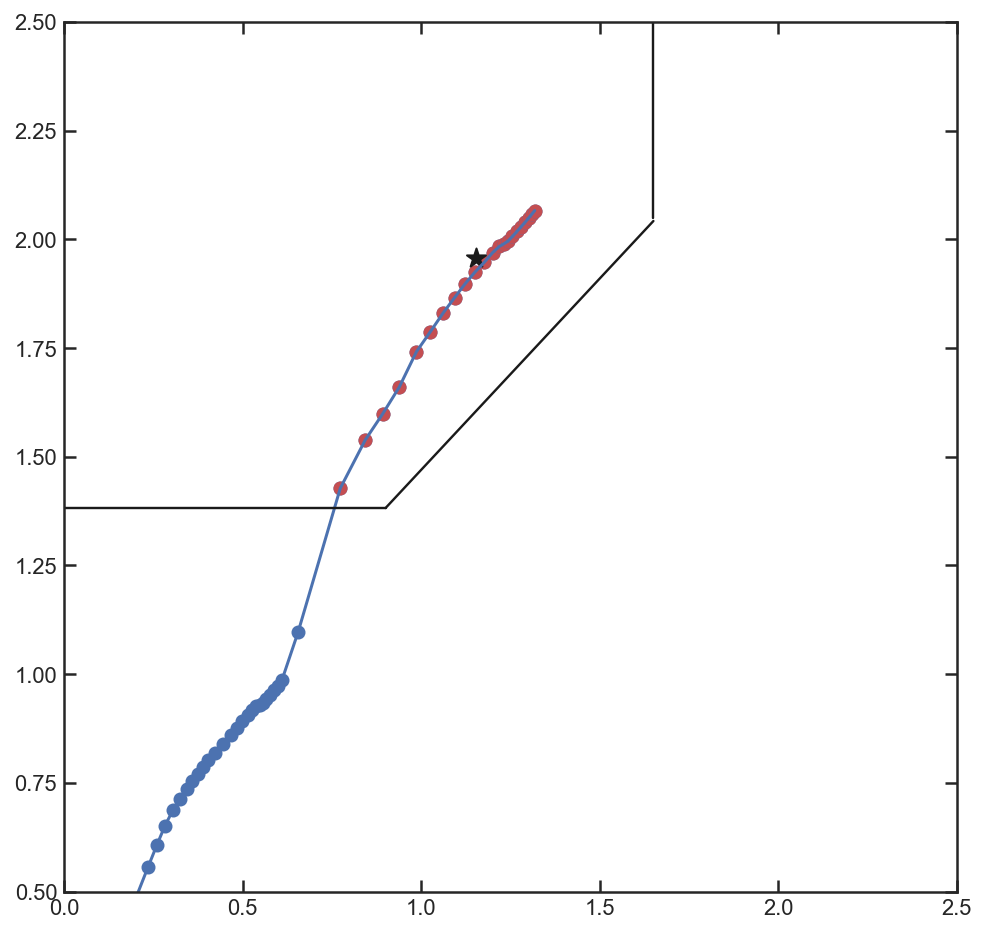

In [24]:
field = 'GSD'
gal_id = 40597

sfh = Rescale_sfh(field, gal_id)

sp = fsps.StellarPopulation(zcontinuous = 1, logzsol = np.log10(mdb.query('id == {0}'.format(gal_id)).Z.values),
                            sfh = 3, dust_type = 1, dust2 = mdb.query('id == {0}'.format(gal_id)).Av.values)

sp.set_tabular_sfh(sfh.LBT,sfh.SFH[::-1]) 

if field[1] == 'N':
    GUV = Color(v4N.query('id == {0}'.format(gal_id)).restU.values, v4N.query('id == {0}'.format(gal_id)).restV.values)
    GVJ = Color(v4N.query('id == {0}'.format(gal_id)).restV.values, v4N.query('id == {0}'.format(gal_id)).restJ.values)
    

if field[1] == 'S':
    GUV = Color(v4S.query('id == {0}'.format(gal_id)).restU.values, v4S.query('id == {0}'.format(gal_id)).restV.values)
    GVJ = Color(v4S.query('id == {0}'.format(gal_id)).restV.values, v4S.query('id == {0}'.format(gal_id)).restJ.values)

ages = np.linspace(0.1, Oldest_galaxy(mdb.query('id == {0}'.format(gal_id)).zgrism.values))

U = []
V = []
J = []

plt.figure(figsize=[8,8])

switch = 0
t_q = 0
for a in ages:
    uu,vv,jj = sp.get_mags(tage = a, bands = ['u','v','2mass_j'])
    
    U.append(uu)
    V.append(vv)
    J.append(jj)
        
    plt.scatter(vv-jj,uu-vv, color = 'b')

    if (uu-vv) >= 0.88 * (vv-jj) + 0.59 and (uu-vv) > 1.382 and (vv-jj) < 1.65:
        plt.scatter(vv-jj, uu-vv, color = 'r')
        if switch == 0:
            print(a)
            t_q = a
            switch = 1
            
UV = np.array(U) - np.array(V)
VJ = np.array(V) - np.array(J)
            
plt.plot(VJ,UV)
plt.scatter(GVJ,GUV, color = 'k', marker = '*', s=100)
plt.plot([0,.9],[1.382,1.382],'k',lw=1.2)
plt.plot([1.65,1.65],[2.05,2.5],'k',lw=1.2)
plt.plot([.9,1.65],[0.88*.9+0.59,0.88*1.65+0.59],'k',lw=1.2)
plt.axis([0,2.5,.5,2.5])

In [25]:
z_at_value(cosmo.lookback_time, 
           (cosmo.lookback_time(mdb.query('id == {0}'.format(gal_id)).zgrism.values).value + sfh.LBT[-1] - t_q)*u.Gyr)

array([1.59614086])

In [337]:
lbt = max(T) - np.array(T) + cosmo.lookback_time(1.25).value
iM = interp1d(lbt,M)
iSFR = interp1d(lbt,SFR)

In [338]:
iM(cosmo.lookback_time(5))

array(3.22478187e+11)

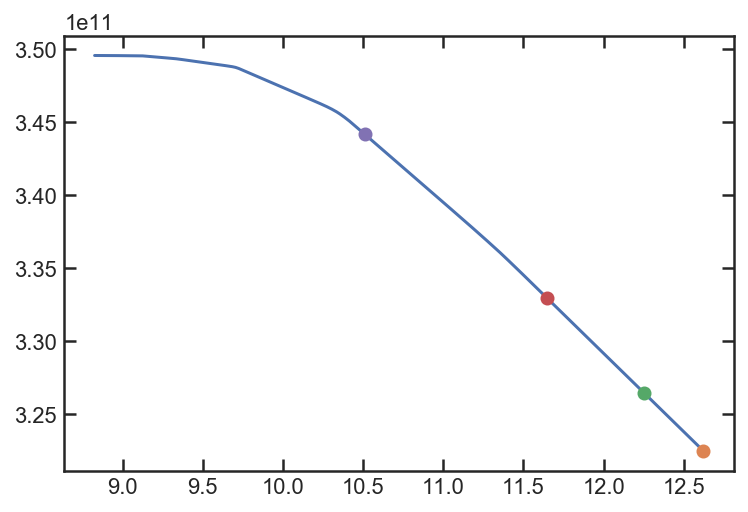

In [340]:
# plt.plot(max(T) - np.array(T), np.array(M))
plt.plot(np.array(lbt)[lbt < lbt_5], np.array(M)[lbt < lbt_5])

for z in [5,4,3,2]:
    plt.plot(cosmo.lookback_time(z), iM(cosmo.lookback_time(z)),'o')


In [62]:

rshifts = []

for age in (cosmo.lookback_time(1.25).value + np.array(T)):
    rshifts.append(z_at_value(cosmo.lookback_time, age * u.Gyr))

In [ ]:
field = 'GND'
galaxy = 21156

grow = morph_db.query('id == {0}'.format(galaxy))

Gs = Gen_spec(field, galaxy, grow.zgrism.values[0], phot_errterm = 0.04, irac_err = 0.08) 
Flam = Posterior_spec(field, galaxy)

x,px = np.load('../data/posteriors/{0}_{1}_tabfit_Pbp1.npy'.format(field, galaxy))
bp1 = x[px == max(px)][0]
x,px = np.load('../data/posteriors/{0}_{1}_tabfit_Prp1.npy'.format(field, galaxy))
rp1 = x[px == max(px)][0]

Gs.Best_fit_scale_flam(Flam.wave, Flam.SPEC, Flam.rshift, bp1, rp1)

sfh = Rescale_sfh(field, galaxy)

gs = gridspec.GridSpec(1,2,width_ratios=[1,3], hspace=0.3, wspace = 0.2)   
    ###############plot tab##################
axin = ax1_inset.subplot(gs[1])

if Gs.g102:
    axin.errorbar(np.log10(Gs.Bwv_rf),Gs.Bfl *1E18,Gs.Ber *1E18,
            linestyle='None', marker='o', markersize=3, color='#36787A', zorder = 2)
    axin.plot(np.log10(Gs.Bwv_rf),Gs.Bmfl *1E18,'k', zorder = 4)
    IDB = [U for U in range(len(Flam.wave)) if Flam.wave[U] < Gs.Bwv_rf[0]]
else:
    IDB = [U for U in range(len(Flam.wave)) if Flam.wave[U] < Gs.Rwv_rf[0]]

if Gs.g141:
    axin.errorbar(np.log10(Gs.Rwv_rf),Gs.Rfl *1E18,Gs.Rer *1E18,
            linestyle='None', marker='o', markersize=3, color='#EA2E3B', zorder = 2)
    axin.plot(np.log10(Gs.Rwv_rf),Gs.Rmfl *1E18,'k', zorder = 4)
    IDR = [U for U in range(len(Flam.wave)) if Flam.wave[U] > Gs.Rwv_rf[-1]]
else:
    IDR = [U for U in range(len(Flam.wave)) if Flam.wave[U] > Gs.Bwv_rf[-1]]

axin.errorbar(np.log10(Gs.Pwv_rf),Gs.Pflx*1E18,Gs.Perr*1E18,
        linestyle='None', marker='o', markersize=10, markerfacecolor='#B5677D', zorder = 1,
             markeredgecolor = '#685877',markeredgewidth = 1)

axin.plot(np.log10(Flam.wave)[IDB],Flam.SPEC[IDB]*1E18,'k', alpha = 1, label = 'Model', zorder=5)
axin.plot(np.log10(Flam.wave)[IDR],Flam.SPEC[IDR]*1E18,'k', alpha = 1)
axin.xlim(np.log10(min(Gs.Pwv_rf)*0.95),np.log10(max(Gs.Pwv_rf)*1.05))

axin.xticks(np.log10([2500,5000,7500,10000,25000]),[2500,5000,7500,10000,25000])
axin.title(galaxy, fontsize=15)
axin.xlabel(r'Wavelength ($\rm \AA$)', fontsize=15)
axin.ylabel(r'F$_\lambda$ ($10^{-18}$ $erg/s/cm^{2}/ \rm \AA $)', fontsize=15)
axin.tick_params(axis='both', which='major', labelsize=15)

#################plot image###################
rsimg = np.load('../data/imgfiles/{0}_{1}_rsimg.npy'.format(field, galaxy))

axin2 = ax1_inset.subplot(gs[0])
axin2.imshow(-np.arcsinh(rsimg))    
axin2.xticks([])
axin2.yticks([])

In [189]:
Repix = interp1d(profile, np.arange(len(profile)))(profile[-1]*.5)

In [13]:
if hpath.split('/')[-2][-1] == 'a':
    goodss_rad = Table.read('/Users/vestrada/Downloads/allfields/goodss/goodss_3dhst.v4.1_f125w.galfit',format='ascii').to_pandas()
    goodsn_rad = Table.read('/Users/vestrada/Downloads/allfields/goodsn/goodsn_3dhst.v4.1_f125w.galfit',format='ascii').to_pandas()
else:
    goodss_rad = Table.read('/Users/Vince.ec/Clear_data/galaxy_meas/goodss_3dhst.v4.1_f125w.galfit',format='ascii').to_pandas()
    goodsn_rad = Table.read('/Users/Vince.ec/Clear_data/galaxy_meas/goodsn_3dhst.v4.1_f125w.galfit',format='ascii').to_pandas()

In [14]:
goodss_rad.query('NUMBER == 41520')

NUMBER         RA        DEC  f    mag      dmag        re       dre  \
41519   41520  53.152725 -27.716251  0  22.01  0.009394  0.199608  0.002998   

            n        dn       q        dq       pa      dpa       sn  
41519  3.5081  0.097781  0.5029  0.009877  53.3617  1.04637  361.393

In [14]:
img.shape, ra[-1]/51, dec[-1]/61

((61, 51), 0.06644795313009662, 0.0590162555824014)

In [78]:
iS(max(S)*0.2)/cosmo.kpc_proper_per_arcmin(grow.zgrism.values[0]).value*60 / 0.06

1.7310828248872285

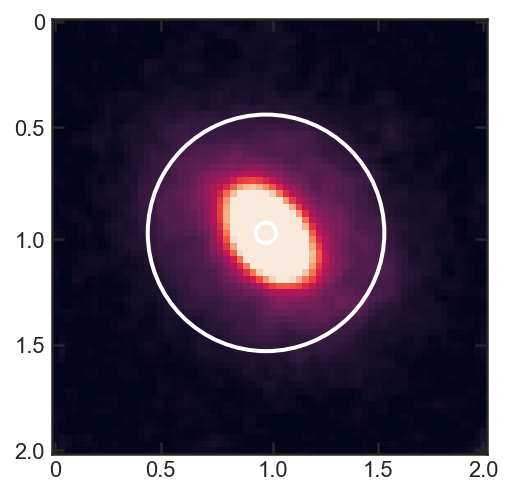

In [79]:
img = np.load('../data/imgfiles/GND_21156_rsimg.npy')

grow = morph_db.query('id == 21156')
mrow = goodsn_rad.query('NUMBER == 21156')

re = mrow.re.values[0]
q = mrow.q.values[0]

iS = interp1d(S, np.logspace(-1,2))
r20 = iS(max(S)*0.2)/cosmo.kpc_proper_per_arcmin(grow.zgrism.values[0]).value*60 / 0.06
r80 = iS(max(S)*0.8)/cosmo.kpc_proper_per_arcmin(grow.zgrism.values[0]).value*60 / 0.06

Bimg = np.zeros_like(img)
for i in range(len(img)):
    for ii in range(len(img.T)):
        if i > 1 and ii > 1:
            Bimg[i][ii]=np.mean(img[i - 2 : i + 3,ii - 2 : ii + 3])

xmax,ymax = np.argwhere(Bimg == np.max(Bimg))[0][::-1]

plt.figure()
ax = plt.subplot()
ax.imshow(img, vmin = 0.00, vmax=0.2)
plt.yticks([0,16,33,49,65], [0,0.5, 1.0,1.5, 2.0])
plt.xticks([0,16,33,49,65], [0,0.5, 1.0,1.5, 2.0])

circle1=plt.Circle([xmax,ymax],radius= r20 ,ec='w',fc='none', linewidth=2)
ax.add_artist(circle1)

circle2=plt.Circle([xmax,ymax],radius= r80 ,ec='w',fc='none', linewidth=2)
ax.add_artist(circle2)

In [53]:
np.logspace(-1,2)

array([  0.1       ,   0.11513954,   0.13257114,   0.1526418 ,
         0.17575106,   0.20235896,   0.23299518,   0.26826958,
         0.30888436,   0.35564803,   0.40949151,   0.47148664,
         0.54286754,   0.62505519,   0.71968567,   0.82864277,
         0.95409548,   1.09854114,   1.26485522,   1.45634848,
         1.67683294,   1.93069773,   2.22299648,   2.55954792,
         2.9470517 ,   3.39322177,   3.90693994,   4.49843267,
         5.17947468,   5.96362332,   6.86648845,   7.90604321,
         9.10298178,  10.48113134,  12.06792641,  13.89495494,
        15.9985872 ,  18.42069969,  21.20950888,  24.42053095,
        28.11768698,  32.37457543,  37.2759372 ,  42.9193426 ,
        49.41713361,  56.89866029,  65.51285569,  75.43120063,
        86.85113738, 100.        ])

In [60]:
def Fphot(field, galaxy_id, phot):
    if phot.lower() == 'f125':
        bfilters = 203
    if phot.lower() == 'f160':
        bfilters = 205

    W, F, E, FLT = np.load('../phot/{0}_{1}_phot.npy'.format(field, galaxy_id))

    return (F[FLT == bfilters] * W[FLT == bfilters]**2 / 3E18)[0]

def IR_prime(n, Reff, R):
    b = 2*n - (1/3)  
    return R * np.exp(-b * (R / Reff)**(1/n))

def Sigma_all(field, galaxy, filt, gfit_cat):
    grow = mdb.query('id == {0}'.format(galaxy))
    Reff = grow['Re'].values[0]
    n = grow['n'].values[0]
    mass = 10**grow['lmass'].values[0]
    
    mgal = gfit_cat.query('NUMBER == {0}'.format(galaxy)).mag.values[0]    
    Lgal = 10**((mgal + 48.6) / -2.5)   

    r_range = np.linspace(0,100,100000)
    bottom = np.trapz(IR_prime(n, Reff, r_range), r_range) 
    
    sigma = []
    
    for radius in np.logspace(-1,2):
    
        r_range = np.linspace(0,radius,100000)
        top = np.trapz(IR_prime(n, Reff, r_range), r_range)
    
        sigma.append((top / bottom)*(Lgal / Fphot(field, galaxy, filt))*mass / np.pi**2)
    
    return np.array(sigma)

In [61]:
S = Sigma_all('GND', 21156,'f125', goodsn_rad)

In [70]:
iS = interp1d(S, np.logspace(-1,2))
print(iS(max(S)*0.2), iS(max(S)*0.8))

0.7933147597229798 9.227793156881887


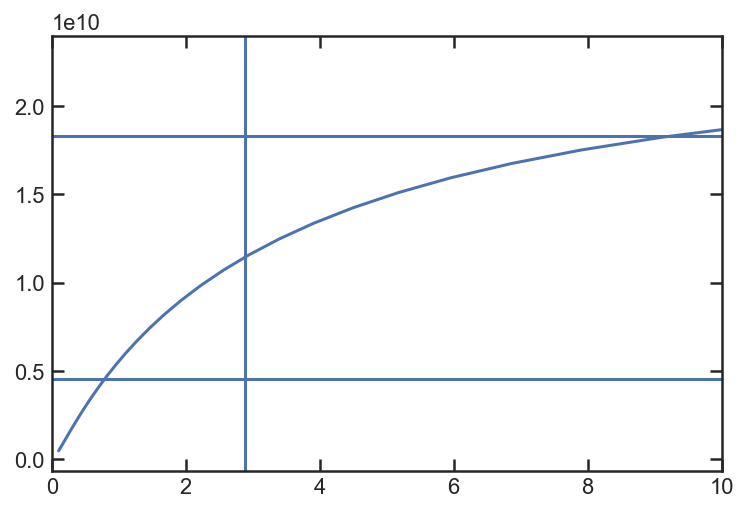

In [69]:
plt.plot(np.logspace(-1,2),S)
plt.axhline(max(S)*0.2)
plt.axhline(max(S)*0.8)

plt.xlim(0,10)
plt.axvline(grow.Re.values)

0.6736606


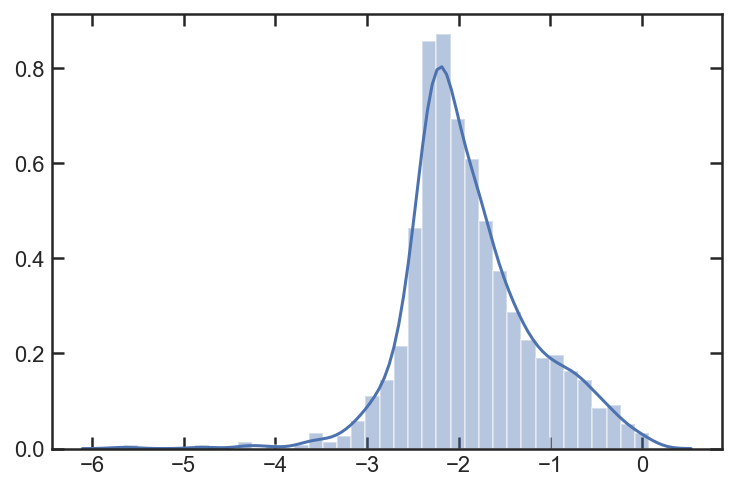

In [210]:
sea.distplot(np.log10(img.ravel()[img.ravel() > 0]))
print(np.std(np.log10(img.ravel()[img.ravel() > 0])))
# plt.xlim(0,0.1)
# plt.ylim(0,20)

In [184]:
Bimg = np.zeros_like(img)
for i in range(len(img)):
    for ii in range(len(img.T)):
        if i > 1 and ii > 1:
            Bimg[i][ii]=np.mean(img[i - 2 : i + 3,ii - 2 : ii + 3])

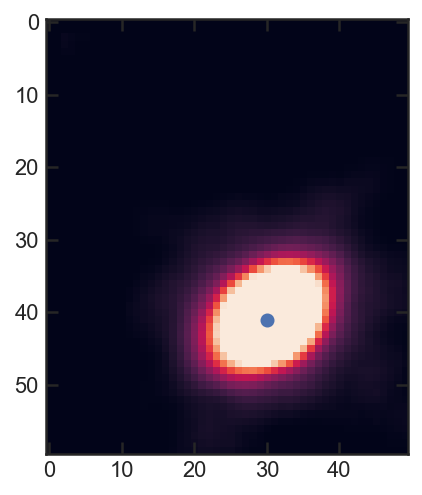

In [185]:
xmax,ymax = np.argwhere(Bimg == np.max(Bimg))[0][::-1]
plt.figure()
ax = plt.subplot()
ax.imshow(np.arcsinh(Bimg), vmin = 0, vmax=.08)
plt.scatter(xmax,ymax)

In [186]:
np.argwhere(Bimg == np.max(Bimg))[0][::-1] , np.argwhere(img == np.max(img))[0][::-1]

(array([30, 41]), array([30, 41]))

In [187]:
profile = [0]
variance = []
idx = 0

Rmax = min(img.shape)
for u in np.arange(1, Rmax/2,1):
    newimg = np.zeros_like(img)
    ring = []
    for i in range(len(img)):
        for ii in range(len(img.T)):
            if np.round(np.sqrt((i - ymax)**2 + (ii - xmax)**2),0) <= u:
                newimg[i][ii] = img[i][ii]
            if np.round(np.sqrt((i - ymax)**2 + (ii - xmax)**2),0) == u:
                ring.append(img[i][ii])
#     plt.figure()
#     plt.imshow(newimg)
#     plt.title(u)
    profile.append(np.trapz(np.trapz(newimg)))
    variance.append(np.var(ring))
    if idx > 1 :
        if np.gradient(variance)[idx] > 0:
            break
    idx += 1

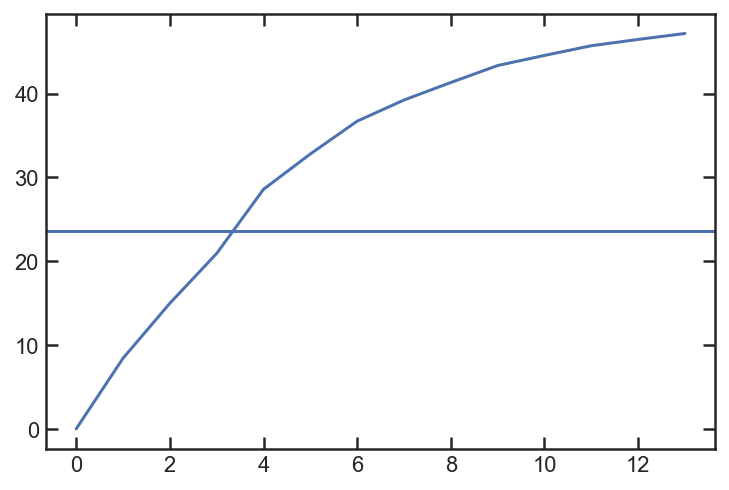

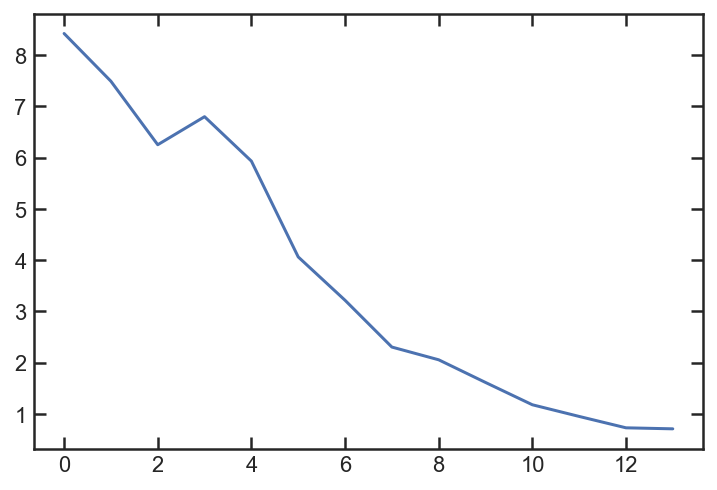

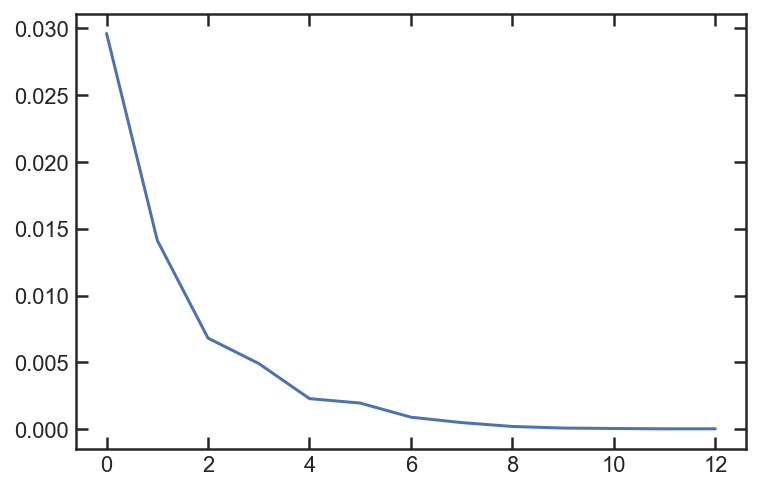

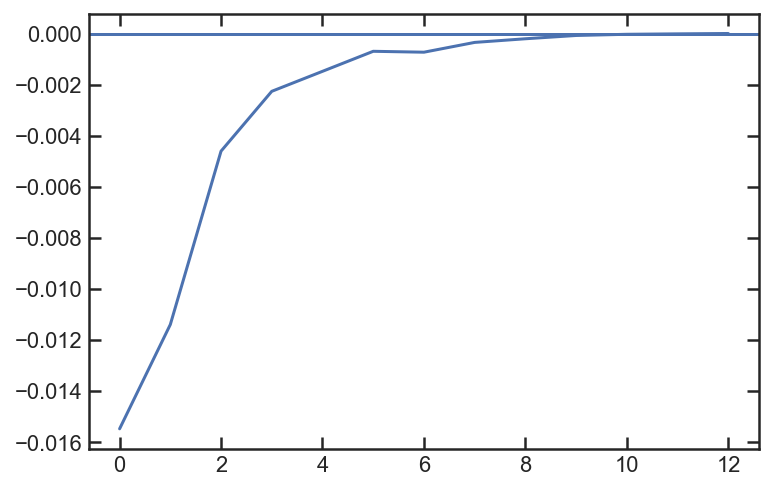

In [188]:
plt.figure()
plt.plot(profile)
plt.axhline(profile[-1] / 2)

plt.figure()
plt.plot(np.gradient(profile))

plt.figure()
plt.plot(variance)

plt.figure()
plt.plot(np.gradient(variance))
plt.axhline(0)



In [44]:
binvar = []

for i in range(len(variance)):
    binvar.append(np.mean(np.gradient(variance)[i:i+4]))
    print(np.mean(np.gradient(variance)[i:i+4]))

-0.036254868
-0.031417973
-0.02153094
-0.012142619
-0.0056928275
-0.0016694564
-0.00057068776
-7.625979e-05
0.00016946084
0.00045582675
0.001152446
0.002690137
0.0061674244
0.010916131
0.012483479
0.010444948
0.009127616
0.0036707157
-0.0017531663


In [35]:
binvar

[-0.036254868,
 -0.031417973,
 -0.02153094,
 -0.012142619,
 -0.0056928275,
 -0.0016694564,
 -0.00057068776,
 -7.625979e-05,
 0.00016946084,
 0.00045582675,
 0.001152446,
 0.002690137,
 0.0061674244,
 0.010916131,
 0.012483479,
 0.010444948,
 0.009127616,
 0.0036707157,
 -0.0017531663]

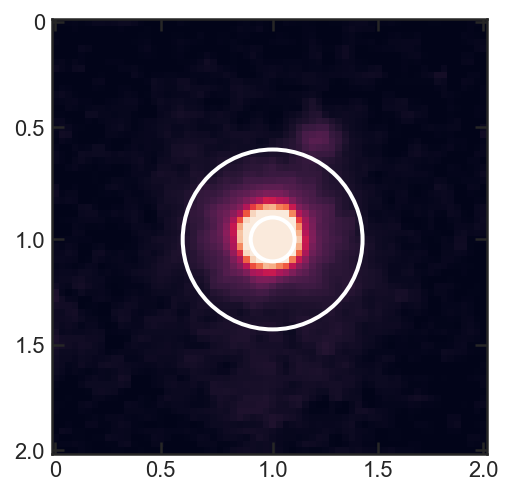

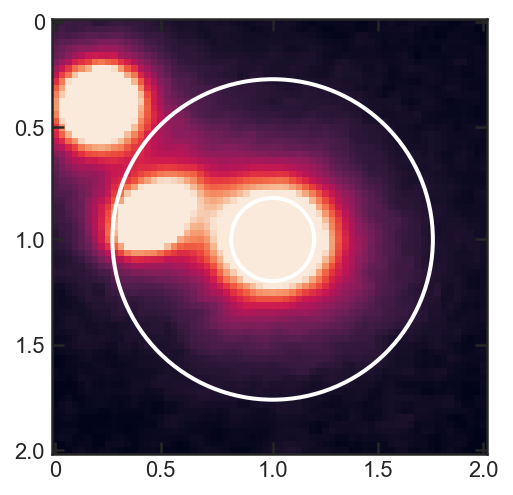

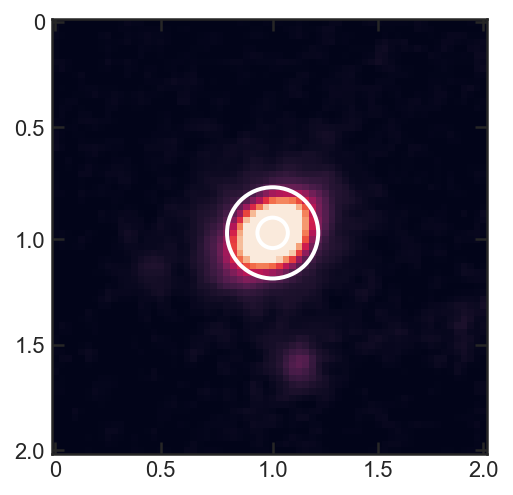

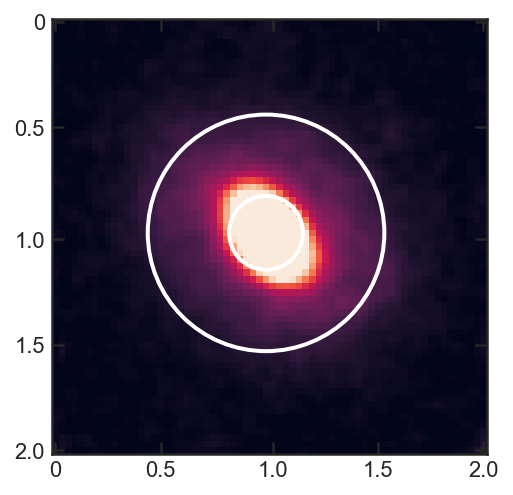

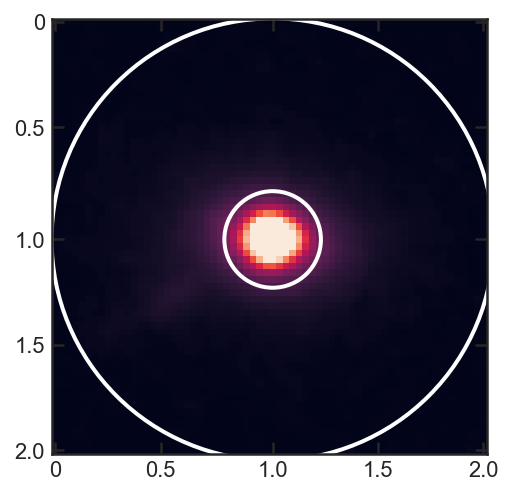

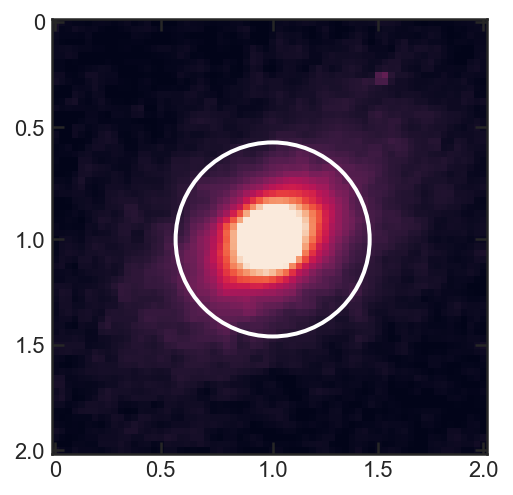

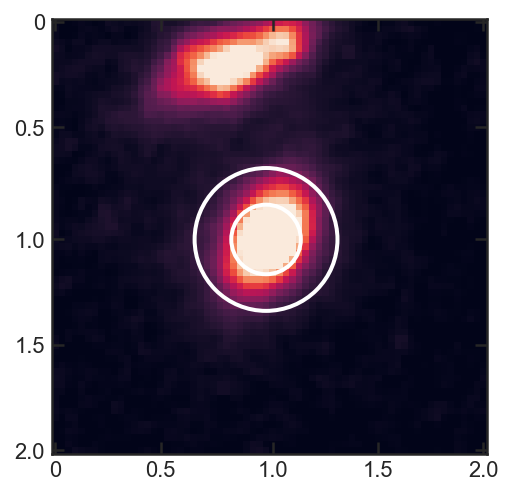

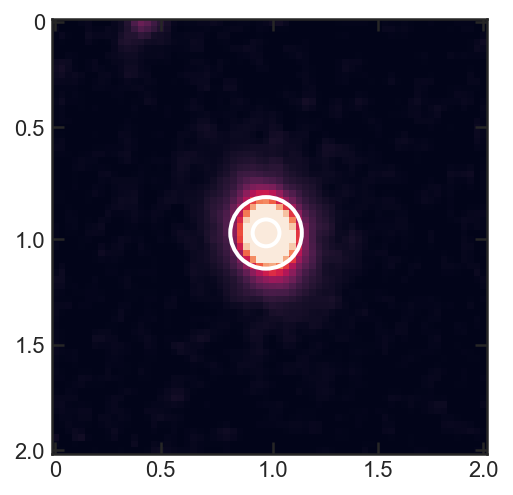

In [115]:

galaxies = [46066,39170,41520,21156,44620,45972,40862,23490]

for gal in galaxies:
    img = np.load('../data/imgfiles/{0}_{1}_rsimg.npy'.format(mdb.query('id == {}'.format(gal)).field.values[0],gal))
    grow = morph_db.query('id == {0}'.format(gal))
    
    if grow.zgrism.values[0] <= 1.5:
        filt = 'f125'
    else:
        filt = 'f160'
    
    
    if mdb.query('id == {}'.format(gal)).field.values[0][1] == 'N':
        mrow = goodsn_rad.query('NUMBER == {0}'.format(gal))
        gcat = Table.read('/Users/vestrada/Downloads/allfields/goodsn/goodsn_3dhst.v4.1_{0}w.galfit'.format(filt),format='ascii').to_pandas()      
        
    else:
        mrow = goodss_rad.query('NUMBER == {0}'.format(gal))
        gcat = Table.read('/Users/vestrada/Downloads/allfields/goodss/goodss_3dhst.v4.1_{0}w.galfit'.format(filt),format='ascii').to_pandas()      

    Bimg = np.zeros_like(img)
    for i in range(len(img)):
        for ii in range(len(img.T)):
            if i > 1 and ii > 1:
                Bimg[i][ii]=np.mean(img[i - 2 : i + 3,ii - 2 : ii + 3])

    xmax,ymax = np.argwhere(Bimg == np.max(Bimg))[0][::-1]

   
    S = Sigma_all(mdb.query('id == {}'.format(gal)).field.values[0], gal, filt, gcat)
    
    iS = interp1d(S, np.logspace(-1,2))
    r20 = iS(max(S)*0.5)/cosmo.kpc_proper_per_arcmin(grow.zgrism.values[0]).value*60 / 0.06
    r80 = iS(max(S)*0.8)/cosmo.kpc_proper_per_arcmin(grow.zgrism.values[0]).value*60 / 0.06
        
    plt.figure()
    ax = plt.subplot()
    ax.imshow(img, vmin = 0.00, vmax=0.2)
    plt.yticks([0,16,33,49,65], [0,0.5, 1.0,1.5, 2.0])
    plt.xticks([0,16,33,49,65], [0,0.5, 1.0,1.5, 2.0])

    circle1=plt.Circle([xmax,ymax],radius= r20 ,ec='w',fc='none', linewidth=2)
    ax.add_artist(circle1)

    circle2=plt.Circle([xmax,ymax],radius= r80 ,ec='w',fc='none', linewidth=2)
    ax.add_artist(circle2)


    



In [292]:
mdb.query('id == 45972').n_f160

69    5.9565
Name: n_f160, dtype: float64

In [151]:
zllim = [0.8, 0.94, 1.02, 1.2, 1.55]
zhlim = [0.94, 1.02, 1.2, 1.55, 2.5]


for i in range(len(colors)):
    vals = []
    for ii in mdb.index:
        if zllim[i] <= mdb.zgrism[ii] <zhlim[i]:
            vals.append(mdb.z_50[ii])
    print(len(vals))

24
29
32
23
27


24
29
32
23
27


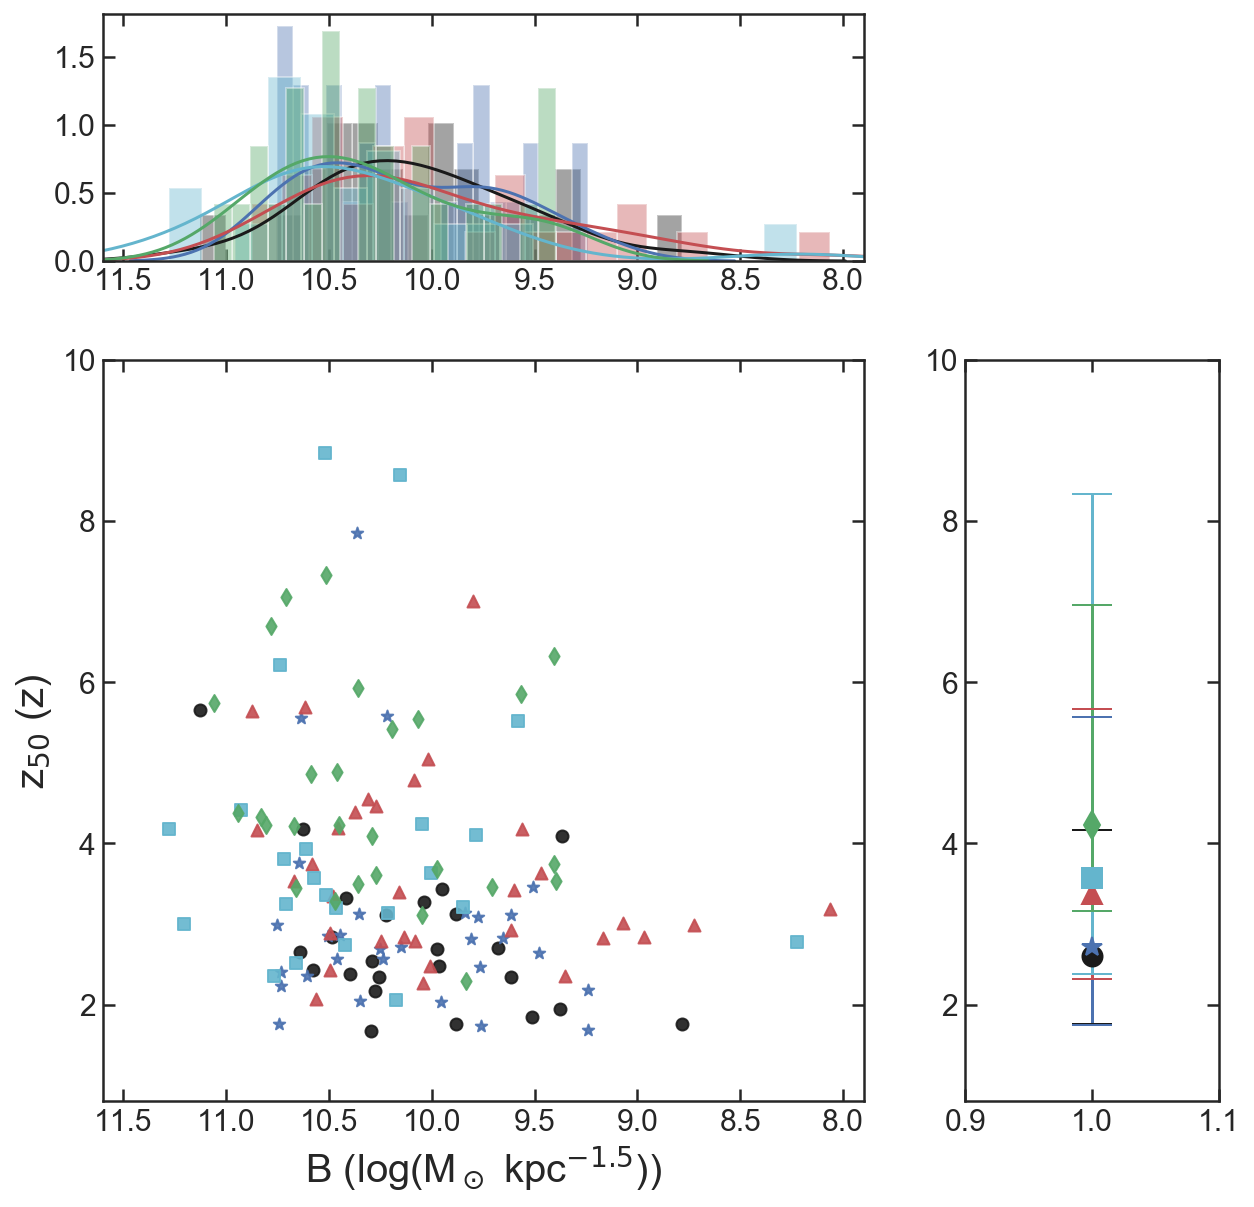

In [152]:
gs = gridspec.GridSpec(2,2,height_ratios=[1,3],width_ratios=[3,1])

colors = ['k','b','r','c','g']
markers = ['o','*','^','s','d']
zllim = [0.8, 0.94, 1.02, 1.2, 1.55]
zhlim = [0.94, 1.02, 1.2, 1.55, 2.5]


plt.figure(figsize=[10,10])
ax1 = plt.subplot(gs[1,0])

for i in range(len(colors)):
    for ii in mdb.index:
        if zllim[i] <= mdb.zgrism[ii] <zhlim[i]:
            plt.scatter(mdb.B[ii], mdb.z_50[ii], color = colors[i], marker=markers[i],
                            alpha = 0.9)

plt.ylim(0.8,10)
plt.xlim(11.6,7.9)

plt.xlabel('B (log(M$_\odot$ kpc$^{-1.5}$))', fontsize=20)
plt.ylabel('z$_{50}$ (z)', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=15)

ax2 = plt.subplot(gs[0,0])

for i in range(len(colors)):
    vals = []
    for ii in mdb.index:
        if zllim[i] <= mdb.zgrism[ii] <zhlim[i]:
            vals.append(mdb.B[ii])
    sea.distplot(vals, color = colors[i], kde = True, bins=19, ax = ax2)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.xlim(11.6,7.9)


ax3 = plt.subplot(gs[1,1])
for i in range(len(colors)):
    vals = []
    for ii in mdb.index:
        if zllim[i] <= mdb.zgrism[ii] <zhlim[i]:
            vals.append(mdb.z_50[ii])

    plt.errorbar(1, np.percentile(vals,50), 
                 yerr=[[np.percentile(vals,50) - np.percentile(vals,5)],
                       [np.percentile(vals,95) - np.percentile(vals,50)]],
                markersize = 10, marker = markers[i], capsize=10, color = colors[i])
    print(len(vals))
plt.ylim(0.8,10)
ax3.set_xlim(0.9,1.1)
plt.ylim(0.8,10)
zllim = [0.5,1.0,1.3,1.6,2.0]
plt.tick_params(axis='both', which='major', labelsize=15)

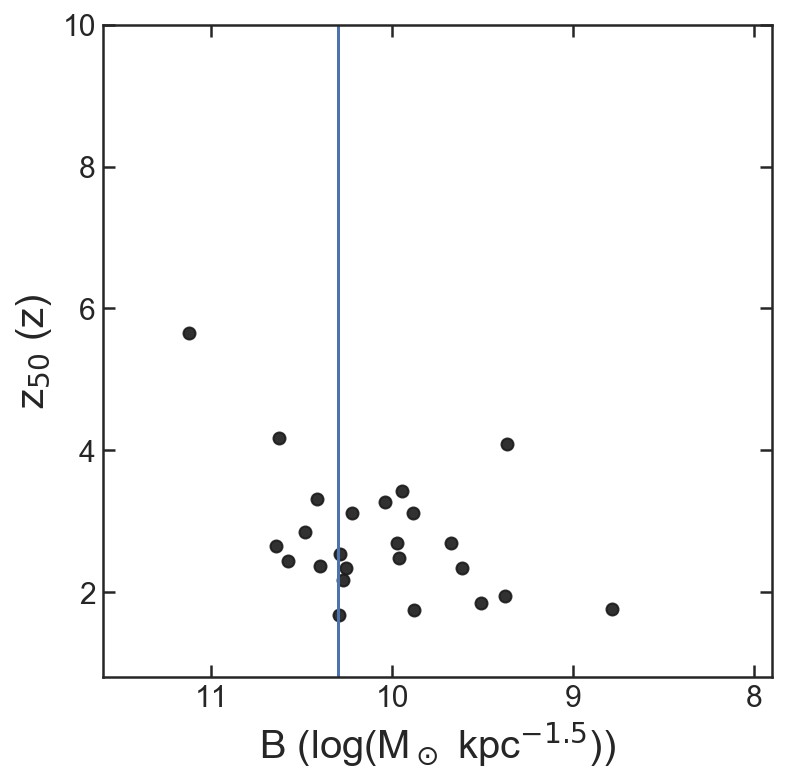

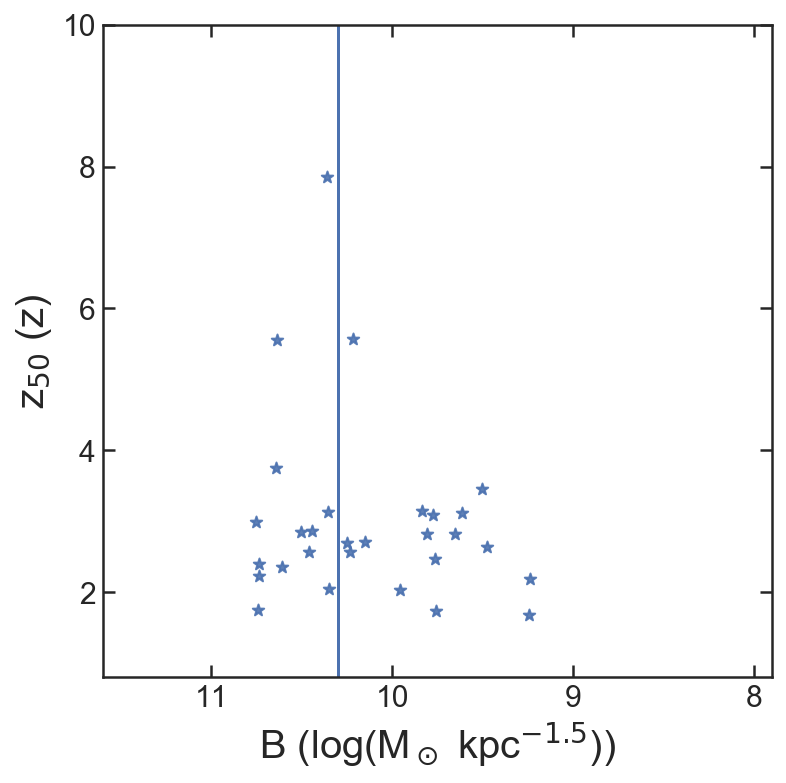

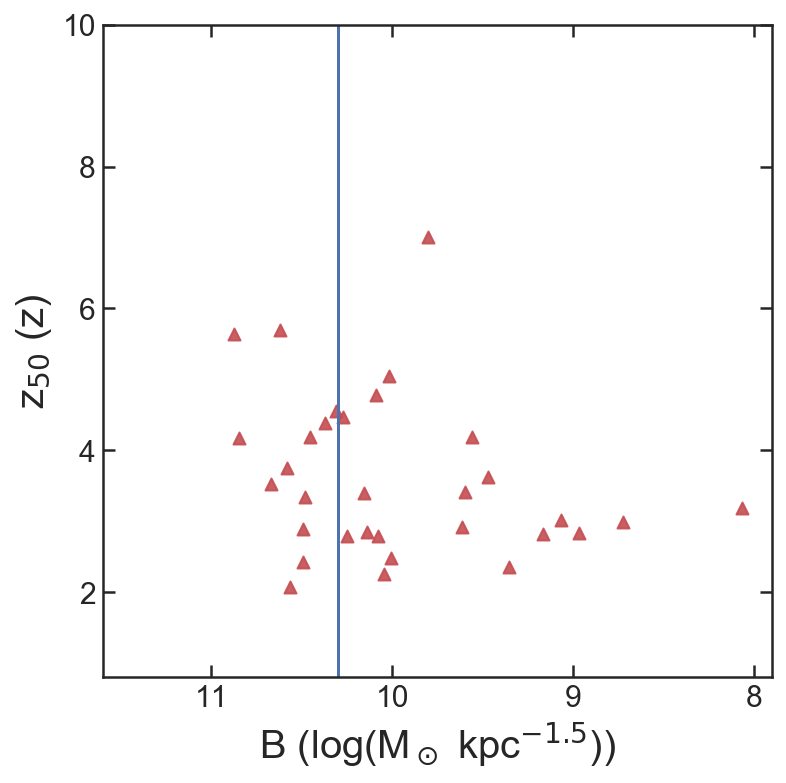

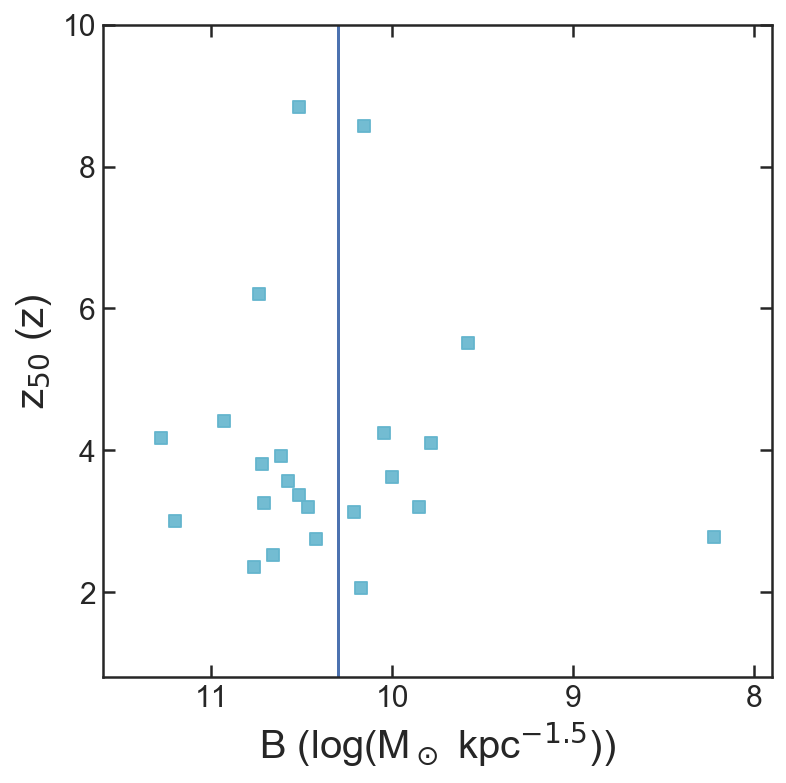

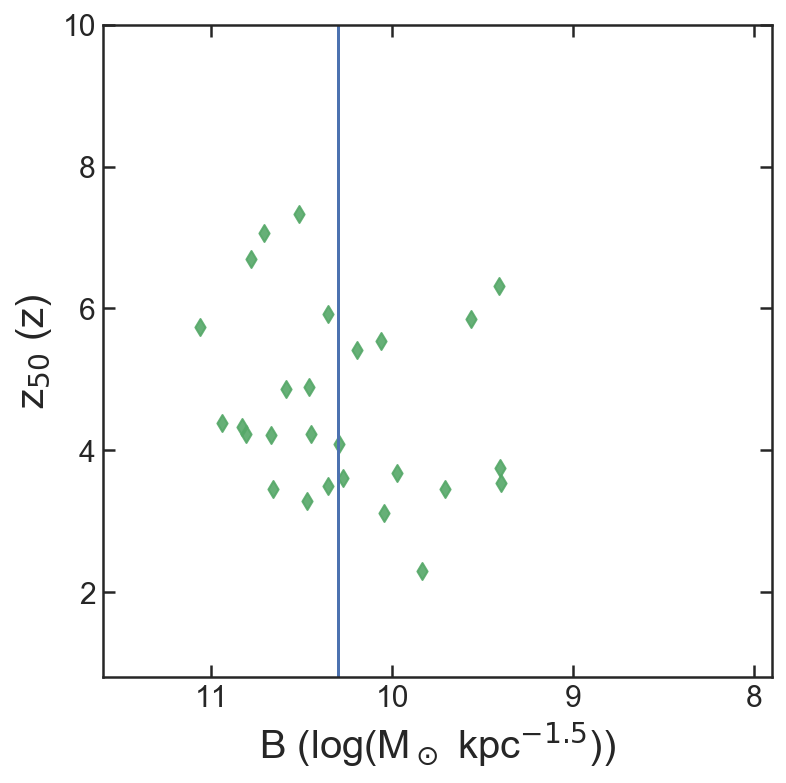

In [154]:
colors = ['k','b','r','c','g']
markers = ['o','*','^','s','d']
zllim = [0.8, 0.94, 1.02, 1.2, 1.55]
zhlim = [0.94, 1.02, 1.2, 1.55, 2.5]

for i in range(len(colors)):
    plt.figure(figsize=[6,6])

    for ii in mdb.index:
        if zllim[i] <= mdb.zgrism[ii] <zhlim[i]:
            plt.scatter(mdb.B[ii], mdb.z_50[ii], color = colors[i], marker=markers[i],
                            alpha = 0.9)
    plt.axvline(10.3)   
    plt.ylim(0.8,10)
    plt.xlim(11.6,7.9)

    plt.xlabel('B (log(M$_\odot$ kpc$^{-1.5}$))', fontsize=20)
    plt.ylabel('z$_{50}$ (z)', fontsize=20)
    plt.tick_params(axis='both', which='major', labelsize=15)

(0, 9)

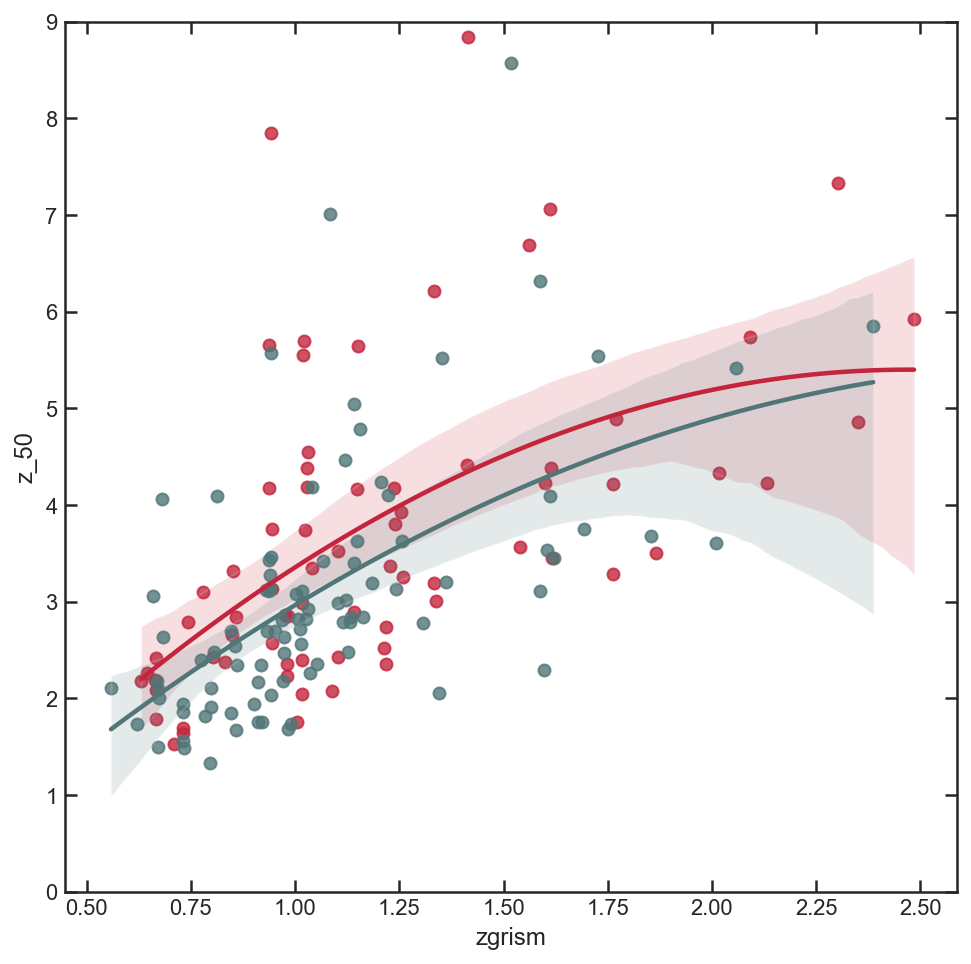

In [199]:
plt.figure(figsize=[8,8])
ax = plt.subplot()
sea.regplot(Cmdb.zgrism, Cmdb.z_50, color = '#C4253C',truncate = True, order = 2)
sea.regplot(Emdb.zgrism, Emdb.z_50, color = '#507678',truncate = True, order = 2)
ax.set_ylim(0,9)

(0, 6)

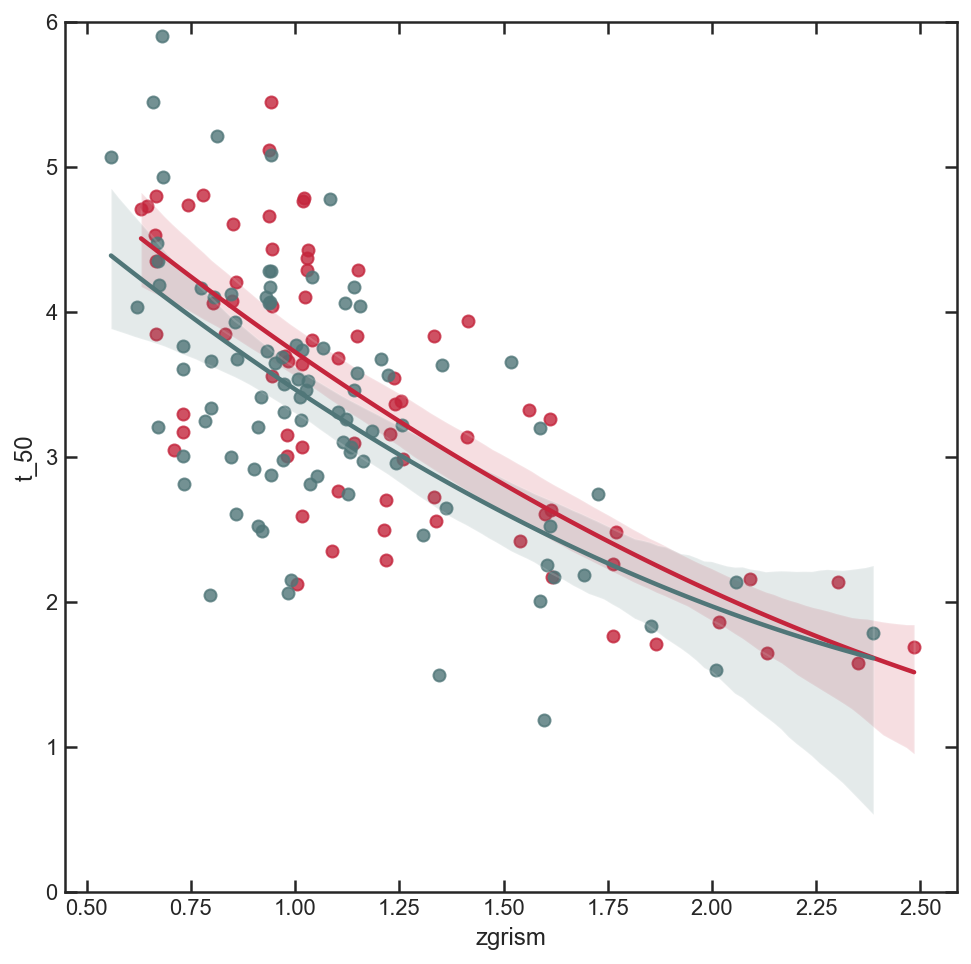

In [183]:
plt.figure(figsize=[8,8])
ax = plt.subplot()
sea.regplot(Cmdb.zgrism, Cmdb.t_50,order=2, color = '#C4253C',truncate=True)
sea.regplot(Emdb.zgrism, Emdb.t_50,order=2, color = '#507678',truncate=True)
ax.set_ylim(0,6)

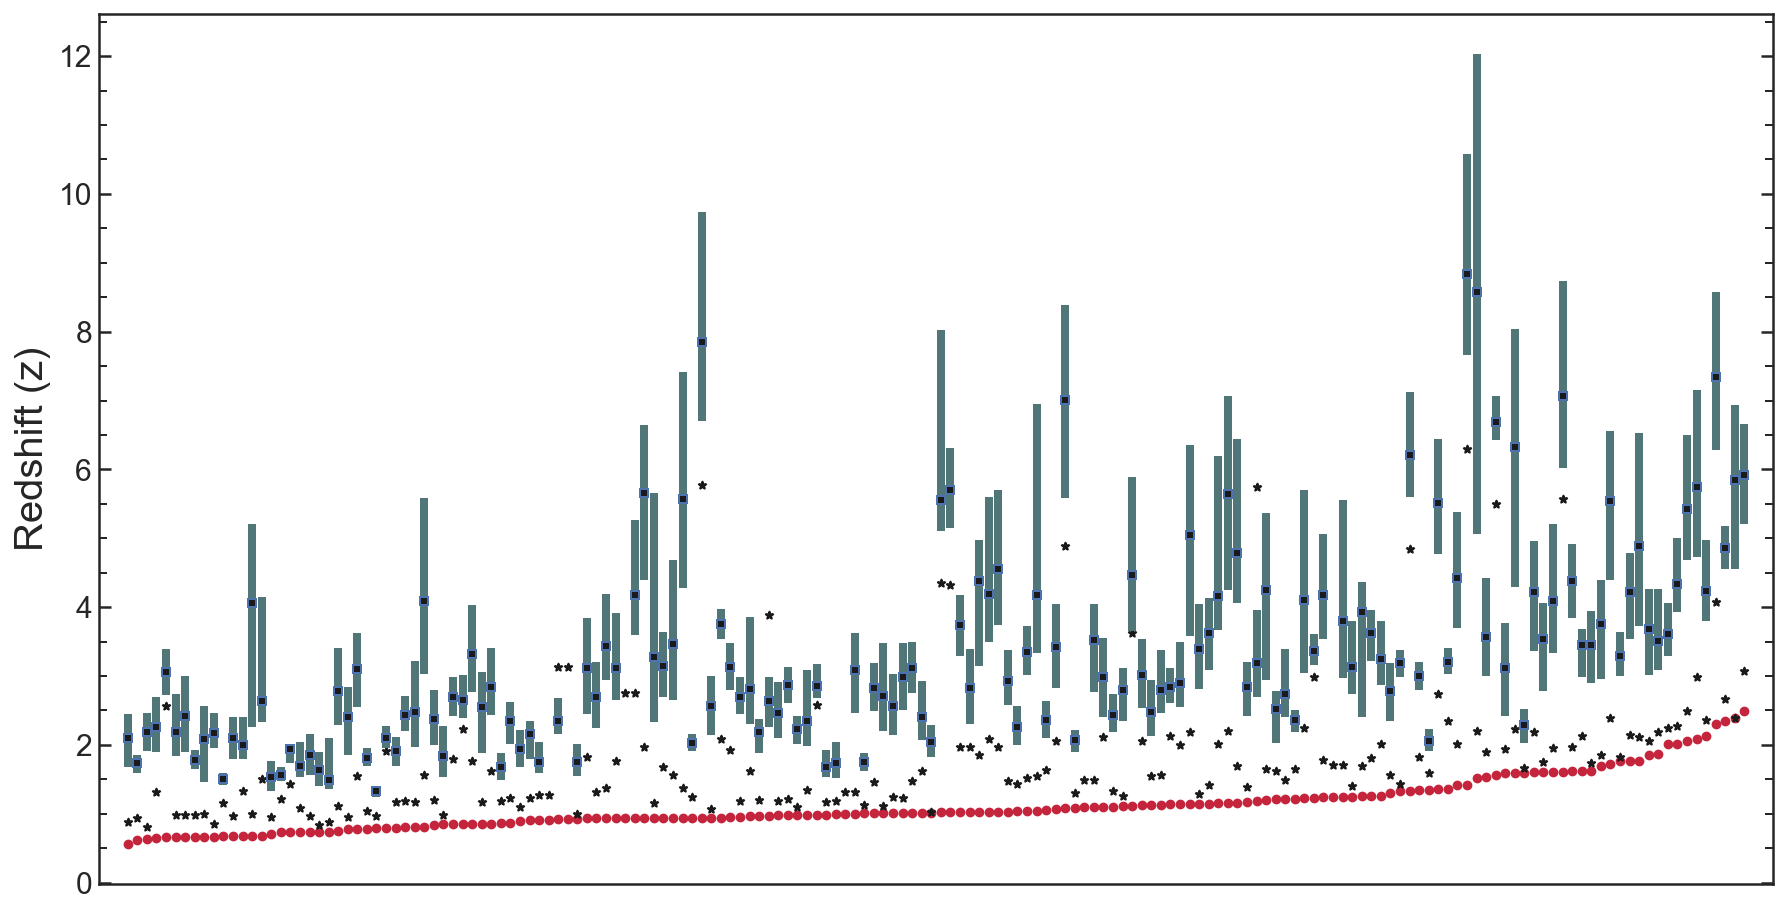

In [10]:
idx = 0
plt.figure(figsize=[15,8])
ax = plt.subplot()
for i in mdb.sort_values('zgrism').index:
    for ii in range(len(mdb.z_50_hci[i])//2):
#         if mdb.B[i] > 10.3:
        mr = 'o'
        cr = '#C4253C'
#         else:
#         mr = 'o'
#         cr = '#507678'
                
        if mdb.z_50_hci[i][2*ii] <= mdb.z_50[i] <= mdb.z_50_hci[i][2*ii+1]:
            plt.errorbar([idx],mdb.z_50[i], yerr=[[mdb.z_50[i] - mdb.z_50_hci[i][2*ii]], 
                        [mdb.z_50_hci[i][2*ii+1] - mdb.z_50[i]]],marker = 's', mfc= 'k', elinewidth = 4, ecolor = '#507678', markersize=4)
                
        plt.scatter([idx],mdb.zgrism[i], marker = mr, color = cr, s=15)
        plt.scatter([idx],mdb.z_q[i], marker = '*', color = 'k', s=15)
    
    
    
        idx += 1 
plt.xlim(-3,172)
plt.xticks([])

plt.ylabel('Redshift (z)', fontsize=20)
# plt.legend(fontsize =13, frameon = True, loc = 1)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.savefig('../plots/redshift_dist.png', bbox_inches = 'tight')

(0, 12)

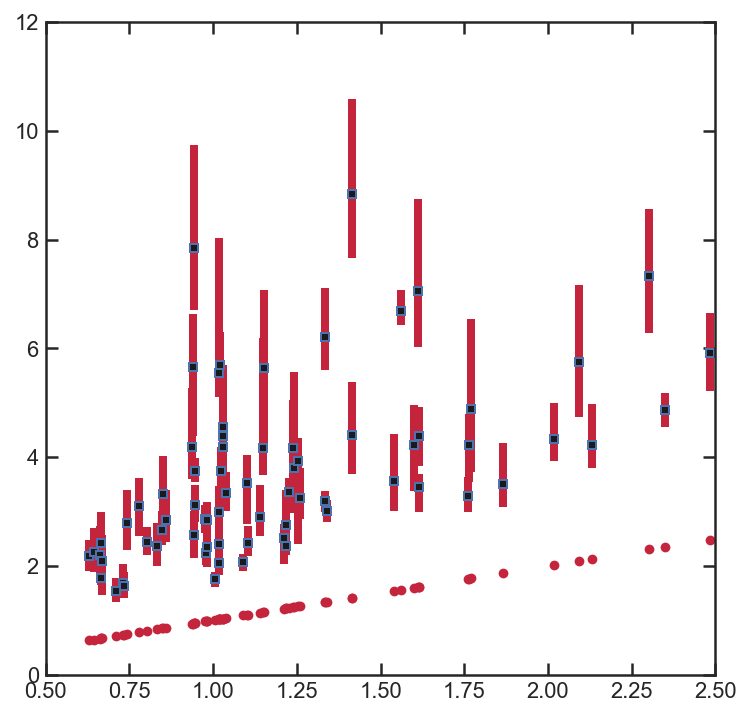

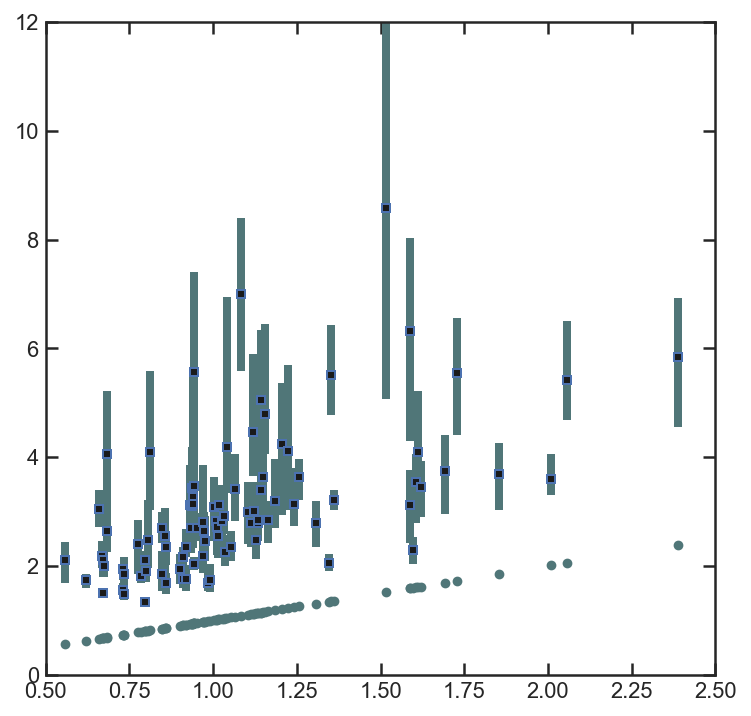

In [263]:
plt.figure(figsize=[6,6])
ax = plt.subplot()
for i in mdb.sort_values('zgrism').index:
    for ii in range(len(mdb.z_50_hci[i])//2):
        mr = 'o'
        cr = '#C4253C'
                
        if mdb.z_50_hci[i][2*ii] <= mdb.z_50[i] <= mdb.z_50_hci[i][2*ii+1] and mdb.B[i] > 10.3:
            plt.errorbar(mdb.zgrism[i],mdb.z_50[i], yerr=[[mdb.z_50[i] - mdb.z_50_hci[i][2*ii]], 
                        [mdb.z_50_hci[i][2*ii+1] - mdb.z_50[i]]],marker = 's', mfc= 'k', elinewidth = 4, ecolor = cr, markersize=4)
                
            plt.scatter(mdb.zgrism[i],mdb.zgrism[i], marker = mr, color = cr, s=15)

plt.xlim(0.5,2.5)
plt.ylim(0,12)

plt.figure(figsize=[6,6])
ax = plt.subplot()
for i in mdb.sort_values('zgrism').index:
    for ii in range(len(mdb.z_50_hci[i])//2):

        mr = 'o'
        cr = '#507678'
                
        if mdb.z_50_hci[i][2*ii] <= mdb.z_50[i] <= mdb.z_50_hci[i][2*ii+1] and mdb.B[i] < 10.3 :
            plt.errorbar(mdb.zgrism[i],mdb.z_50[i], yerr=[[mdb.z_50[i] - mdb.z_50_hci[i][2*ii]], 
                        [mdb.z_50_hci[i][2*ii+1] - mdb.z_50[i]]],marker = 's', mfc= 'k', elinewidth = 4, ecolor = cr, markersize=4)
                
            plt.scatter(mdb.zgrism[i],mdb.zgrism[i], marker = mr, color = cr, s=15)
plt.xlim(0.5,2.5)
plt.ylim(0,12)

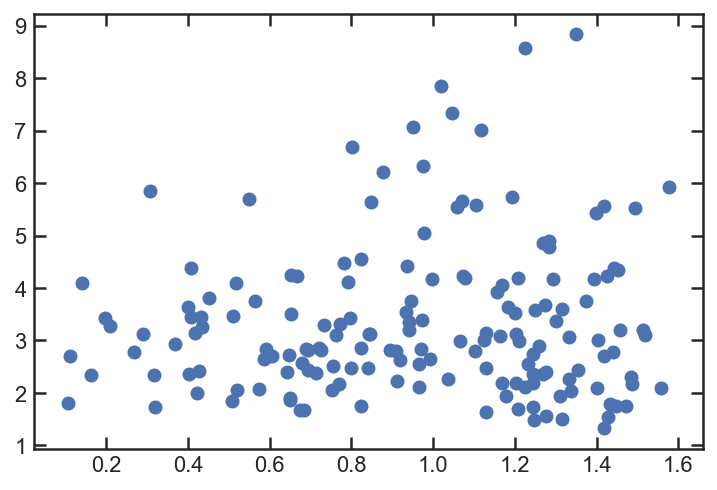

In [222]:
plt.scatter(mdb.Z, mdb.z_50)

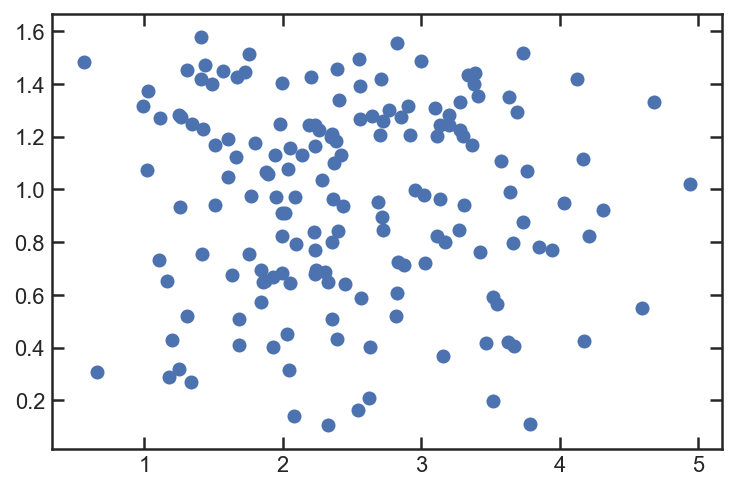

In [229]:
plt.scatter(mdb.lwa, mdb.Z)

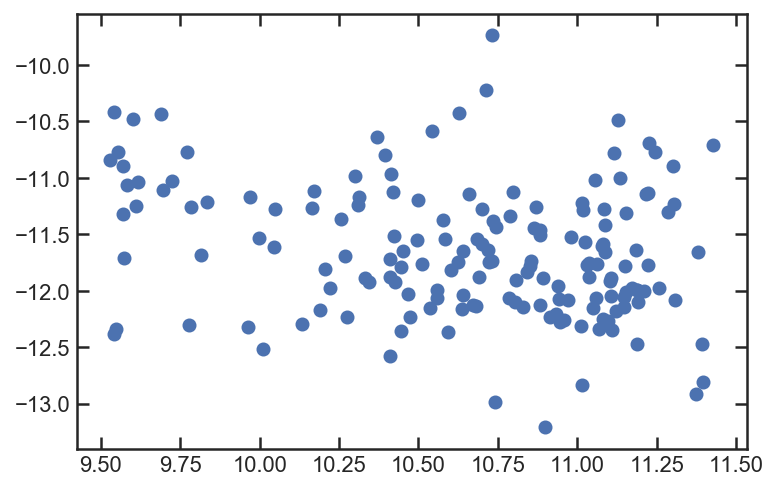

In [237]:
plt.scatter(mdb.lmass, mdb.log_ssfr)

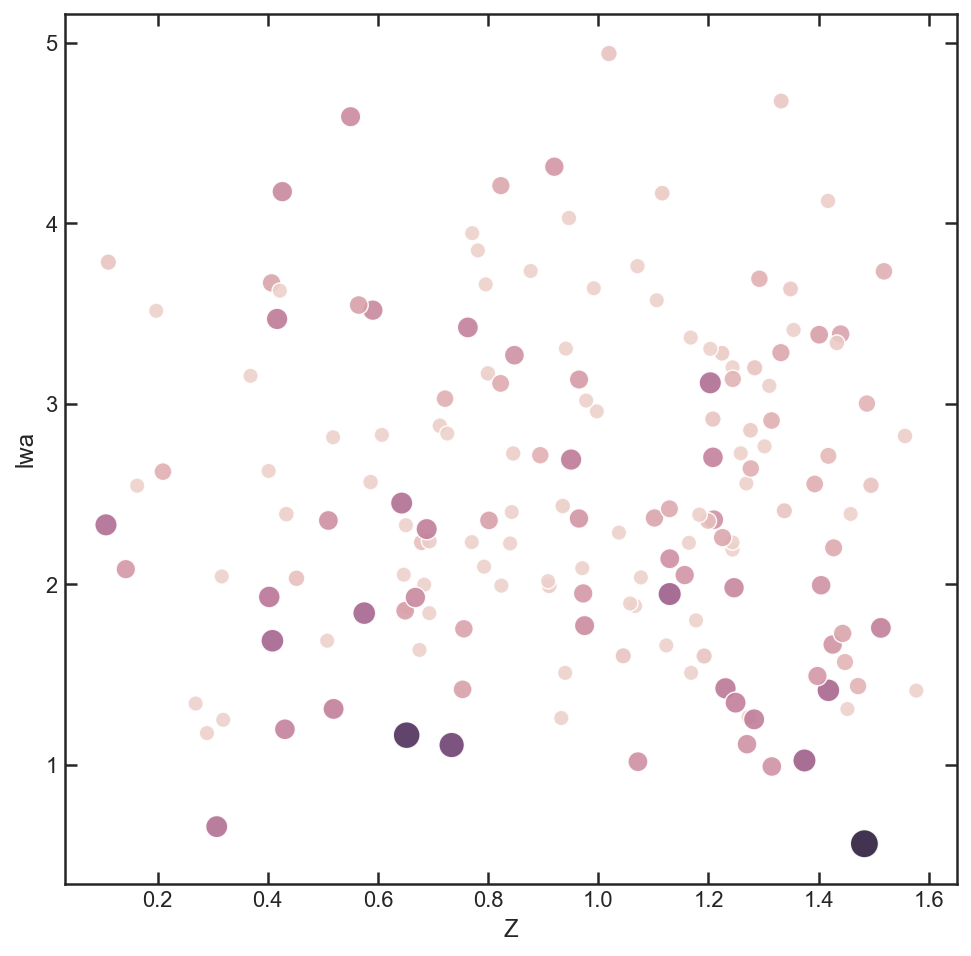

In [230]:
plt.figure(figsize=[8,8])
ax1 = plt.subplot()

sea.scatterplot(mdb.Z, mdb.lwa, color = '#507678',
                size=mdb.Av, hue=mdb.Av,sizes=(60, 200),legend=False, ax=ax1, alpha = 0.9)

/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


(0, 8)

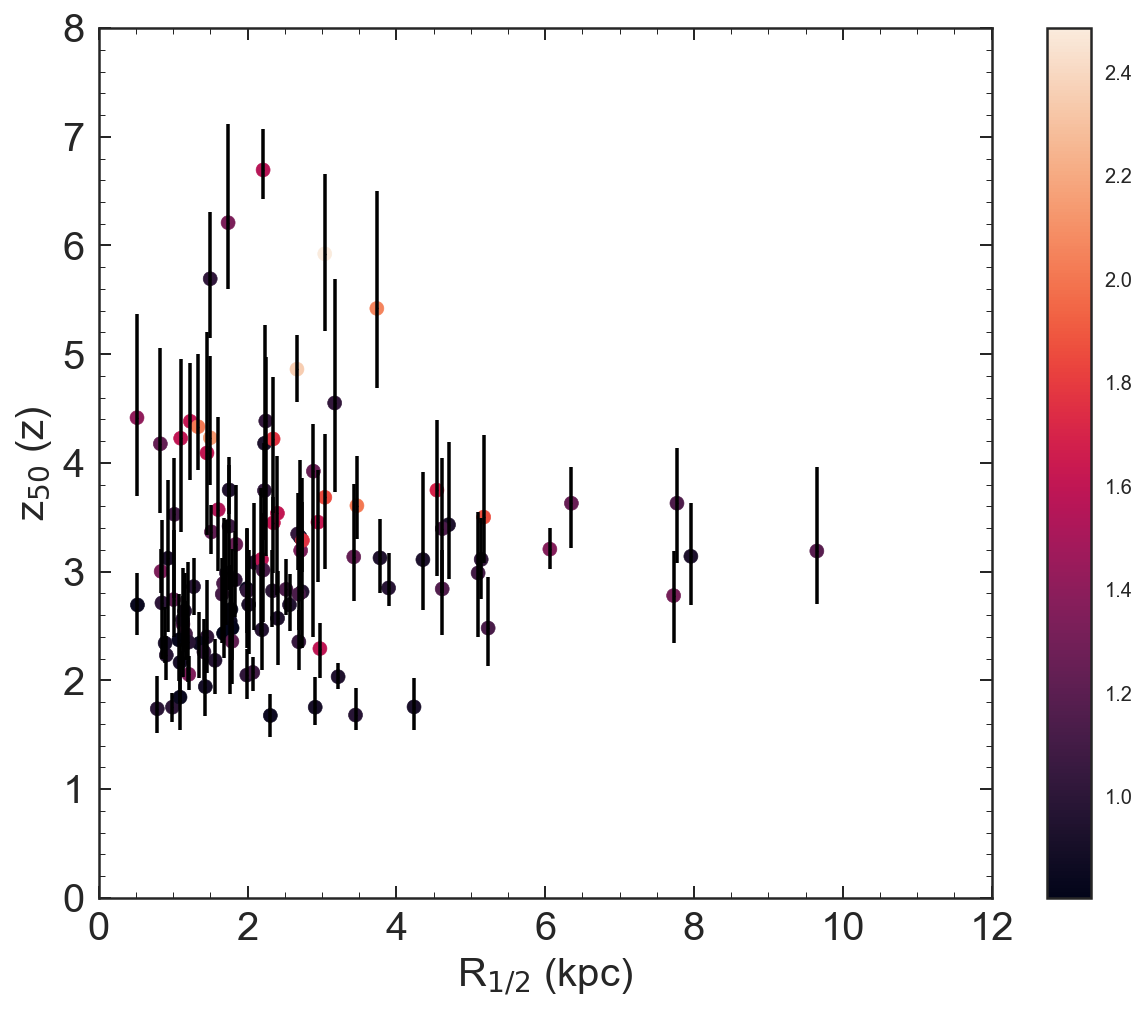

In [67]:
morph_db = pd.read_pickle('../dataframes/fitdb/tabfitdb.pkl')
mdb = morph_db.query('zgrism > 0.8 and log_ssfr  > -15')
# mdb = morph_db.query('1.8 < zgrism < 2.2 and log_ssfr  > -15')

inout = []
for i in mdb.index:
    for ii in range(len(mdb.z_50_hci[i])//2):
        if mdb.z_50_hci[i][2*ii] <= mdb.z_50[i] <= mdb.z_50_hci[i][2*ii+1]:
            if (mdb.z_50_hci[i][2*ii+1] - mdb.z_50_hci[i][2*ii]) /2  < 1:
                inout.append('i')
            else:
                inout.append('o')
        
mdb['inout'] = inout
mdb = mdb.query('inout == "i"')

plt.figure(figsize=[10,8])

for i in mdb.index:
    for ii in range(len(mdb.z_50_hci[i])//2):
        if mdb.z_50_hci[i][2*ii] <= mdb.z_50[i] <= mdb.z_50_hci[i][2*ii+1]:
            plt.errorbar(mdb.Reff[i],mdb.z_50[i], 
                 yerr=[[mdb.z_50[i] - mdb.z_50_hci[i][2*ii]], [mdb.z_50_hci[i][2*ii+1] - mdb.z_50[i]]], fmt='ko',
                        markersize=1)
plt.scatter(mdb.Reff, mdb.z_50, marker='o', c = mdb.zgrism)

# plt.hexbin(mdb.Reff, mdb.z_50, cmap = cmap)
# plt.scatter(sfdb.Reff,sfdb.z50, marker = '*',c = sfdb.log_ssfr, s =100)
plt.colorbar()

plt.xlabel('R$_{1/2}$ (kpc)', fontsize=20)
plt.ylabel('z$_{50}$ (z)', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.xlim(0,12)
plt.ylim(0,8)
# plt.savefig('../plots/morph/z_50_r.png', bbox_inches = 'tight')

# plots for presentation

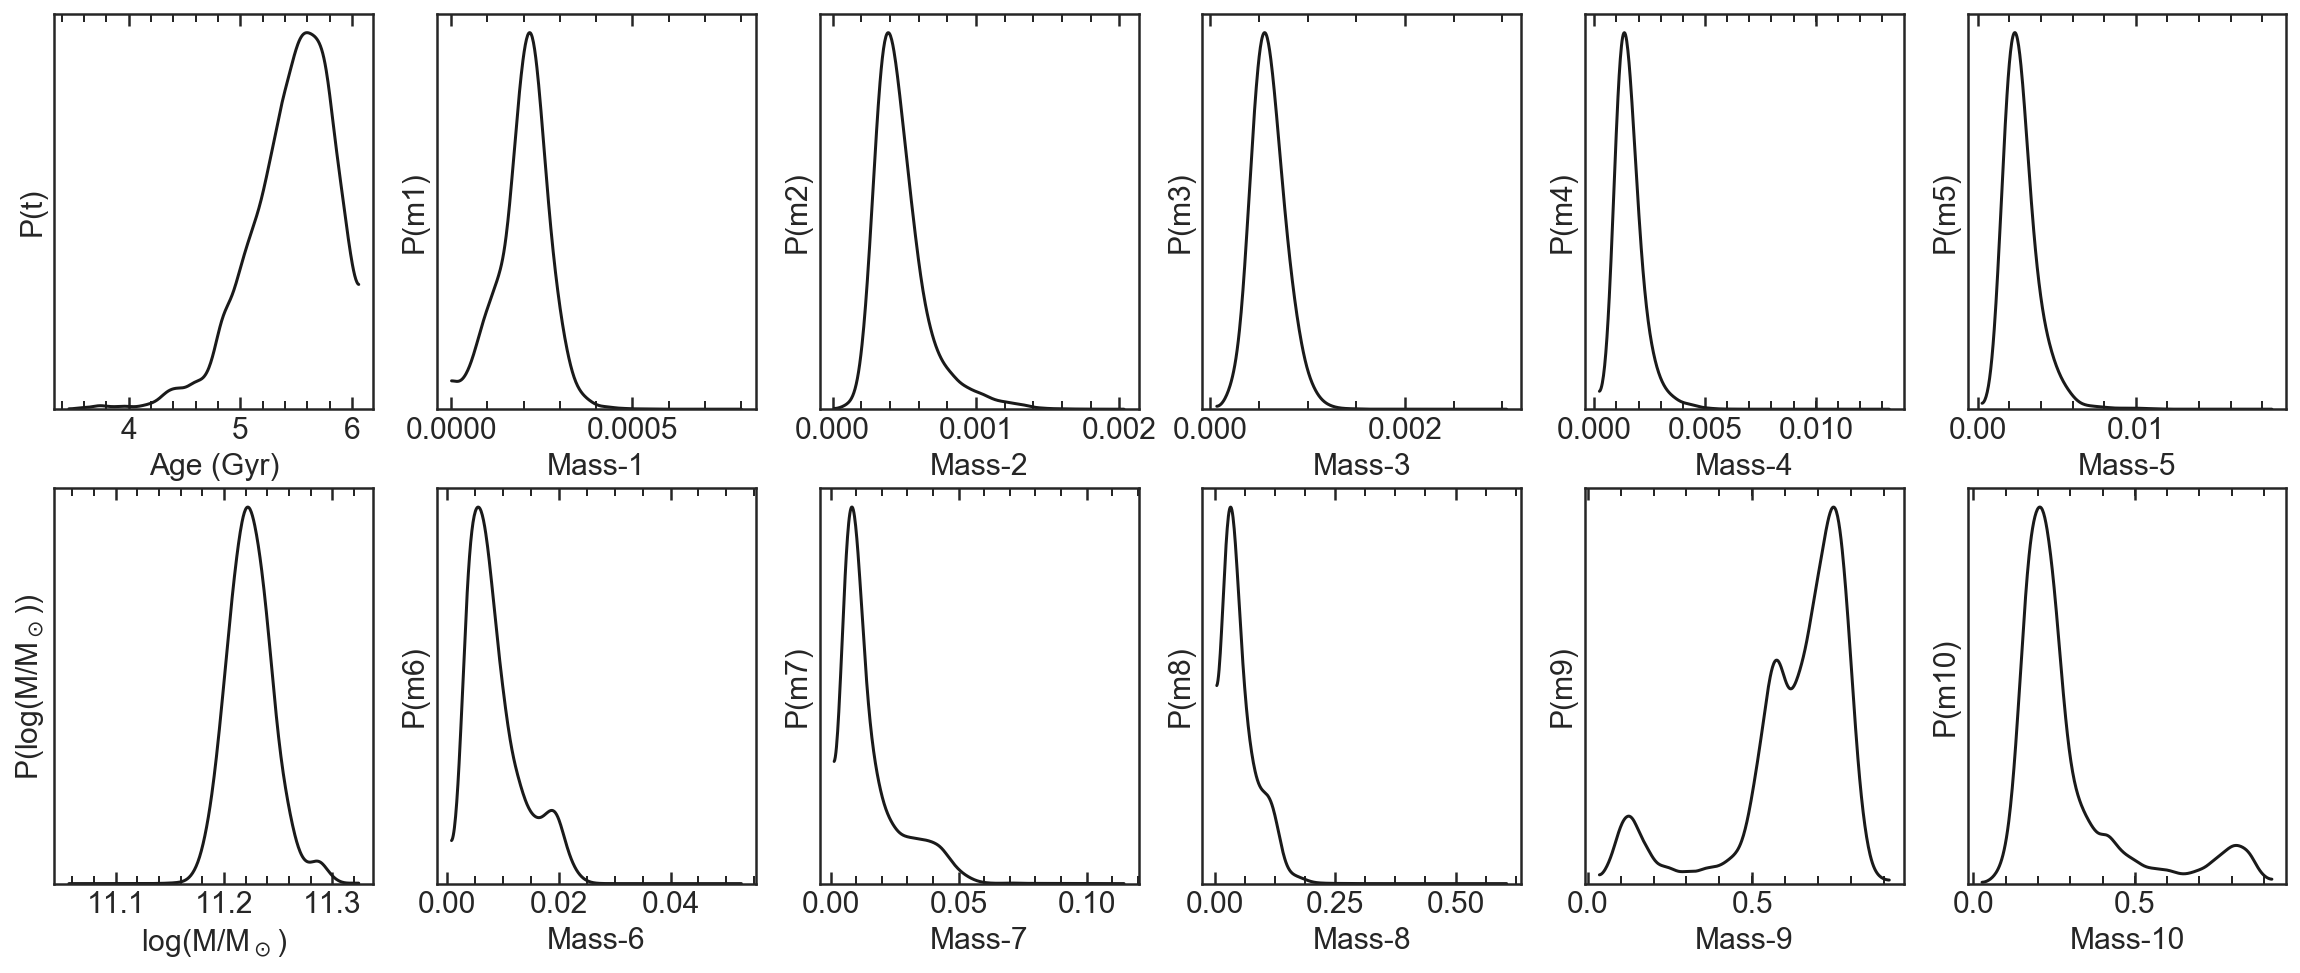

In [361]:
def plot_posterior(field, galaxy, param, x_name, y_name):
    z,pz = np.load('../data/posteriors/{0}_{1}_tabfit_P{2}.npy'.format(field, galaxy, param))

    plt.plot(z,pz,'k')
    plt.xlabel('{0}'.format(x_name), fontsize=15)
    plt.ylabel('P({0})'.format(y_name), fontsize=15)
    plt.tick_params(axis='both', which='major', labelsize=15)
    plt.ylim(0,max(pz)*1.05)
    plt.yticks([])

params = ['a', 'm1', 'm2', 'm3', 'm4', 'm5', 'lm', 'm6', 'm7', 'm8', 'm9', 'm10']
x_name = ['Age (Gyr)', 'Mass-1', 'Mass-2', 'Mass-3', 'Mass-4', 'Mass-5', 'log(M/M$_\odot$)', 'Mass-6', 'Mass-7', 'Mass-8', 'Mass-9', 
          'Mass-10']
y_name = ['t', 'm1', 'm2', 'm3', 'm4', 'm5', 'log(M/M$_\odot$)', 'm6', 'm7', 'm8', 'm9', 'm10']

gs = gridspec.GridSpec(2,6)
plt.figure(figsize=[20,8])

row = 0
col = 0
for i in range(len(params)):
    plt.subplot(gs[row, col])
    plot_posterior('GND', 37813, params[i], x_name[i], y_name[i])
    col += 1
    if i == 5:
        row =1 
        col = 0
plt.savefig('../plots/GND_37813_post.png',bbox_inches = 'tight')


In [3]:
sfh = Rescale_sfh('GND', 37813)

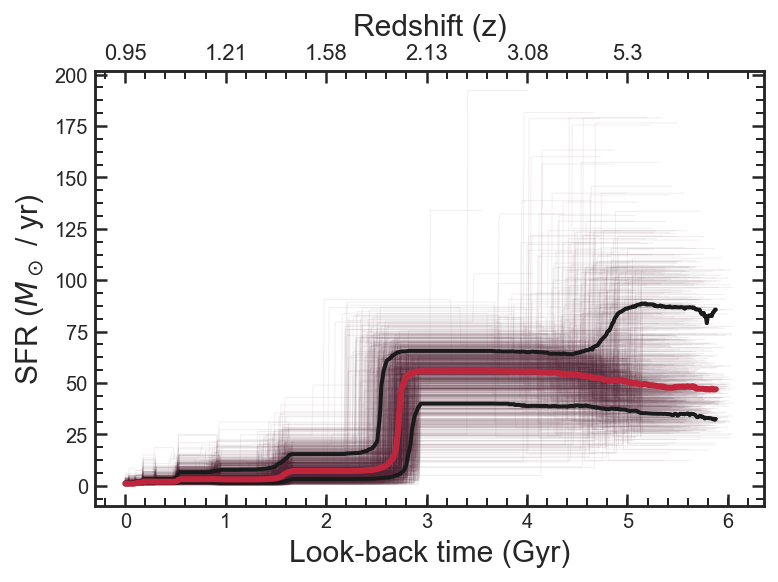

In [410]:
grow = mdb.query('id == 37813')

isfhl = interp1d(sfh.LBT,sfh.SFH_16)
isfhh = interp1d(sfh.LBT,sfh.SFH_84)

ax1 = plt.subplot()
ax2 = ax1.twiny()

ax1.plot(sfh.fulltimes, sfh.sfr_grid.T, color = '#532436', alpha=.075, linewidth = 0.5)
ax1.plot(sfh.LBT,sfh.SFH, color = '#C1253C', linewidth = 3, zorder = 9)
ax1.plot(sfh.LBT,sfh.SFH_16, 'k', linewidth = 2)
ax1.plot(sfh.LBT,sfh.SFH_84, 'k', linewidth = 2)

ax2.set_xlim(ax1.get_xlim())
ax2.set_xticks(np.arange(0,int(sfh.fulltimes[-1])))
ax2.set_xticklabels(np.round(lbt_to_z(np.arange(0,int(sfh.fulltimes[-1])) + cosmo.lookback_time(grow.zgrism.values[0]).value),2))
ax2.xaxis.set_ticks_position('top')

ax1.set_xlabel('Look-back time (Gyr)', fontsize=15)
ax1.set_ylabel('SFR ($M_\odot$ / yr)', fontsize=15)
ax2.set_xlabel('Redshift (z)', fontsize=15) 
ax1.tick_params(axis='both', which='major', labelsize=10)
plt.savefig('../plots/GND_37813_all_sfh.png',bbox_inches = 'tight')

# ax1.vlines(grow.t_50.values[0],isfhl(grow.t_50.values[0]), isfhh(grow.t_50.values[0]), color = '#ED2D39', linewidth = 2, zorder = 11)
# ax1.vlines(grow.t_50.values[0],isfhl(grow.t_50.values[0]), isfhh(grow.t_50.values[0]), color = 'k', linewidth = 4, zorder = 10)

# for i in range(len(grow.t_50_hci.values[0])//2):
#     hdr = np.linspace(grow.t_50_hci.values[0][2*i],grow.t_50_hci.values[0][2*i+1])

#     ax1.fill_between(hdr, isfhh(hdr), isfhl(hdr), color = '#4E7577', alpha=0.75, zorder = 8)
#     ax1.vlines(grow.t_50_hci.values[0][2*i],isfhl(grow.t_50_hci.values[0][2*i]),isfhh(grow.t_50_hci.values[0][2*i]), 
#                color = 'k', linewidth = 1, zorder = 8)
#     ax1.vlines(grow.t_50_hci.values[0][2*i+1],isfhl(grow.t_50_hci.values[0][2*i+1]),isfhh(grow.t_50_hci.values[0][2*i+1]), 
#                color = 'k', linewidth = 1, zorder = 8)

# ax1.vlines(grow.t_q.values[0],isfhl(grow.t_q.values[0]),isfhh(grow.t_q.values[0]), color = '#4E7577', linewidth = 2, zorder = 11)
# ax1.vlines(grow.t_q.values[0],isfhl(grow.t_q.values[0]),isfhh(grow.t_q.values[0]), color = 'k', linewidth = 4, zorder = 10)

# for i in range(len(grow.t_q_hci.values[0])//2):
#     hdr = np.linspace(grow.t_q_hci.values[0][2*i],grow.t_q_hci.values[0][2*i+1])

#     ax1.fill_between(hdr, isfhh(hdr), isfhl(hdr), color = 'k', alpha=0.6, zorder = 8)
#     ax1.vlines(grow.t_q_hci.values[0][2*i],isfhl(grow.t_q_hci.values[0][2*i]),isfhh(grow.t_q_hci.values[0][2*i]), 
#                color = 'k', linewidth = 1, zorder = 8)
#     ax1.vlines(grow.t_q_hci.values[0][2*i+1],isfhl(grow.t_q_hci.values[0][2*i+1]),isfhh(grow.t_q_hci.values[0][2*i+1]), 
#                color = 'k', linewidth = 1, zorder = 8)

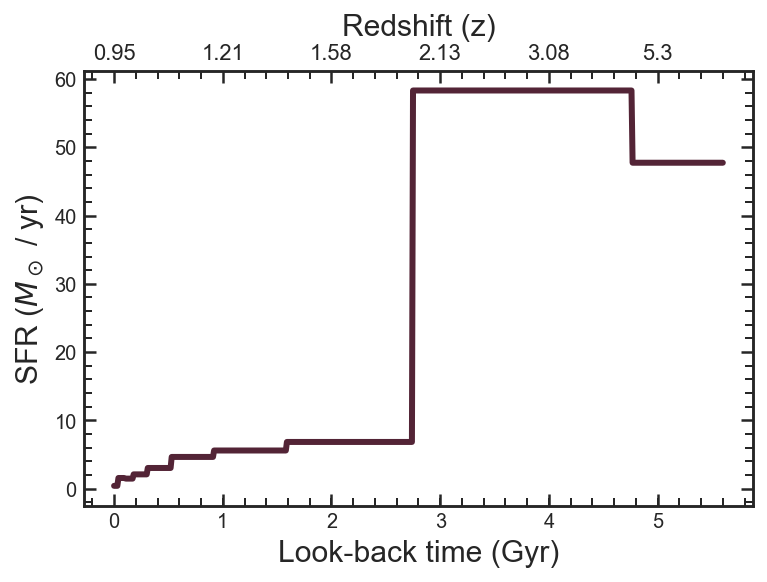

In [407]:
ax1 = plt.subplot()
ax2 = ax1.twiny()

ax1.plot(sfh.fulltimes, sfh.sfr_grid[0], color = '#532436', linewidth = 3)

ax2.set_xlim(ax1.get_xlim())
ax2.set_xticks(np.arange(0,int(sfh.fulltimes[-1])))
ax2.set_xticklabels(np.round(lbt_to_z(np.arange(0,int(sfh.fulltimes[-1])) + cosmo.lookback_time(grow.zgrism.values[0]).value),2))
ax2.xaxis.set_ticks_position('top')

ax1.set_xlabel('Look-back time (Gyr)', fontsize=15)
ax1.set_ylabel('SFR ($M_\odot$ / yr)', fontsize=15)
ax2.set_xlabel('Redshift (z)', fontsize=15) 
ax1.tick_params(axis='both', which='major', labelsize=10)
plt.savefig('../plots/GND_37813_single_sfh.png',bbox_inches = 'tight')


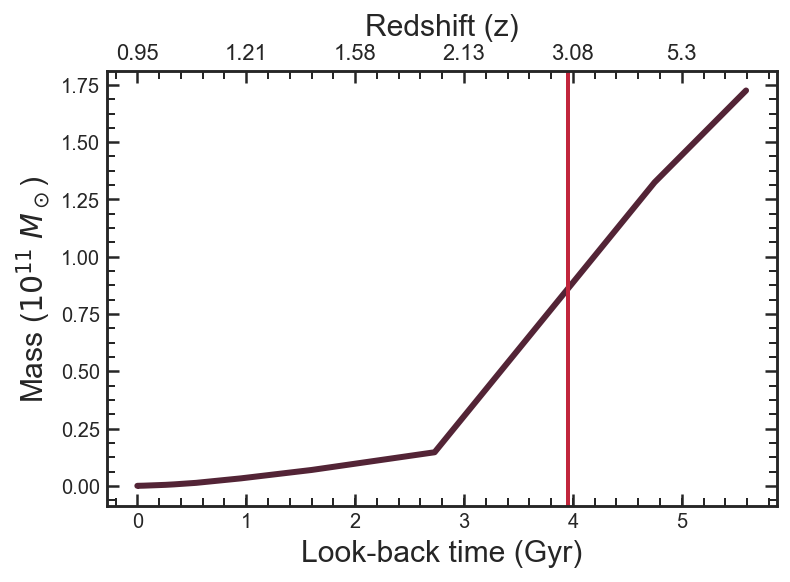

In [408]:
T=[0]
M=[0]
for i in range(len(sfh.fulltimes)-1):
    mass = sfh.sfr_grid[0][i+1] * (sfh.fulltimes[i+1] - sfh.fulltimes[i])
    if mass > 0:
        M.append(M[i] + mass)
        T.append(sfh.fulltimes[i])
    
t_50=interp1d(M/ M[-1], T)(0.5)

ax1 = plt.subplot()
ax2 = ax1.twiny()

ax1.plot(T, np.array(M)/100, color = '#532436', linewidth =3)
ax1.axvline(t_50,color = '#C1253C', linewidth =2)

ax2.set_xlim(ax1.get_xlim())
ax2.set_xticks(np.arange(0,int(sfh.fulltimes[-1])))
ax2.set_xticklabels(np.round(lbt_to_z(np.arange(0,int(sfh.fulltimes[-1])) + cosmo.lookback_time(grow.zgrism.values[0]).value),2))
ax2.xaxis.set_ticks_position('top')

ax1.set_xlabel('Look-back time (Gyr)', fontsize=15)
ax1.set_ylabel('Mass ($10^{11}$ $M_\odot$)', fontsize=15)
ax2.set_xlabel('Redshift (z)', fontsize=15) 
ax1.tick_params(axis='both', which='major', labelsize=10)
plt.savefig('../plots/GND_37813_single_mass.png',bbox_inches = 'tight')


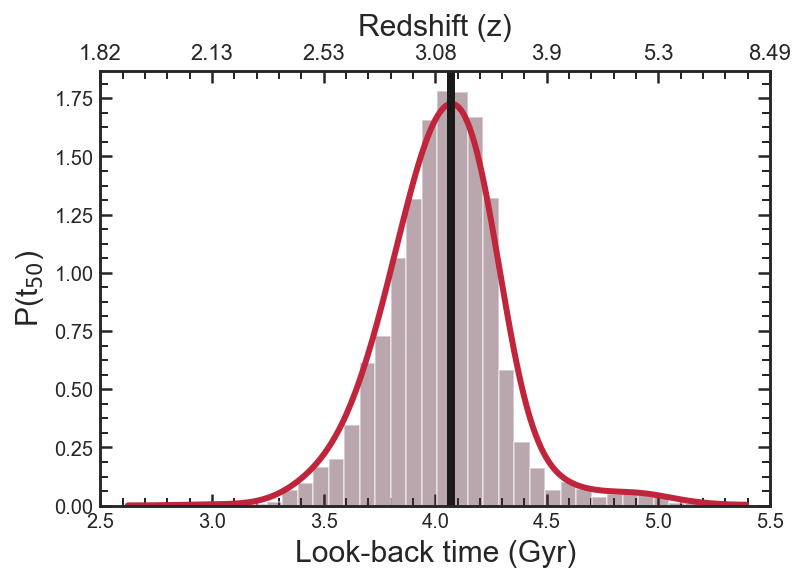

In [67]:
grow = mdb.query('id == 37813')

ax1 = plt.subplot()
ax2 = ax1.twiny()

sea.distplot(sfh.t_50_grid, hist_kws={'weights': sfh.weights}, kde=False, color = '#532436', norm_hist=True, bins=40, ax = ax1)
ax1.plot(x,np.array(px)*1.07 ,color = '#C1253C', linewidth = 3)
ax1.axvline(sfh.t_50,color = 'k', linewidth=4)
ax1.set_xlim(2.5,5.5)
ax2.set_xticks(np.arange(7))
ax2.set_xticklabels(np.round(lbt_to_z(np.arange(2.5,6.0,0.5) + cosmo.lookback_time(grow.zgrism.values[0]).value),2))
ax2.xaxis.set_ticks_position('top')

ax1.set_xlabel('Look-back time (Gyr)', fontsize=15)
ax1.set_ylabel('P(t$_{50}$)', fontsize=15)
ax2.set_xlabel('Redshift (z)', fontsize=15) 
ax1.tick_params(axis='both', which='major', labelsize=10)
plt.savefig('../plots/GND_37813_z_50.png',bbox_inches = 'tight')


In [60]:
sfh.z_50, sfh.t_50,np.arange(2.5,6.0,0.5)

(array(3.17263358),
 4.071991551884423,
 array([2.5, 3. , 3.5, 4. , 4.5, 5. , 5.5]))

In [58]:
np.round(lbt_to_z(np.arange(2.5,6.0,0.5) + cosmo.lookback_time(grow.zgrism.values[0]).value),2)

array([1.82, 2.13, 2.53, 3.08, 3.9 , 5.3 , 8.49])

In [57]:
age_to_z(Oldest_galaxy(grow.zgrism.values[0]) - np.arange(2.5,5.5,0.5)), age_to_z(Oldest_galaxy(grow.zgrism.values[0]) - sfh.t_50), 

(array([1.8223851 , 2.12754416, 2.52601124, 3.07533669, 3.89660369,
        5.30265061]), array(3.17260425))

In [24]:
from dynesty.utils import quantile as _quantile
from scipy.ndimage import gaussian_filter as norm_kde

def boot_to_posterior(values, weights):
    q = [0.5 - 0.5 * 0.999999426697, 0.5 + 0.5 * 0.999999426697]
    span = _quantile(values, q, weights=weights)

    s = 0.02

    bins = int(round(10. / 0.02))
    n, b = np.histogram(values, bins=bins, weights=weights,range=np.sort(span))
    n = norm_kde(n, 20.)
    x0 = 0.5 * (b[1:] + b[:-1])
    y0 = n
    
    return x0, y0 / np.trapz(y0,x0)

x,px = boot_to_posterior(sfh.t_50_grid, sfh.weights)

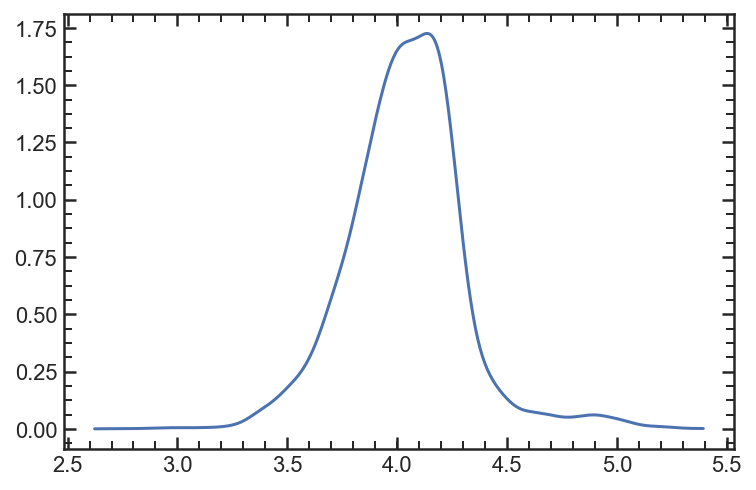

In [15]:
plt.plot(x,px)